In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
import sys
#PATH = '/content/drive/My Drive/PPM_Stability/'
PATH = "C:/Users/velmurug/Documents/Stability Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/Mythreyi/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
#PATH = "C:/Users/mythr/Documents/GitHub/Stability-Experiments/benchmark_interpretability/PPM_Stability/"
sys.path.append(PATH)

In [2]:
#!pip install lime
#!pip install shap
#!pip install pandas==0.19.2
!pip install xgboost==1.0.0

In [3]:
import EncoderFactory
from DatasetManager import DatasetManager
import BucketFactory
import stability as st #Nogueira, Sechidis, Brown.

import pandas as pd
import numpy as np
from scipy import stats
import math

from sklearn.metrics import roc_auc_score
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

import time
import os
import sys
from sys import argv
import pickle
from collections import defaultdict, Counter
import random
import joblib

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

import lime
import lime.lime_tabular
from lime import submodular_pick;

import shap

import warnings
warnings.filterwarnings('ignore')

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def imp_df(column_names, importances):
        df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
        return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title, num_feat):
        imp_df.columns = ['feature', 'feature_importance']
        b= sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df.head(num_feat), orient = 'h', palette="Blues_r")

In [5]:
def generate_global_explanations(train_X,train_Y, cls, feature_combiner):
    
    print("The number of testing instances is ",len(train_Y))
    print("The total number of columns is",train_X.shape[1]);
    print("The total accuracy is ",cls.score(train_X,train_Y));
       
    sns.set(rc={'figure.figsize':(10,10), "font.size":18,"axes.titlesize":18,"axes.labelsize":18})
    sns.set
    feat_names = feature_combiner.get_feature_names()
    base_imp = imp_df(feat_names, cls.feature_importances_)
    base_imp.head(15)
    var_imp_plot(base_imp, 'Feature importance using XGBoost', 15)
    return base_imp

In [6]:
from lime import submodular_pick
def generate_lime_explanations(explainer,test_xi, cls,test_y, submod=False, test_all_data=None, max_feat = 10):
    
    #print("Actual value ", test_y)
    exp = explainer.explain_instance(test_xi, 
                                 cls.predict_proba, num_features=max_feat, labels=[0,1])
    
    return exp
        
    if submod==True:
        sp_obj=submodular_pick.SubmodularPick(explainer, test_all_data, cls.predict_proba, 
                                      sample_size=20, num_features=num_features,num_exps_desired=4)
        [exp.as_pyplot_figure(label=exp.available_labels()[0]) for exp in sp_obj.sp_explanations];

In [7]:
def create_samples(shap_explainer, iterations, row, features, top = None):
    length = len(features)
    
    exp = []
    rel_exp = []
    
    for j in range(iterations):
        
        #if shap_type == "kernel":
        #    shap_explainer = shap.KernelExplainer(cls.predict, trainingsample)
        #elif shap_type == "tree":
        #    shap_explainer = shap.TreeExplainer(cls)
        #elif shap_type == "deep":
        #    shap_explainer = shap.DeepExplainer(cls, background)
        
        #print(X_test_frame.loc[row])
        shap_values = shap_explainer.shap_values(row)
        #print(shap_values)

        importances = []
        
        if type(shap_explainer) == shap.explainers.kernel.KernelExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
                
        elif type(shap_explainer) == shap.explainers.tree.TreeExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][i]
                abs_val = abs(shap_values[0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        elif type(shap_explainer) == shap.explainers.deep.DeepExplainer:
            for i in range(length):
                feat = features[i]
                shap_val = shap_values[0][0][i]
                abs_val = abs(shap_values[0][0][i])
                entry = (feat, shap_val, abs_val)
                importances.append(entry)
        
        importances.sort(key=lambda tup: tup[2], reverse = True)
        
        exp.append(importances)

        rel_feat = []

        if top != None:
            for i in range(top):
                feat = importances[i]
                if feat[2] > 0:
                    rel_feat.append(feat)

            rel_exp.append(rel_feat)
        else:
            rel_exp = exp
        
    return exp, rel_exp

In [8]:
def generate_distributions(explainer, features, test_x, bin_min = -1, bin_max = 1, bin_width = 0.05):
    
    #generate shap values for entire test set
    shap_values = explainer.shap_values(test_x, check_additivity = False)
#    print(shap_values)
    shap_val_feat = np.transpose(shap_values)
#    print(shap_val_feat)
    feats = np.transpose(test_x)
    
    shap_distribs = []
    
    #For each feature
    for i in range(len(features)):
        print (i+1, "of", len(features), "features")
        shap_vals = shap_val_feat[i]
#        print(shap_vals)

        #create bins based on shap value ranges
        bins = np.arange(bin_min, bin_max, bin_width)

        feat_vals = []
        for sbin in range(len(bins)):
            nl = []
            feat_vals.append(nl)

        #place relevant feature values into each bin
        for j in range(len(shap_vals)):
            val = shap_vals[j]
            b = 0
            cur_bin = bins[b]
            idx = b

            while val > cur_bin and b < len(bins)-1:
                #print(cur_bin)
                idx = b
                b+=1
                #print(b)
                cur_bin = bins[b]

            #print(val, idx)
            feat_vals[idx].append(feats[i][j])

        #Remove feature values that are outliers
        #for each in feat_vals:
        #    zscore = stats.zscore(each)
            #print(each)
        #    for n in range(len(zscore)):
        #        if zscore[n] > 3 or zscore[n] < -3:
        #            np.delete(zscore, n)
        #            del each[n]
            #print(each)
            
        #Find min and max values for each shap value bin
        mins = []
        maxes = []
        #width = []
        #print(feat_vals)
        #n = 0
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
         #       width.append("Bin "+str(n))
         #       n+=1
        #plt.bar(width, maxes, bottom = mins)
        #plt.show()

        #Create dictionary with list of bins and max and min feature values for each bin
        feat_name = features[i]

        feat_dict = {'Feature Name': feat_name}
        for each in feat_vals:
            if each != []:
                mins.append(min(each))
                maxes.append(max(each))
            else:
                mins.append(None)
                maxes.append(None)

        feat_dict['bins'] = bins
        feat_dict['mins'] = mins
        feat_dict['maxes'] = maxes
       
        shap_distribs.append(feat_dict)
        
    return shap_distribs

In [9]:
dataset_ref = "bpic2012"
params_dir = PATH + "params"
results_dir = "results"
bucket_method = "prefix"
cls_encoding = "index"
cls_method = "xgboost"

gap = 1
n_iter = 1

method_name = "%s_%s"%(bucket_method, cls_encoding)

generate_samples = False
generate_lime = True
generate_kernel_shap = False
generate_model_shap = True

sample_size = 2
exp_iter = 10
#max_feat = 10
max_prefix = 25

dataset_ref_to_datasets = {
    #"bpic2011": ["bpic2011_f%s"%formula for formula in range(1,5)],
    "bpic2015": ["bpic2015_%s_f2"%(municipality) for municipality in range(5,6)],
    "bpic2017" : ["bpic2017_accepted"],
    "bpic2012" : ["bpic2012_accepted"]
    #"insurance": ["insurance_activity", "insurance_followup"],
    #"sepsis_cases": ["sepsis_cases_1", "sepsis_cases_2", "sepsis_cases_4"]
}

datasets = [dataset_ref] if dataset_ref not in dataset_ref_to_datasets else dataset_ref_to_datasets[dataset_ref]

datasets

['bpic2012_accepted']

Bucket 1
Generating distributions for bucket
1 of 11 features
2 of 11 features
3 of 11 features
4 of 11 features
5 of 11 features
6 of 11 features
7 of 11 features
8 of 11 features
9 of 11 features
10 of 11 features
11 of 11 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertu

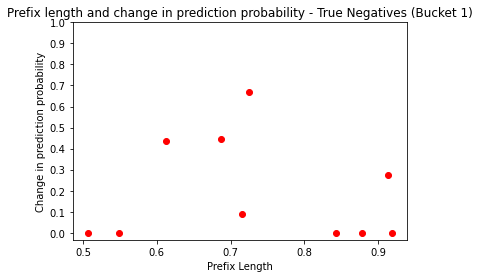

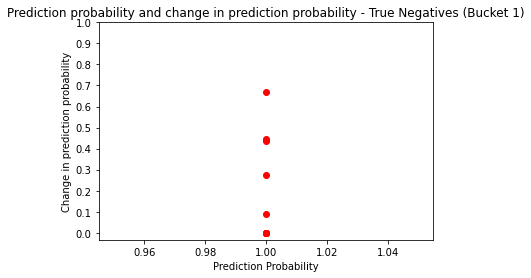

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 4 of 10
Creating explanations
Identifying relevant

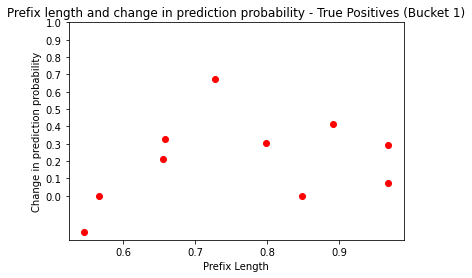

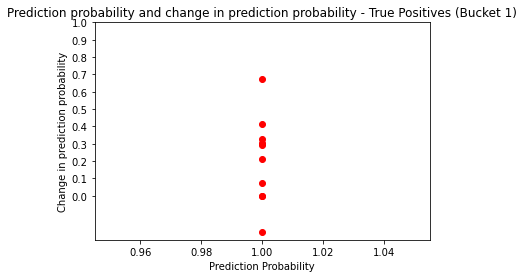

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 4 of 10
Creating explanations
Identifying relevant

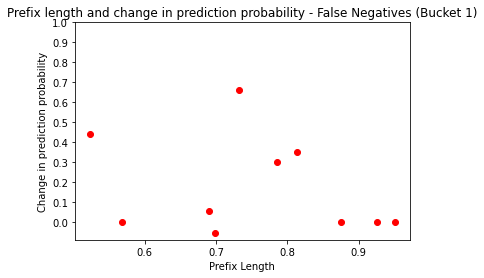

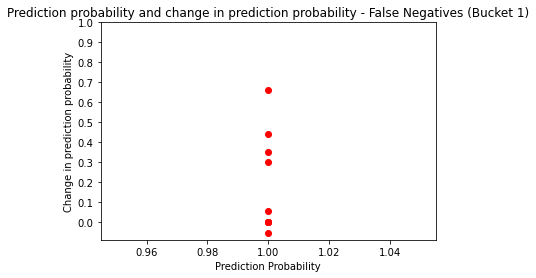

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 4 of 10
Creating explanations
Identifying relevant

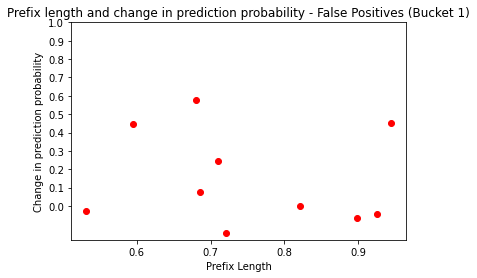

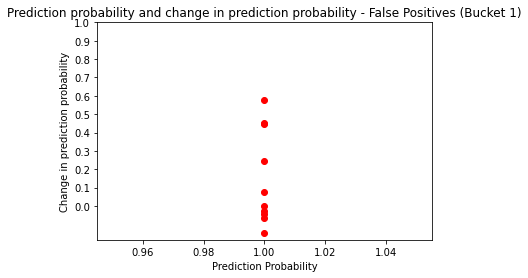

Bucket 2
Generating distributions for bucket
1 of 21 features
2 of 21 features
3 of 21 features
4 of 21 features
5 of 21 features
6 of 21 features
7 of 21 features
8 of 21 features
9 of 21 features
10 of 21 features
11 of 21 features
12 of 21 features
13 of 21 features
14 of 21 features
15 of 21 features
16 of 21 features
17 of 21 features
18 of 21 features
19 of 21 features
20 of 21 features
21 of 21 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run

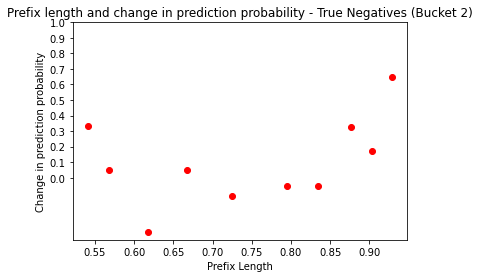

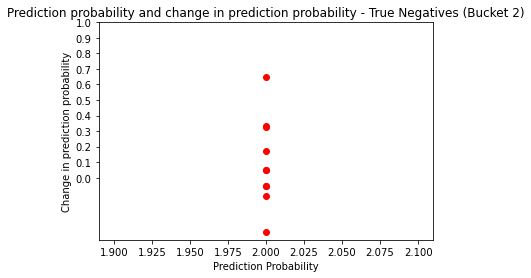

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubin

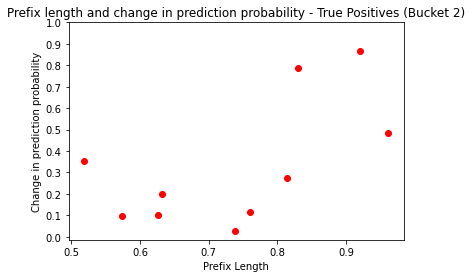

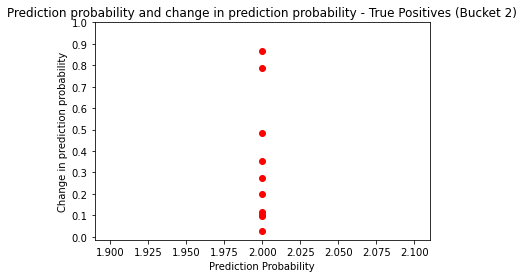

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubin

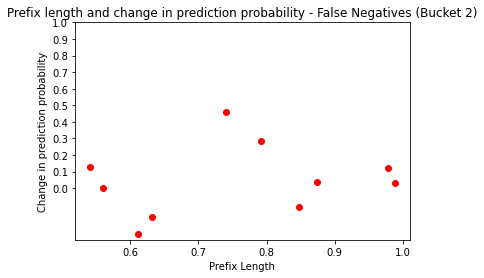

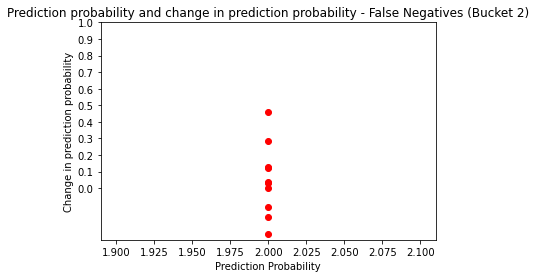

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 2
Creating distribution for feature 2 of 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubin

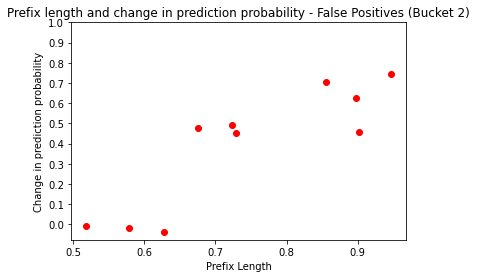

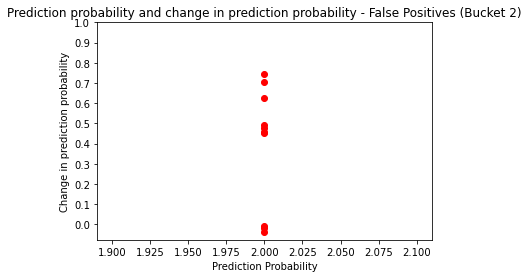

Bucket 3
Generating distributions for bucket
1 of 33 features
2 of 33 features
3 of 33 features
4 of 33 features
5 of 33 features
6 of 33 features
7 of 33 features
8 of 33 features
9 of 33 features
10 of 33 features
11 of 33 features
12 of 33 features
13 of 33 features
14 of 33 features
15 of 33 features
16 of 33 features
17 of 33 features
18 of 33 features
19 of 33 features
20 of 33 features
21 of 33 features
22 of 33 features
23 of 33 features
24 of 33 features
25 of 33 features
26 of 33 features
27 of 33 features
28 of 33 features
29 of 33 features
30 of 33 features
31 of 33 features
32 of 33 features
33 of 33 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9

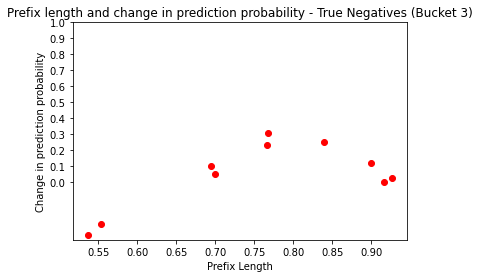

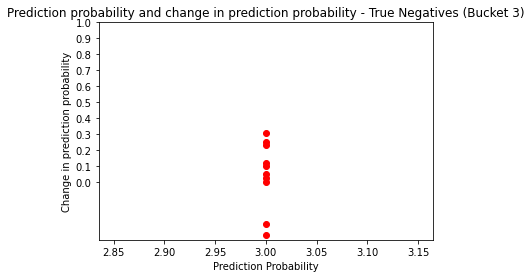

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing -

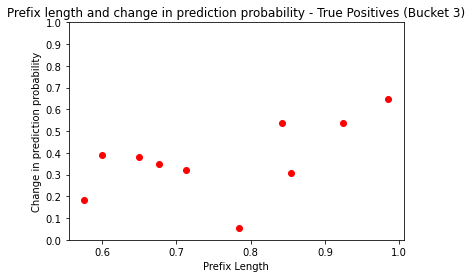

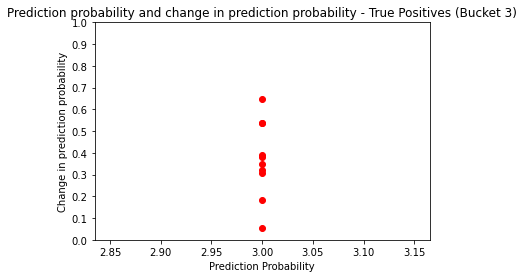

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing -

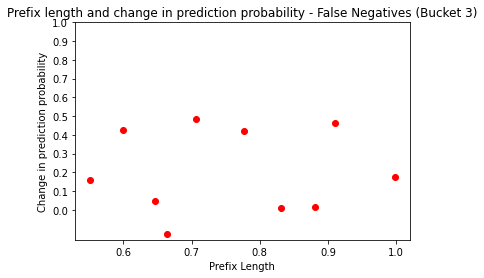

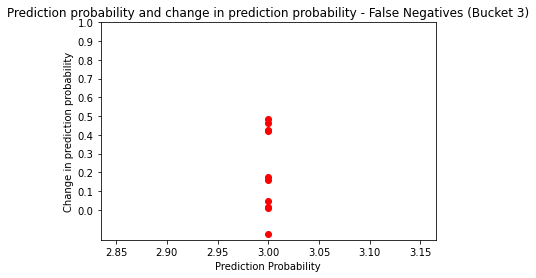

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 3
Creating distribution for feature 2 of 3
Creating distribution for feature 3 of 3
Pertubing -

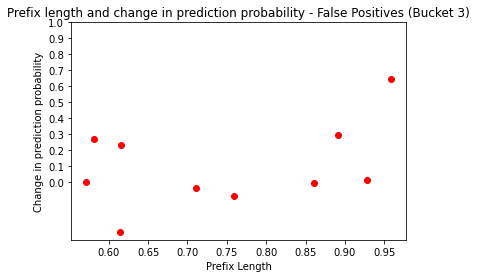

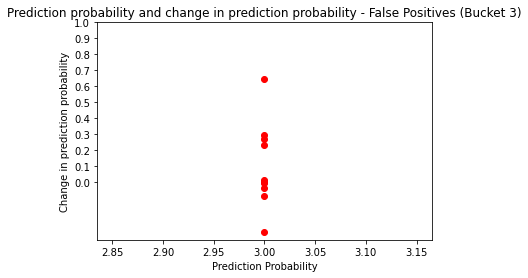

Bucket 4
Generating distributions for bucket
1 of 85 features
2 of 85 features
3 of 85 features
4 of 85 features
5 of 85 features
6 of 85 features
7 of 85 features
8 of 85 features
9 of 85 features
10 of 85 features
11 of 85 features
12 of 85 features
13 of 85 features
14 of 85 features
15 of 85 features
16 of 85 features
17 of 85 features
18 of 85 features
19 of 85 features
20 of 85 features
21 of 85 features
22 of 85 features
23 of 85 features
24 of 85 features
25 of 85 features
26 of 85 features
27 of 85 features
28 of 85 features
29 of 85 features
30 of 85 features
31 of 85 features
32 of 85 features
33 of 85 features
34 of 85 features
35 of 85 features
36 of 85 features
37 of 85 features
38 of 85 features
39 of 85 features
40 of 85 features
41 of 85 features
42 of 85 features
43 of 85 features
44 of 85 features
45 of 85 features
46 of 85 features
47 of 85 features
48 of 85 features
49 of 85 features
50 of 85 features
51 of 85 features
52 of 85 features
53 of 85 features
54 of 85 f

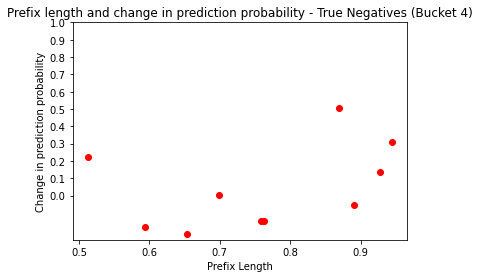

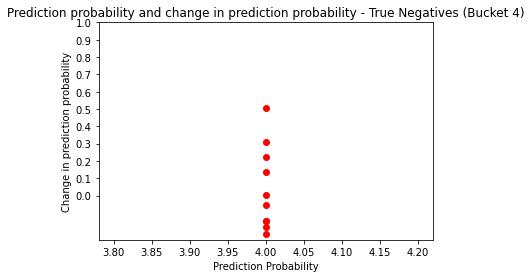

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for feature 8 of 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for featur

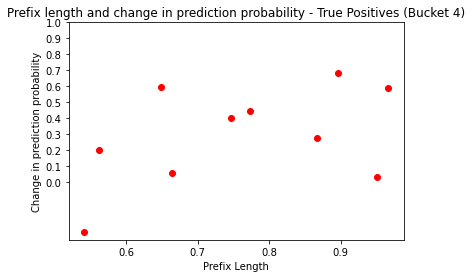

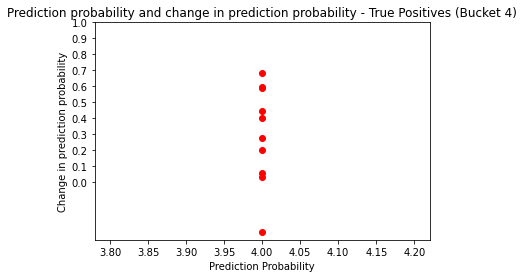

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for feature 8 of 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for featur

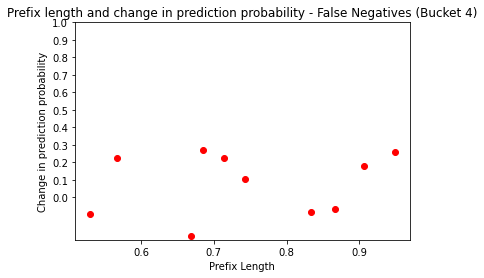

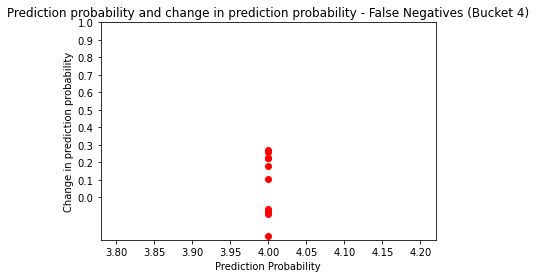

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for feature 8 of 8
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 8
Creating distribution for feature 2 of 8
Creating distribution for feature 3 of 8
Creating distribution for feature 4 of 8
Creating distribution for feature 5 of 8
Creating distribution for feature 6 of 8
Creating distribution for feature 7 of 8
Creating distribution for featur

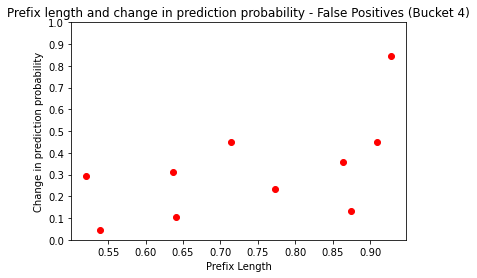

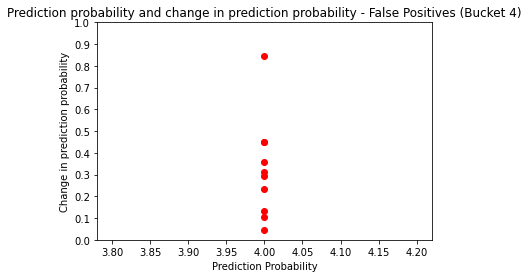

Bucket 5
Generating distributions for bucket
1 of 149 features
2 of 149 features
3 of 149 features
4 of 149 features
5 of 149 features
6 of 149 features
7 of 149 features
8 of 149 features
9 of 149 features
10 of 149 features
11 of 149 features
12 of 149 features
13 of 149 features
14 of 149 features
15 of 149 features
16 of 149 features
17 of 149 features
18 of 149 features
19 of 149 features
20 of 149 features
21 of 149 features
22 of 149 features
23 of 149 features
24 of 149 features
25 of 149 features
26 of 149 features
27 of 149 features
28 of 149 features
29 of 149 features
30 of 149 features
31 of 149 features
32 of 149 features
33 of 149 features
34 of 149 features
35 of 149 features
36 of 149 features
37 of 149 features
38 of 149 features
39 of 149 features
40 of 149 features
41 of 149 features
42 of 149 features
43 of 149 features
44 of 149 features
45 of 149 features
46 of 149 features
47 of 149 features
48 of 149 features
49 of 149 features
50 of 149 features
51 of 149 feat

Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubi

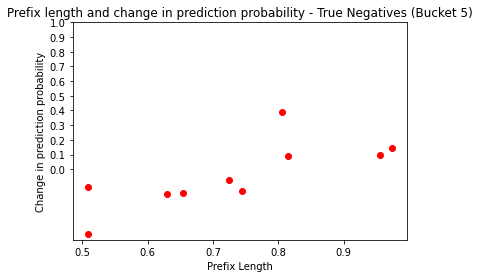

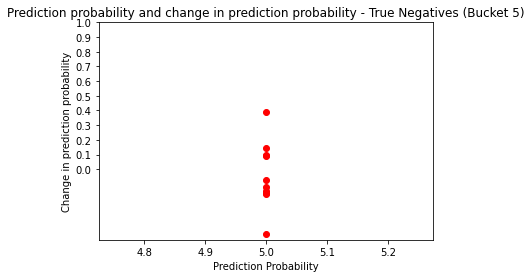

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating di

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


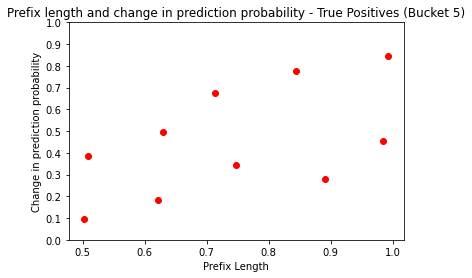

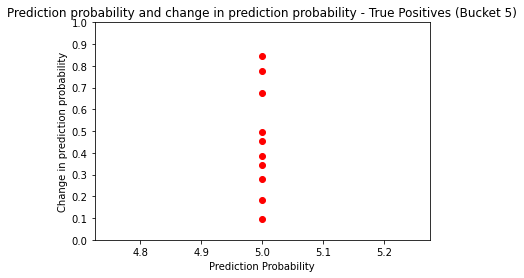

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating di

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


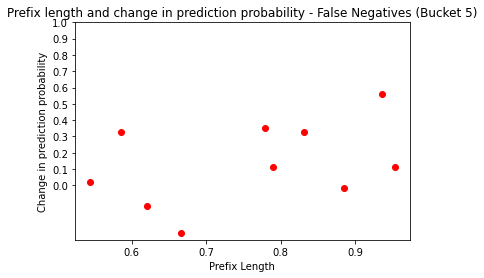

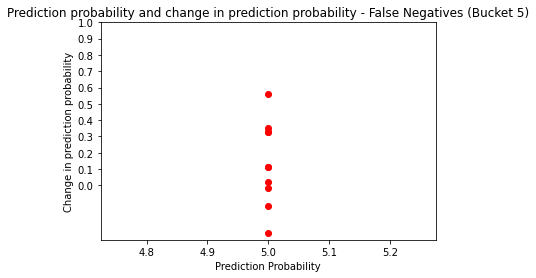

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 15
Creating distribution for feature 2 of 15
Creating distribution for feature 3 of 15
Creating distribution for feature 4 of 15
Creating distribution for feature 5 of 15
Creating distribution for feature 6 of 15
Creating distribution for feature 7 of 15
Creating distribution for feature 8 of 15
Creating distribution for feature 9 of 15
Creating distribution for feature 10 of 15
Creating distribution for feature 11 of 15
Creating distribution for feature 12 of 15
Creating distribution for feature 13 of 15
Creating distribution for feature 14 of 15
Creating distribution for feature 15 of 15
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating di

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


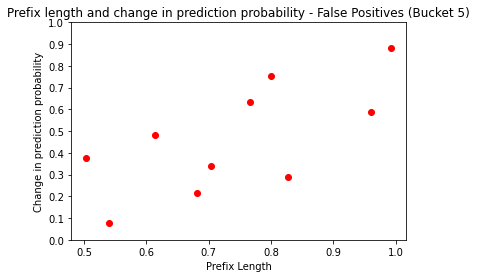

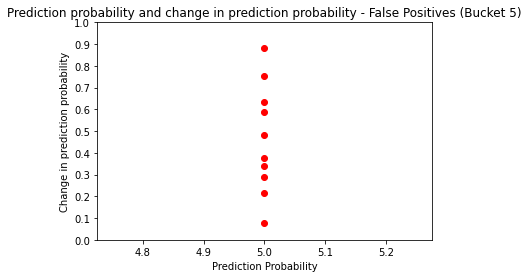

Bucket 6
Generating distributions for bucket
1 of 212 features
2 of 212 features
3 of 212 features
4 of 212 features
5 of 212 features
6 of 212 features
7 of 212 features
8 of 212 features
9 of 212 features
10 of 212 features
11 of 212 features
12 of 212 features
13 of 212 features
14 of 212 features
15 of 212 features
16 of 212 features
17 of 212 features
18 of 212 features
19 of 212 features
20 of 212 features
21 of 212 features
22 of 212 features
23 of 212 features
24 of 212 features
25 of 212 features
26 of 212 features
27 of 212 features
28 of 212 features
29 of 212 features
30 of 212 features
31 of 212 features
32 of 212 features
33 of 212 features
34 of 212 features
35 of 212 features
36 of 212 features
37 of 212 features
38 of 212 features
39 of 212 features
40 of 212 features
41 of 212 features
42 of 212 features
43 of 212 features
44 of 212 features
45 of 212 features
46 of 212 features
47 of 212 features
48 of 212 features
49 of 212 features
50 of 212 features
51 of 212 feat

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 5 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Crea

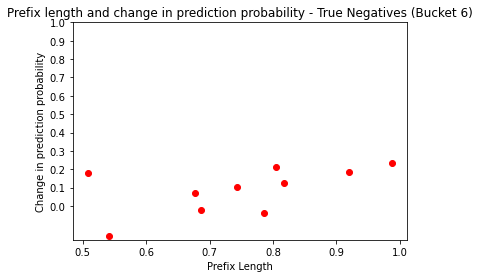

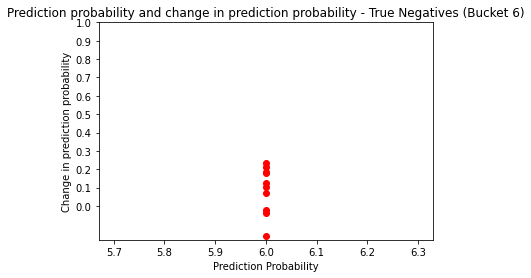

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Crea

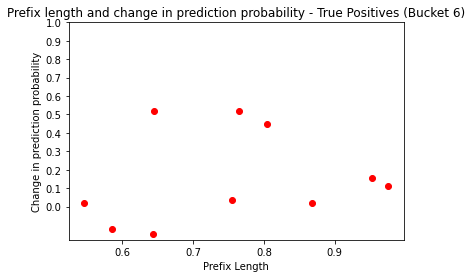

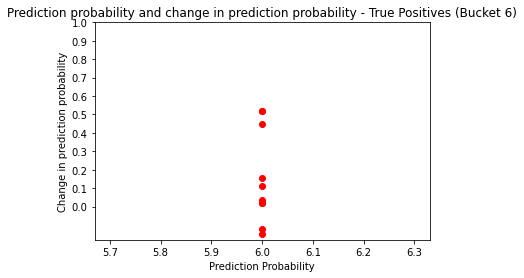

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Crea

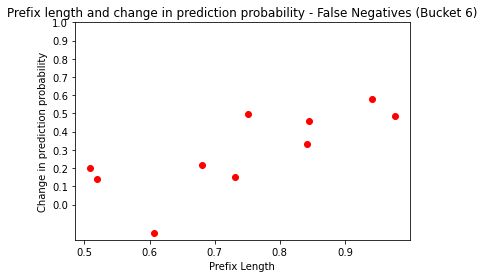

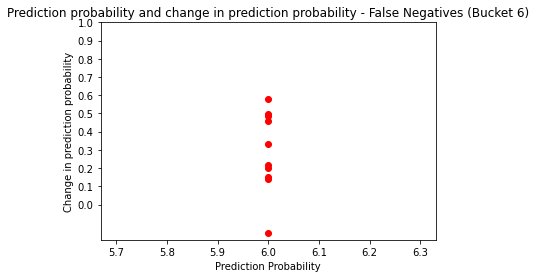

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Creating distribution for feature 19 of 21
Creating distribution for feature 20 of 21
Creating distribution for feature 21 of 21
Pertubing - Run 1
Pe

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 21
Creating distribution for feature 2 of 21
Creating distribution for feature 3 of 21
Creating distribution for feature 4 of 21
Creating distribution for feature 5 of 21
Creating distribution for feature 6 of 21
Creating distribution for feature 7 of 21
Creating distribution for feature 8 of 21
Creating distribution for feature 9 of 21
Creating distribution for feature 10 of 21
Creating distribution for feature 11 of 21
Creating distribution for feature 12 of 21
Creating distribution for feature 13 of 21
Creating distribution for feature 14 of 21
Creating distribution for feature 15 of 21
Creating distribution for feature 16 of 21
Creating distribution for feature 17 of 21
Creating distribution for feature 18 of 21
Crea

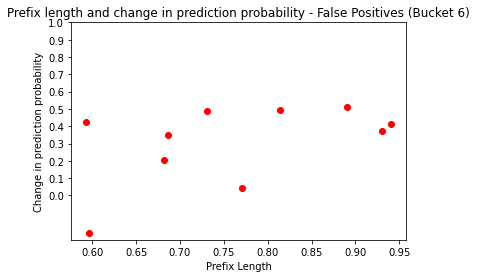

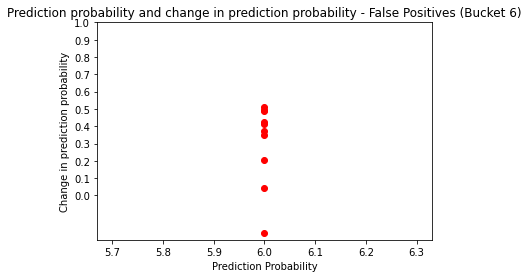

Bucket 7
Generating distributions for bucket
1 of 278 features
2 of 278 features
3 of 278 features
4 of 278 features
5 of 278 features
6 of 278 features
7 of 278 features
8 of 278 features
9 of 278 features
10 of 278 features
11 of 278 features
12 of 278 features
13 of 278 features
14 of 278 features
15 of 278 features
16 of 278 features
17 of 278 features
18 of 278 features
19 of 278 features
20 of 278 features
21 of 278 features
22 of 278 features
23 of 278 features
24 of 278 features
25 of 278 features
26 of 278 features
27 of 278 features
28 of 278 features
29 of 278 features
30 of 278 features
31 of 278 features
32 of 278 features
33 of 278 features
34 of 278 features
35 of 278 features
36 of 278 features
37 of 278 features
38 of 278 features
39 of 278 features
40 of 278 features
41 of 278 features
42 of 278 features
43 of 278 features
44 of 278 features
45 of 278 features
46 of 278 features
47 of 278 features
48 of 278 features
49 of 278 features
50 of 278 features
51 of 278 feat

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Crea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 9 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Crea

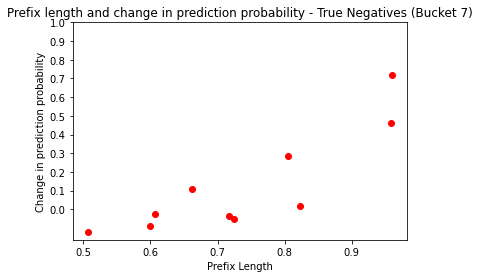

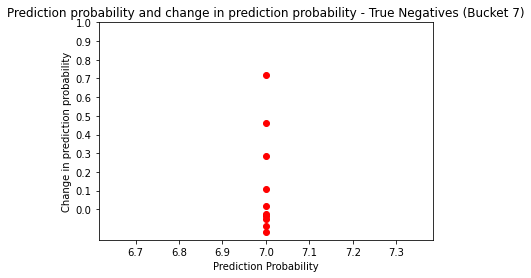

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Creating distribution for feature 19 of 28
Creating distribution for feature 20 of 28
Creating distribution for feature 21 of 28
Creating distributio

Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 7 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for fea

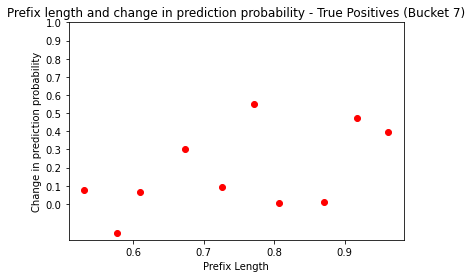

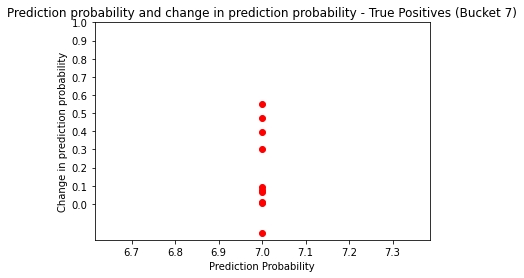

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Creating distribution for feature 19 of 28
Creating distribution for feature 20 of 28
Creating distribution for feature 21 of 28
Creating distributio

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 7 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Crea

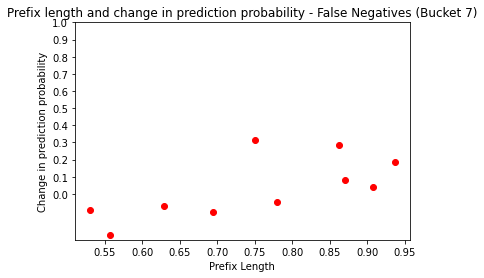

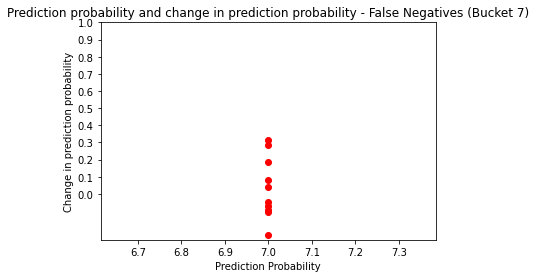

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Creating distribution for feature 19 of 28
Creating distribution for feature 20 of 28
Creating distribution for feature 21 of 28
Creating distributio

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 7 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 28
Creating distribution for feature 2 of 28
Creating distribution for feature 3 of 28
Creating distribution for feature 4 of 28
Creating distribution for feature 5 of 28
Creating distribution for feature 6 of 28
Creating distribution for feature 7 of 28
Creating distribution for feature 8 of 28
Creating distribution for feature 9 of 28
Creating distribution for feature 10 of 28
Creating distribution for feature 11 of 28
Creating distribution for feature 12 of 28
Creating distribution for feature 13 of 28
Creating distribution for feature 14 of 28
Creating distribution for feature 15 of 28
Creating distribution for feature 16 of 28
Creating distribution for feature 17 of 28
Creating distribution for feature 18 of 28
Crea

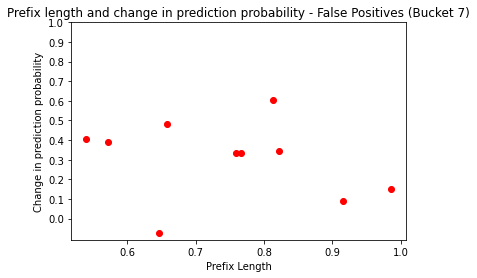

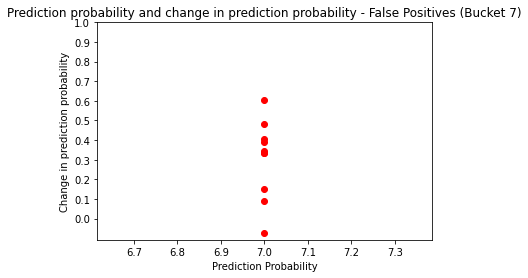

Bucket 8
Generating distributions for bucket
1 of 345 features
2 of 345 features
3 of 345 features
4 of 345 features
5 of 345 features
6 of 345 features
7 of 345 features
8 of 345 features
9 of 345 features
10 of 345 features
11 of 345 features
12 of 345 features
13 of 345 features
14 of 345 features
15 of 345 features
16 of 345 features
17 of 345 features
18 of 345 features
19 of 345 features
20 of 345 features
21 of 345 features
22 of 345 features
23 of 345 features
24 of 345 features
25 of 345 features
26 of 345 features
27 of 345 features
28 of 345 features
29 of 345 features
30 of 345 features
31 of 345 features
32 of 345 features
33 of 345 features
34 of 345 features
35 of 345 features
36 of 345 features
37 of 345 features
38 of 345 features
39 of 345 features
40 of 345 features
41 of 345 features
42 of 345 features
43 of 345 features
44 of 345 features
45 of 345 features
46 of 345 features
47 of 345 features
48 of 345 features
49 of 345 features
50 of 345 features
51 of 345 feat

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Crea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 7 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Crea

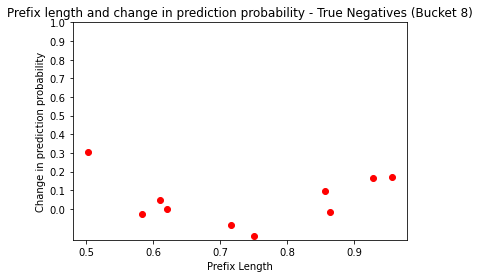

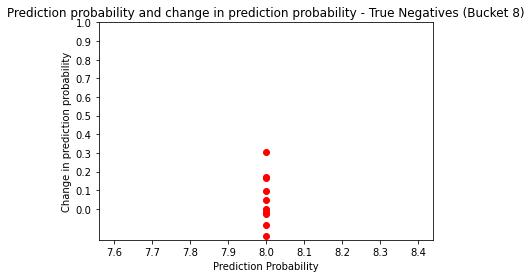

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Creating distribution for feature 19 of 34
Creating distribution for feature 20 of 34
Creating distribution for feature 21 of 34
Creating distributio

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 6 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Crea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


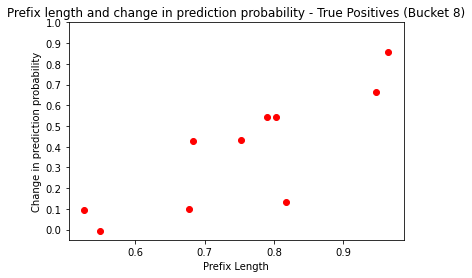

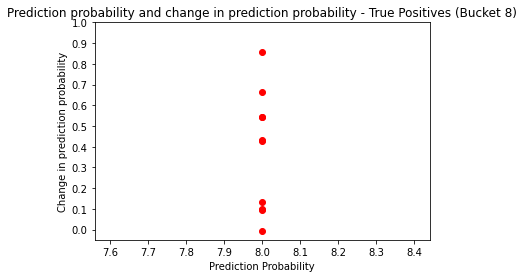

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Creating distribution for feature 19 of 34
Creating distribution for feature 20 of 34
Creating distribution for feature 21 of 34
Creating distributio

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 6 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Crea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


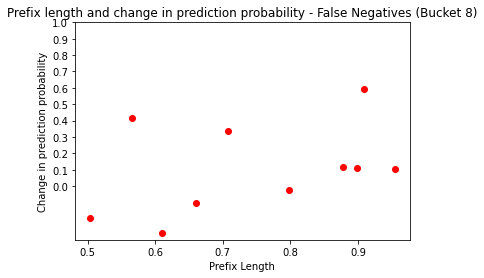

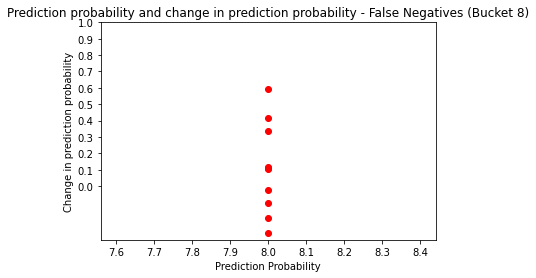

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for feature 18 of 34
Creating distribution for feature 19 of 34
Creating distribution for feature 20 of 34
Creating distribution for feature 21 of 34
Creating distributio

Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 6 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 34
Creating distribution for feature 2 of 34
Creating distribution for feature 3 of 34
Creating distribution for feature 4 of 34
Creating distribution for feature 5 of 34
Creating distribution for feature 6 of 34
Creating distribution for feature 7 of 34
Creating distribution for feature 8 of 34
Creating distribution for feature 9 of 34
Creating distribution for feature 10 of 34
Creating distribution for feature 11 of 34
Creating distribution for feature 12 of 34
Creating distribution for feature 13 of 34
Creating distribution for feature 14 of 34
Creating distribution for feature 15 of 34
Creating distribution for feature 16 of 34
Creating distribution for feature 17 of 34
Creating distribution for fea

Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


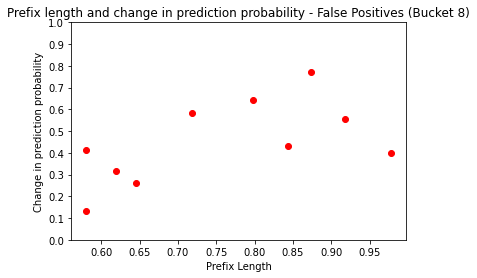

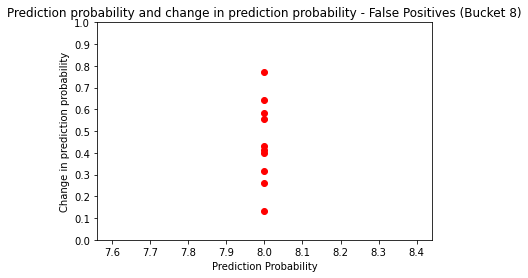

Bucket 9
Generating distributions for bucket
1 of 411 features
2 of 411 features
3 of 411 features
4 of 411 features
5 of 411 features
6 of 411 features
7 of 411 features
8 of 411 features
9 of 411 features
10 of 411 features
11 of 411 features
12 of 411 features
13 of 411 features
14 of 411 features
15 of 411 features
16 of 411 features
17 of 411 features
18 of 411 features
19 of 411 features
20 of 411 features
21 of 411 features
22 of 411 features
23 of 411 features
24 of 411 features
25 of 411 features
26 of 411 features
27 of 411 features
28 of 411 features
29 of 411 features
30 of 411 features
31 of 411 features
32 of 411 features
33 of 411 features
34 of 411 features
35 of 411 features
36 of 411 features
37 of 411 features
38 of 411 features
39 of 411 features
40 of 411 features
41 of 411 features
42 of 411 features
43 of 411 features
44 of 411 features
45 of 411 features
46 of 411 features
47 of 411 features
48 of 411 features
49 of 411 features
50 of 411 features
51 of 411 feat

Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distribution for feature 22 of 41
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distribution for feature 22 of 41
Creating di

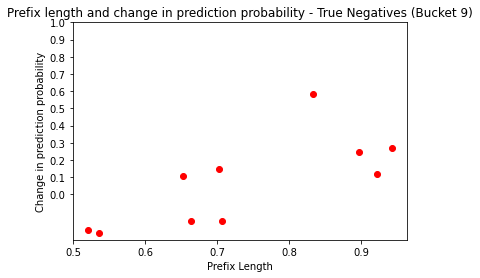

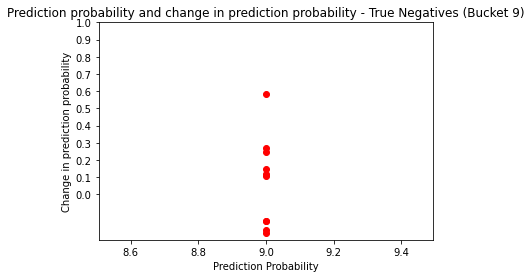

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distribution for feature 22 of 41
Creating di

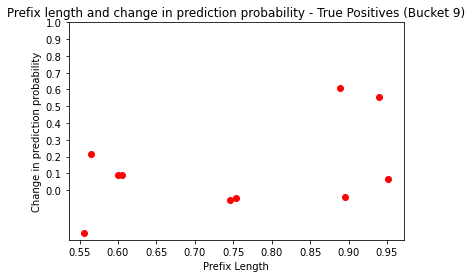

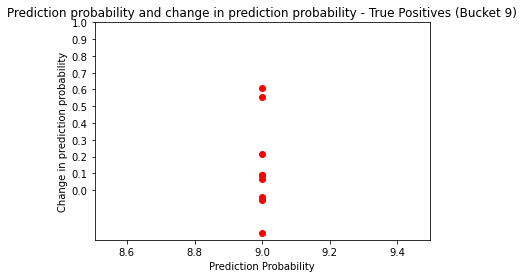

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distribution for feature 22 of 41
Creating di

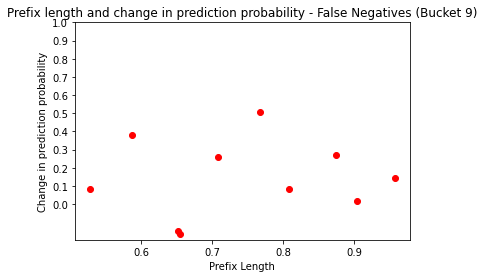

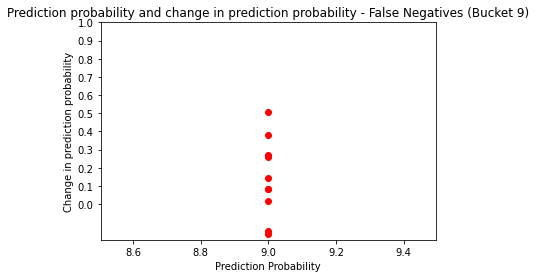

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 41
Creating distribution for feature 2 of 41
Creating distribution for feature 3 of 41
Creating distribution for feature 4 of 41
Creating distribution for feature 5 of 41
Creating distribution for feature 6 of 41
Creating distribution for feature 7 of 41
Creating distribution for feature 8 of 41
Creating distribution for feature 9 of 41
Creating distribution for feature 10 of 41
Creating distribution for feature 11 of 41
Creating distribution for feature 12 of 41
Creating distribution for feature 13 of 41
Creating distribution for feature 14 of 41
Creating distribution for feature 15 of 41
Creating distribution for feature 16 of 41
Creating distribution for feature 17 of 41
Creating distribution for feature 18 of 41
Creating distribution for feature 19 of 41
Creating distribution for feature 20 of 41
Creating distribution for feature 21 of 41
Creating distribution for feature 22 of 41
Creating di

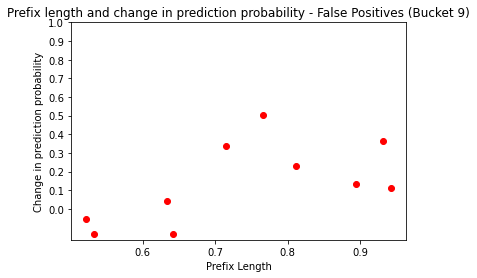

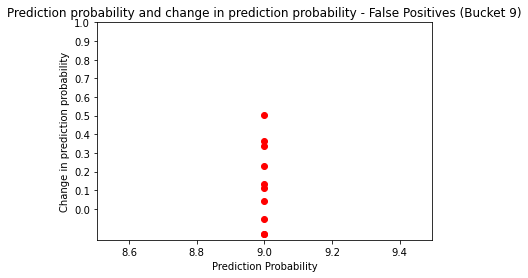

Bucket 10
Generating distributions for bucket
1 of 478 features
2 of 478 features
3 of 478 features
4 of 478 features
5 of 478 features
6 of 478 features
7 of 478 features
8 of 478 features
9 of 478 features
10 of 478 features
11 of 478 features
12 of 478 features
13 of 478 features
14 of 478 features
15 of 478 features
16 of 478 features
17 of 478 features
18 of 478 features
19 of 478 features
20 of 478 features
21 of 478 features
22 of 478 features
23 of 478 features
24 of 478 features
25 of 478 features
26 of 478 features
27 of 478 features
28 of 478 features
29 of 478 features
30 of 478 features
31 of 478 features
32 of 478 features
33 of 478 features
34 of 478 features
35 of 478 features
36 of 478 features
37 of 478 features
38 of 478 features
39 of 478 features
40 of 478 features
41 of 478 features
42 of 478 features
43 of 478 features
44 of 478 features
45 of 478 features
46 of 478 features
47 of 478 features
48 of 478 features
49 of 478 features
50 of 478 features
51 of 478 fea

416 of 478 features
417 of 478 features
418 of 478 features
419 of 478 features
420 of 478 features
421 of 478 features
422 of 478 features
423 of 478 features
424 of 478 features
425 of 478 features
426 of 478 features
427 of 478 features
428 of 478 features
429 of 478 features
430 of 478 features
431 of 478 features
432 of 478 features
433 of 478 features
434 of 478 features
435 of 478 features
436 of 478 features
437 of 478 features
438 of 478 features
439 of 478 features
440 of 478 features
441 of 478 features
442 of 478 features
443 of 478 features
444 of 478 features
445 of 478 features
446 of 478 features
447 of 478 features
448 of 478 features
449 of 478 features
450 of 478 features
451 of 478 features
452 of 478 features
453 of 478 features
454 of 478 features
455 of 478 features
456 of 478 features
457 of 478 features
458 of 478 features
459 of 478 features
460 of 478 features
461 of 478 features
462 of 478 features
463 of 478 features
464 of 478 features
465 of 478 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

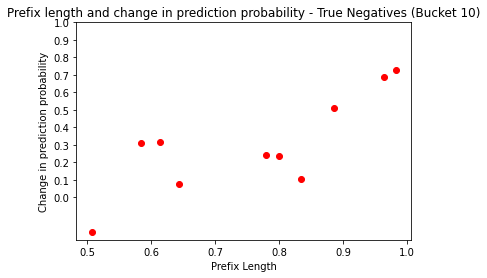

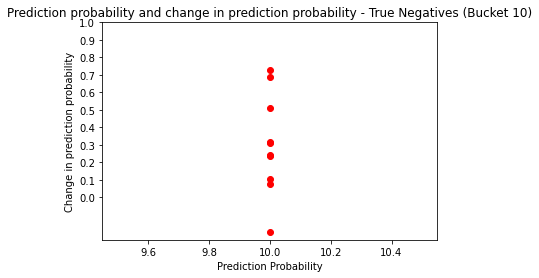

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

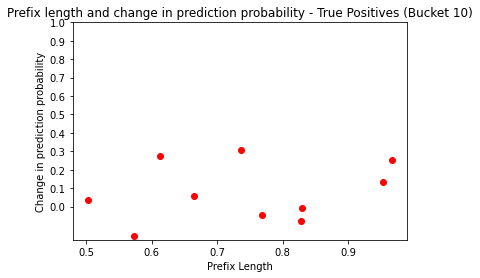

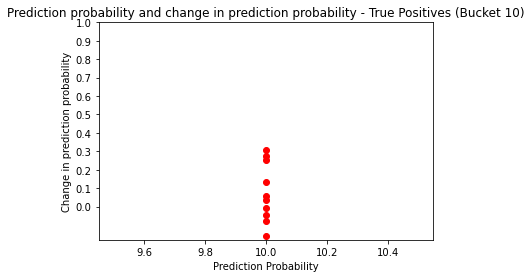

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

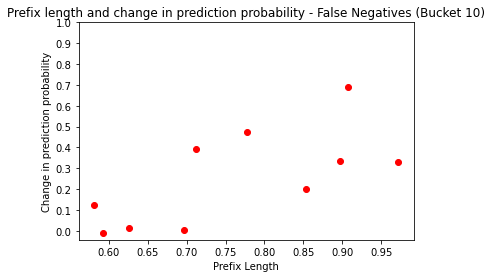

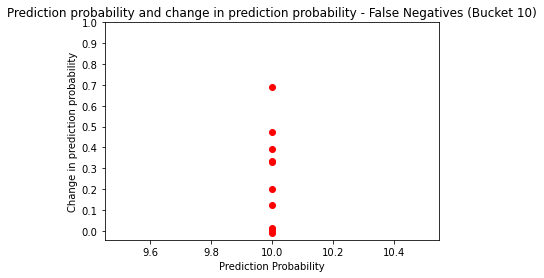

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 48
Creating distribution for feature 2 of 48
Creating distribution for feature 3 of 48
Creating distribution for feature 4 of 48
Creating distribution for feature 5 of 48
Creating distribution for feature 6 of 48
Creating distribution for feature 7 of 48
Creating distribution for feature 8 of 48
Creating distribution for feature 9 of 48
Creating distribution for feature 10 of 48
Creating distribution for feature 11 of 48
Creating distribution for feature 12 of 48
Creating distribution for feature 13 of 48
Creating distribution for feature 14 of 48
Creating distribution for feature 15 of 48
Creating distribution for feature 16 of 48
Creating distribution for feature 17 of 48
Creating distribution for feature 18 of 48
Creating distribution for feature 19 of 48
Creating distribution for feature 20 of 48
Creating distribution for feature 21 of 48
Creating distribution for feature 22 of 48
Creating di

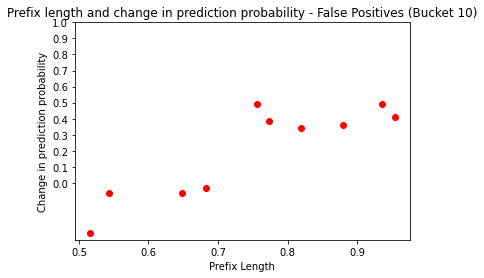

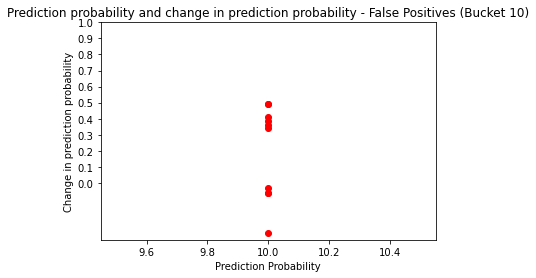

Bucket 11
Generating distributions for bucket
1 of 545 features
2 of 545 features
3 of 545 features
4 of 545 features
5 of 545 features
6 of 545 features
7 of 545 features
8 of 545 features
9 of 545 features
10 of 545 features
11 of 545 features
12 of 545 features
13 of 545 features
14 of 545 features
15 of 545 features
16 of 545 features
17 of 545 features
18 of 545 features
19 of 545 features
20 of 545 features
21 of 545 features
22 of 545 features
23 of 545 features
24 of 545 features
25 of 545 features
26 of 545 features
27 of 545 features
28 of 545 features
29 of 545 features
30 of 545 features
31 of 545 features
32 of 545 features
33 of 545 features
34 of 545 features
35 of 545 features
36 of 545 features
37 of 545 features
38 of 545 features
39 of 545 features
40 of 545 features
41 of 545 features
42 of 545 features
43 of 545 features
44 of 545 features
45 of 545 features
46 of 545 features
47 of 545 features
48 of 545 features
49 of 545 features
50 of 545 features
51 of 545 fea

416 of 545 features
417 of 545 features
418 of 545 features
419 of 545 features
420 of 545 features
421 of 545 features
422 of 545 features
423 of 545 features
424 of 545 features
425 of 545 features
426 of 545 features
427 of 545 features
428 of 545 features
429 of 545 features
430 of 545 features
431 of 545 features
432 of 545 features
433 of 545 features
434 of 545 features
435 of 545 features
436 of 545 features
437 of 545 features
438 of 545 features
439 of 545 features
440 of 545 features
441 of 545 features
442 of 545 features
443 of 545 features
444 of 545 features
445 of 545 features
446 of 545 features
447 of 545 features
448 of 545 features
449 of 545 features
450 of 545 features
451 of 545 features
452 of 545 features
453 of 545 features
454 of 545 features
455 of 545 features
456 of 545 features
457 of 545 features
458 of 545 features
459 of 545 features
460 of 545 features
461 of 545 features
462 of 545 features
463 of 545 features
464 of 545 features
465 of 545 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

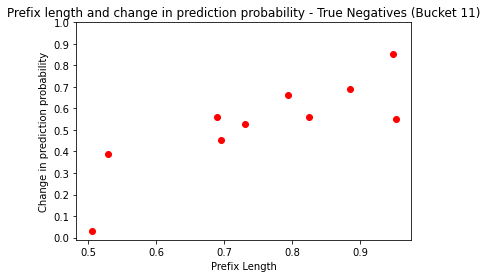

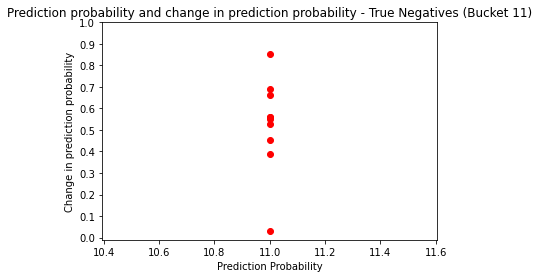

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

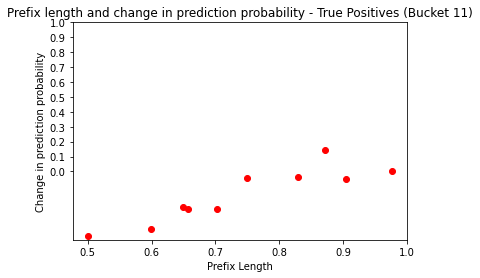

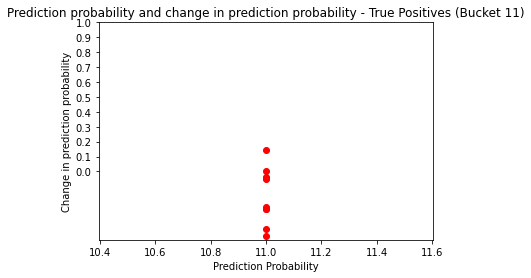

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

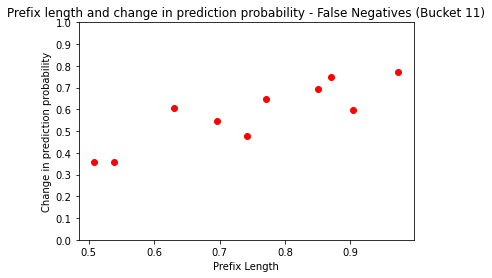

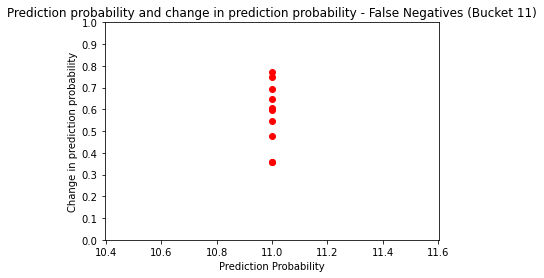

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 54
Creating distribution for feature 2 of 54
Creating distribution for feature 3 of 54
Creating distribution for feature 4 of 54
Creating distribution for feature 5 of 54
Creating distribution for feature 6 of 54
Creating distribution for feature 7 of 54
Creating distribution for feature 8 of 54
Creating distribution for feature 9 of 54
Creating distribution for feature 10 of 54
Creating distribution for feature 11 of 54
Creating distribution for feature 12 of 54
Creating distribution for feature 13 of 54
Creating distribution for feature 14 of 54
Creating distribution for feature 15 of 54
Creating distribution for feature 16 of 54
Creating distribution for feature 17 of 54
Creating distribution for feature 18 of 54
Creating distribution for feature 19 of 54
Creating distribution for feature 20 of 54
Creating distribution for feature 21 of 54
Creating distribution for feature 22 of 54
Creating di

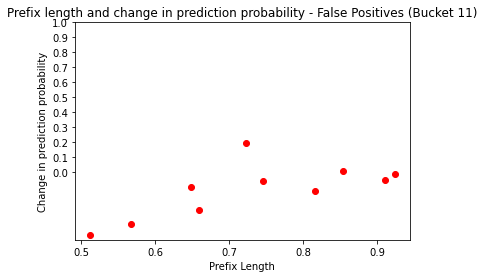

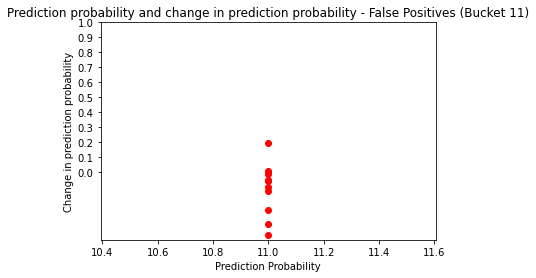

Bucket 12
Generating distributions for bucket
1 of 614 features
2 of 614 features
3 of 614 features
4 of 614 features
5 of 614 features
6 of 614 features
7 of 614 features
8 of 614 features
9 of 614 features
10 of 614 features
11 of 614 features
12 of 614 features
13 of 614 features
14 of 614 features
15 of 614 features
16 of 614 features
17 of 614 features
18 of 614 features
19 of 614 features
20 of 614 features
21 of 614 features
22 of 614 features
23 of 614 features
24 of 614 features
25 of 614 features
26 of 614 features
27 of 614 features
28 of 614 features
29 of 614 features
30 of 614 features
31 of 614 features
32 of 614 features
33 of 614 features
34 of 614 features
35 of 614 features
36 of 614 features
37 of 614 features
38 of 614 features
39 of 614 features
40 of 614 features
41 of 614 features
42 of 614 features
43 of 614 features
44 of 614 features
45 of 614 features
46 of 614 features
47 of 614 features
48 of 614 features
49 of 614 features
50 of 614 features
51 of 614 fea

416 of 614 features
417 of 614 features
418 of 614 features
419 of 614 features
420 of 614 features
421 of 614 features
422 of 614 features
423 of 614 features
424 of 614 features
425 of 614 features
426 of 614 features
427 of 614 features
428 of 614 features
429 of 614 features
430 of 614 features
431 of 614 features
432 of 614 features
433 of 614 features
434 of 614 features
435 of 614 features
436 of 614 features
437 of 614 features
438 of 614 features
439 of 614 features
440 of 614 features
441 of 614 features
442 of 614 features
443 of 614 features
444 of 614 features
445 of 614 features
446 of 614 features
447 of 614 features
448 of 614 features
449 of 614 features
450 of 614 features
451 of 614 features
452 of 614 features
453 of 614 features
454 of 614 features
455 of 614 features
456 of 614 features
457 of 614 features
458 of 614 features
459 of 614 features
460 of 614 features
461 of 614 features
462 of 614 features
463 of 614 features
464 of 614 features
465 of 614 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

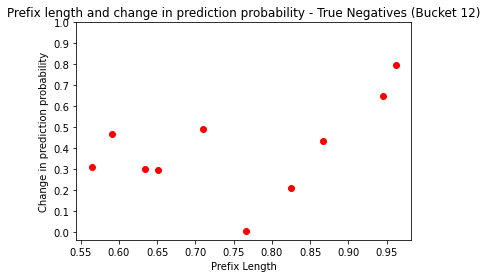

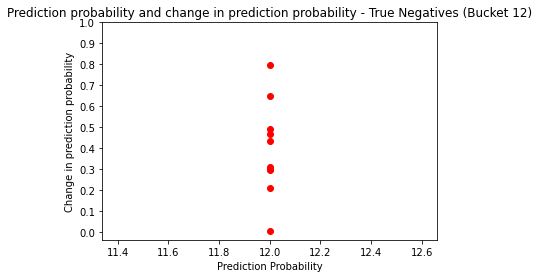

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

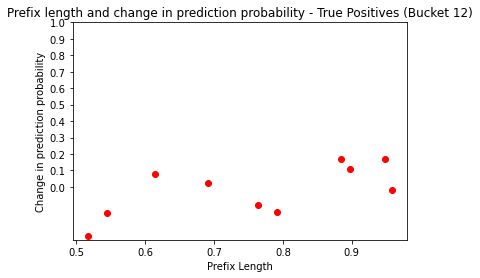

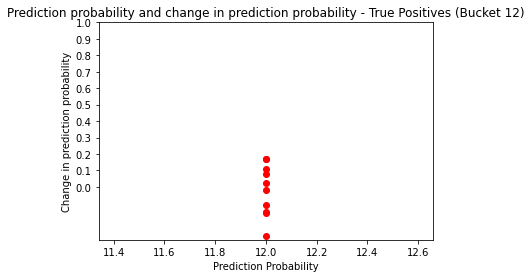

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

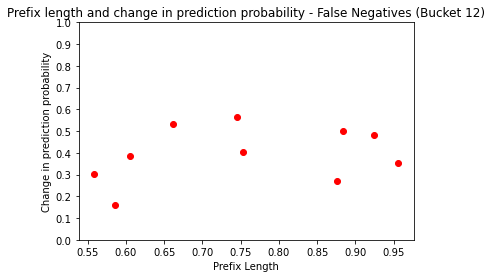

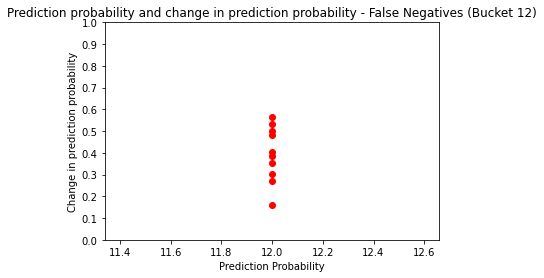

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 61
Creating distribution for feature 2 of 61
Creating distribution for feature 3 of 61
Creating distribution for feature 4 of 61
Creating distribution for feature 5 of 61
Creating distribution for feature 6 of 61
Creating distribution for feature 7 of 61
Creating distribution for feature 8 of 61
Creating distribution for feature 9 of 61
Creating distribution for feature 10 of 61
Creating distribution for feature 11 of 61
Creating distribution for feature 12 of 61
Creating distribution for feature 13 of 61
Creating distribution for feature 14 of 61
Creating distribution for feature 15 of 61
Creating distribution for feature 16 of 61
Creating distribution for feature 17 of 61
Creating distribution for feature 18 of 61
Creating distribution for feature 19 of 61
Creating distribution for feature 20 of 61
Creating distribution for feature 21 of 61
Creating distribution for feature 22 of 61
Creating di

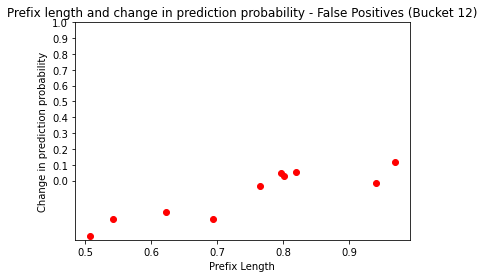

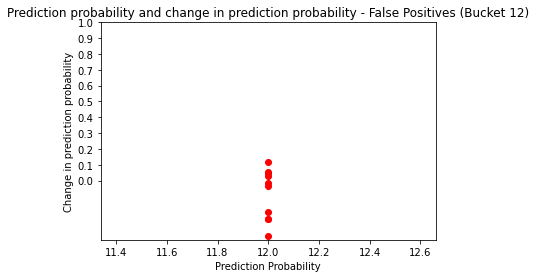

Bucket 13
Generating distributions for bucket
1 of 690 features
2 of 690 features
3 of 690 features
4 of 690 features
5 of 690 features
6 of 690 features
7 of 690 features
8 of 690 features
9 of 690 features
10 of 690 features
11 of 690 features
12 of 690 features
13 of 690 features
14 of 690 features
15 of 690 features
16 of 690 features
17 of 690 features
18 of 690 features
19 of 690 features
20 of 690 features
21 of 690 features
22 of 690 features
23 of 690 features
24 of 690 features
25 of 690 features
26 of 690 features
27 of 690 features
28 of 690 features
29 of 690 features
30 of 690 features
31 of 690 features
32 of 690 features
33 of 690 features
34 of 690 features
35 of 690 features
36 of 690 features
37 of 690 features
38 of 690 features
39 of 690 features
40 of 690 features
41 of 690 features
42 of 690 features
43 of 690 features
44 of 690 features
45 of 690 features
46 of 690 features
47 of 690 features
48 of 690 features
49 of 690 features
50 of 690 features
51 of 690 fea

415 of 690 features
416 of 690 features
417 of 690 features
418 of 690 features
419 of 690 features
420 of 690 features
421 of 690 features
422 of 690 features
423 of 690 features
424 of 690 features
425 of 690 features
426 of 690 features
427 of 690 features
428 of 690 features
429 of 690 features
430 of 690 features
431 of 690 features
432 of 690 features
433 of 690 features
434 of 690 features
435 of 690 features
436 of 690 features
437 of 690 features
438 of 690 features
439 of 690 features
440 of 690 features
441 of 690 features
442 of 690 features
443 of 690 features
444 of 690 features
445 of 690 features
446 of 690 features
447 of 690 features
448 of 690 features
449 of 690 features
450 of 690 features
451 of 690 features
452 of 690 features
453 of 690 features
454 of 690 features
455 of 690 features
456 of 690 features
457 of 690 features
458 of 690 features
459 of 690 features
460 of 690 features
461 of 690 features
462 of 690 features
463 of 690 features
464 of 690 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

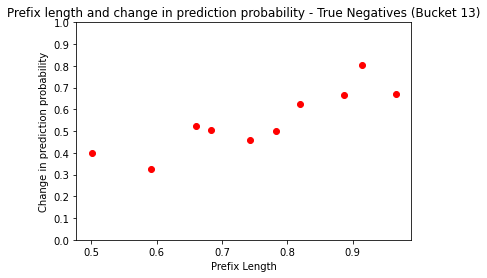

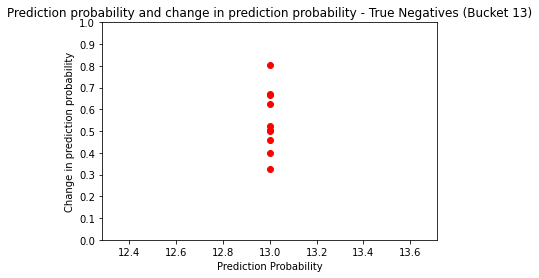

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

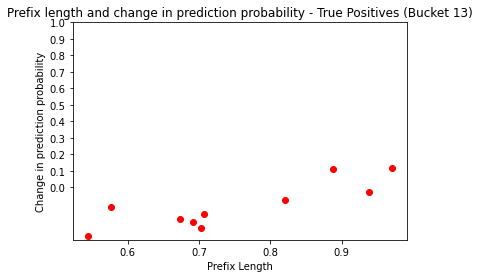

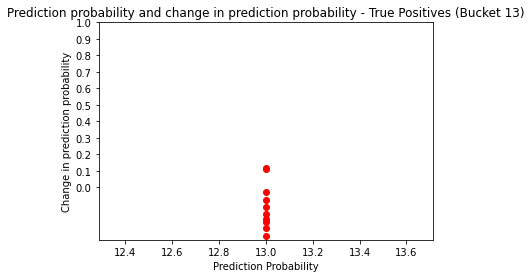

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

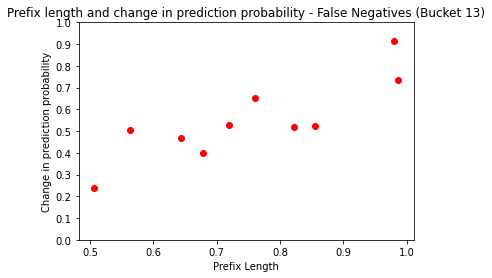

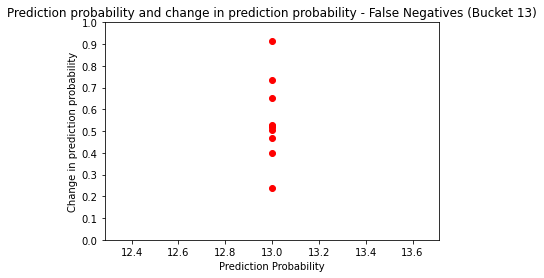

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 69
Creating distribution for feature 2 of 69
Creating distribution for feature 3 of 69
Creating distribution for feature 4 of 69
Creating distribution for feature 5 of 69
Creating distribution for feature 6 of 69
Creating distribution for feature 7 of 69
Creating distribution for feature 8 of 69
Creating distribution for feature 9 of 69
Creating distribution for feature 10 of 69
Creating distribution for feature 11 of 69
Creating distribution for feature 12 of 69
Creating distribution for feature 13 of 69
Creating distribution for feature 14 of 69
Creating distribution for feature 15 of 69
Creating distribution for feature 16 of 69
Creating distribution for feature 17 of 69
Creating distribution for feature 18 of 69
Creating distribution for feature 19 of 69
Creating distribution for feature 20 of 69
Creating distribution for feature 21 of 69
Creating distribution for feature 22 of 69
Creating di

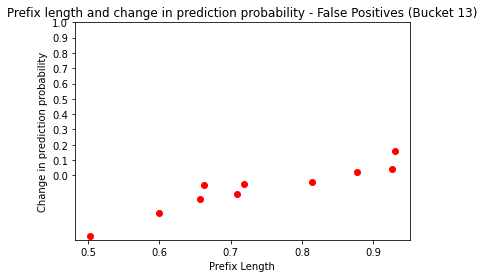

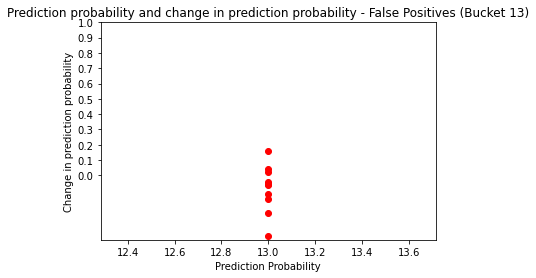

Bucket 14
Generating distributions for bucket
1 of 770 features
2 of 770 features
3 of 770 features
4 of 770 features
5 of 770 features
6 of 770 features
7 of 770 features
8 of 770 features
9 of 770 features
10 of 770 features
11 of 770 features
12 of 770 features
13 of 770 features
14 of 770 features
15 of 770 features
16 of 770 features
17 of 770 features
18 of 770 features
19 of 770 features
20 of 770 features
21 of 770 features
22 of 770 features
23 of 770 features
24 of 770 features
25 of 770 features
26 of 770 features
27 of 770 features
28 of 770 features
29 of 770 features
30 of 770 features
31 of 770 features
32 of 770 features
33 of 770 features
34 of 770 features
35 of 770 features
36 of 770 features
37 of 770 features
38 of 770 features
39 of 770 features
40 of 770 features
41 of 770 features
42 of 770 features
43 of 770 features
44 of 770 features
45 of 770 features
46 of 770 features
47 of 770 features
48 of 770 features
49 of 770 features
50 of 770 features
51 of 770 fea

414 of 770 features
415 of 770 features
416 of 770 features
417 of 770 features
418 of 770 features
419 of 770 features
420 of 770 features
421 of 770 features
422 of 770 features
423 of 770 features
424 of 770 features
425 of 770 features
426 of 770 features
427 of 770 features
428 of 770 features
429 of 770 features
430 of 770 features
431 of 770 features
432 of 770 features
433 of 770 features
434 of 770 features
435 of 770 features
436 of 770 features
437 of 770 features
438 of 770 features
439 of 770 features
440 of 770 features
441 of 770 features
442 of 770 features
443 of 770 features
444 of 770 features
445 of 770 features
446 of 770 features
447 of 770 features
448 of 770 features
449 of 770 features
450 of 770 features
451 of 770 features
452 of 770 features
453 of 770 features
454 of 770 features
455 of 770 features
456 of 770 features
457 of 770 features
458 of 770 features
459 of 770 features
460 of 770 features
461 of 770 features
462 of 770 features
463 of 770 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

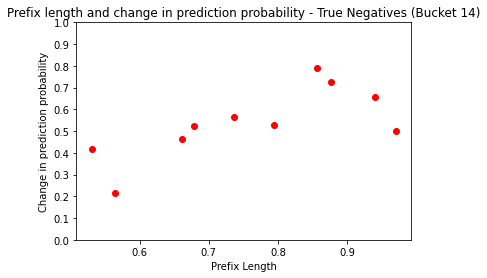

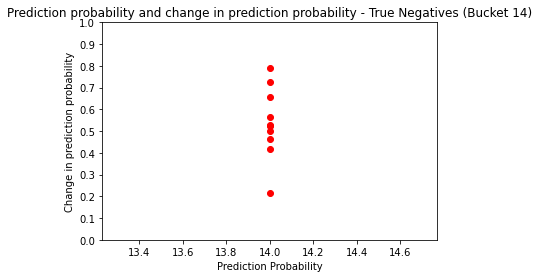

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

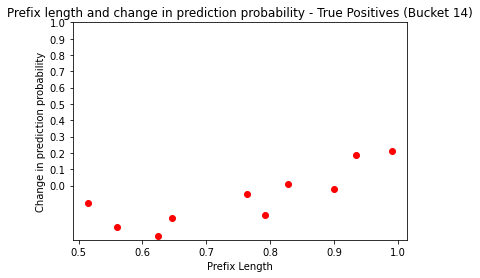

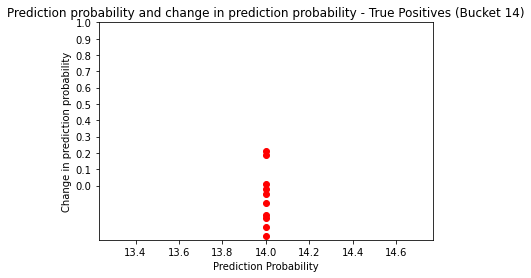

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

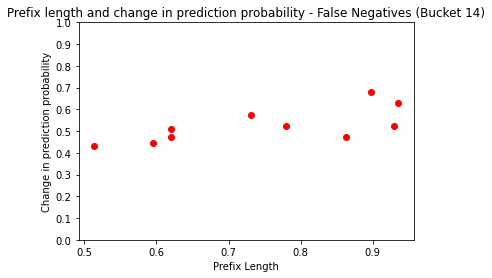

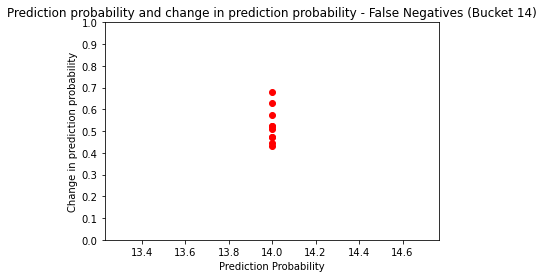

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 77
Creating distribution for feature 2 of 77
Creating distribution for feature 3 of 77
Creating distribution for feature 4 of 77
Creating distribution for feature 5 of 77
Creating distribution for feature 6 of 77
Creating distribution for feature 7 of 77
Creating distribution for feature 8 of 77
Creating distribution for feature 9 of 77
Creating distribution for feature 10 of 77
Creating distribution for feature 11 of 77
Creating distribution for feature 12 of 77
Creating distribution for feature 13 of 77
Creating distribution for feature 14 of 77
Creating distribution for feature 15 of 77
Creating distribution for feature 16 of 77
Creating distribution for feature 17 of 77
Creating distribution for feature 18 of 77
Creating distribution for feature 19 of 77
Creating distribution for feature 20 of 77
Creating distribution for feature 21 of 77
Creating distribution for feature 22 of 77
Creating di

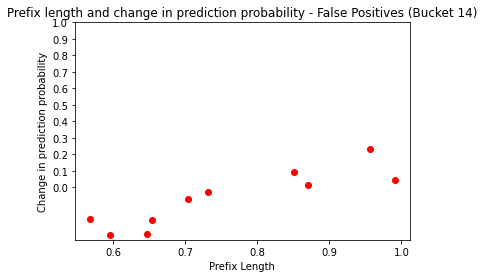

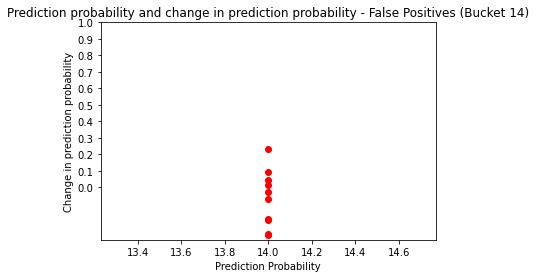

Bucket 15
Generating distributions for bucket
1 of 850 features
2 of 850 features
3 of 850 features
4 of 850 features
5 of 850 features
6 of 850 features
7 of 850 features
8 of 850 features
9 of 850 features
10 of 850 features
11 of 850 features
12 of 850 features
13 of 850 features
14 of 850 features
15 of 850 features
16 of 850 features
17 of 850 features
18 of 850 features
19 of 850 features
20 of 850 features
21 of 850 features
22 of 850 features
23 of 850 features
24 of 850 features
25 of 850 features
26 of 850 features
27 of 850 features
28 of 850 features
29 of 850 features
30 of 850 features
31 of 850 features
32 of 850 features
33 of 850 features
34 of 850 features
35 of 850 features
36 of 850 features
37 of 850 features
38 of 850 features
39 of 850 features
40 of 850 features
41 of 850 features
42 of 850 features
43 of 850 features
44 of 850 features
45 of 850 features
46 of 850 features
47 of 850 features
48 of 850 features
49 of 850 features
50 of 850 features
51 of 850 fea

414 of 850 features
415 of 850 features
416 of 850 features
417 of 850 features
418 of 850 features
419 of 850 features
420 of 850 features
421 of 850 features
422 of 850 features
423 of 850 features
424 of 850 features
425 of 850 features
426 of 850 features
427 of 850 features
428 of 850 features
429 of 850 features
430 of 850 features
431 of 850 features
432 of 850 features
433 of 850 features
434 of 850 features
435 of 850 features
436 of 850 features
437 of 850 features
438 of 850 features
439 of 850 features
440 of 850 features
441 of 850 features
442 of 850 features
443 of 850 features
444 of 850 features
445 of 850 features
446 of 850 features
447 of 850 features
448 of 850 features
449 of 850 features
450 of 850 features
451 of 850 features
452 of 850 features
453 of 850 features
454 of 850 features
455 of 850 features
456 of 850 features
457 of 850 features
458 of 850 features
459 of 850 features
460 of 850 features
461 of 850 features
462 of 850 features
463 of 850 features


827 of 850 features
828 of 850 features
829 of 850 features
830 of 850 features
831 of 850 features
832 of 850 features
833 of 850 features
834 of 850 features
835 of 850 features
836 of 850 features
837 of 850 features
838 of 850 features
839 of 850 features
840 of 850 features
841 of 850 features
842 of 850 features
843 of 850 features
844 of 850 features
845 of 850 features
846 of 850 features
847 of 850 features
848 of 850 features
849 of 850 features
850 of 850 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating dist

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

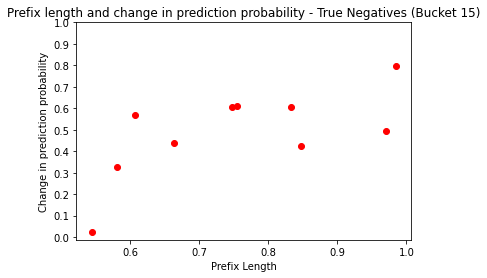

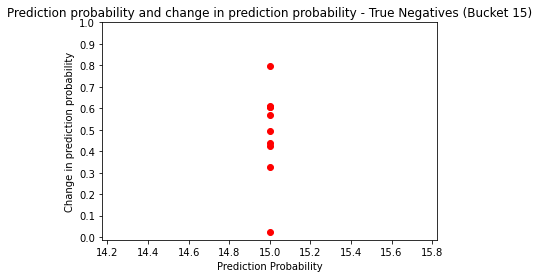

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

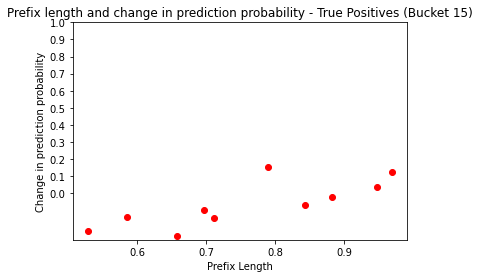

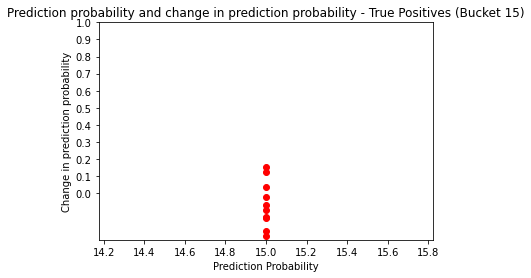

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

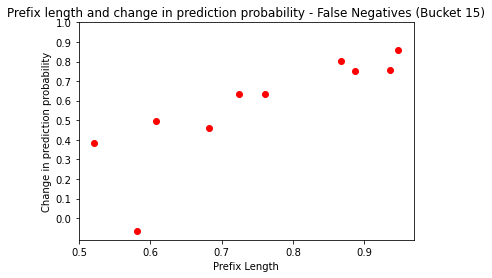

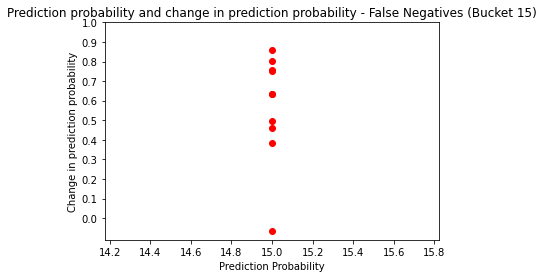

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 85
Creating distribution for feature 2 of 85
Creating distribution for feature 3 of 85
Creating distribution for feature 4 of 85
Creating distribution for feature 5 of 85
Creating distribution for feature 6 of 85
Creating distribution for feature 7 of 85
Creating distribution for feature 8 of 85
Creating distribution for feature 9 of 85
Creating distribution for feature 10 of 85
Creating distribution for feature 11 of 85
Creating distribution for feature 12 of 85
Creating distribution for feature 13 of 85
Creating distribution for feature 14 of 85
Creating distribution for feature 15 of 85
Creating distribution for feature 16 of 85
Creating distribution for feature 17 of 85
Creating distribution for feature 18 of 85
Creating distribution for feature 19 of 85
Creating distribution for feature 20 of 85
Creating distribution for feature 21 of 85
Creating distribution for feature 22 of 85
Creating di

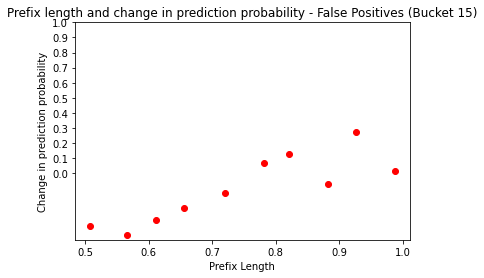

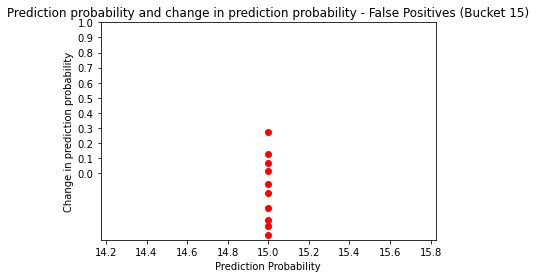

Bucket 16
Generating distributions for bucket
1 of 928 features
2 of 928 features
3 of 928 features
4 of 928 features
5 of 928 features
6 of 928 features
7 of 928 features
8 of 928 features
9 of 928 features
10 of 928 features
11 of 928 features
12 of 928 features
13 of 928 features
14 of 928 features
15 of 928 features
16 of 928 features
17 of 928 features
18 of 928 features
19 of 928 features
20 of 928 features
21 of 928 features
22 of 928 features
23 of 928 features
24 of 928 features
25 of 928 features
26 of 928 features
27 of 928 features
28 of 928 features
29 of 928 features
30 of 928 features
31 of 928 features
32 of 928 features
33 of 928 features
34 of 928 features
35 of 928 features
36 of 928 features
37 of 928 features
38 of 928 features
39 of 928 features
40 of 928 features
41 of 928 features
42 of 928 features
43 of 928 features
44 of 928 features
45 of 928 features
46 of 928 features
47 of 928 features
48 of 928 features
49 of 928 features
50 of 928 features
51 of 928 fea

417 of 928 features
418 of 928 features
419 of 928 features
420 of 928 features
421 of 928 features
422 of 928 features
423 of 928 features
424 of 928 features
425 of 928 features
426 of 928 features
427 of 928 features
428 of 928 features
429 of 928 features
430 of 928 features
431 of 928 features
432 of 928 features
433 of 928 features
434 of 928 features
435 of 928 features
436 of 928 features
437 of 928 features
438 of 928 features
439 of 928 features
440 of 928 features
441 of 928 features
442 of 928 features
443 of 928 features
444 of 928 features
445 of 928 features
446 of 928 features
447 of 928 features
448 of 928 features
449 of 928 features
450 of 928 features
451 of 928 features
452 of 928 features
453 of 928 features
454 of 928 features
455 of 928 features
456 of 928 features
457 of 928 features
458 of 928 features
459 of 928 features
460 of 928 features
461 of 928 features
462 of 928 features
463 of 928 features
464 of 928 features
465 of 928 features
466 of 928 features


830 of 928 features
831 of 928 features
832 of 928 features
833 of 928 features
834 of 928 features
835 of 928 features
836 of 928 features
837 of 928 features
838 of 928 features
839 of 928 features
840 of 928 features
841 of 928 features
842 of 928 features
843 of 928 features
844 of 928 features
845 of 928 features
846 of 928 features
847 of 928 features
848 of 928 features
849 of 928 features
850 of 928 features
851 of 928 features
852 of 928 features
853 of 928 features
854 of 928 features
855 of 928 features
856 of 928 features
857 of 928 features
858 of 928 features
859 of 928 features
860 of 928 features
861 of 928 features
862 of 928 features
863 of 928 features
864 of 928 features
865 of 928 features
866 of 928 features
867 of 928 features
868 of 928 features
869 of 928 features
870 of 928 features
871 of 928 features
872 of 928 features
873 of 928 features
874 of 928 features
875 of 928 features
876 of 928 features
877 of 928 features
878 of 928 features
879 of 928 features


Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

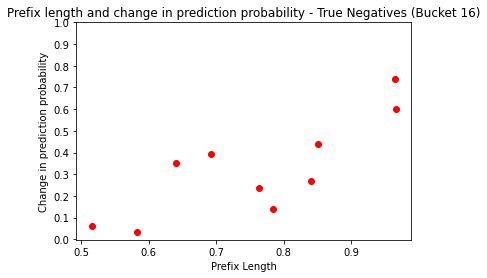

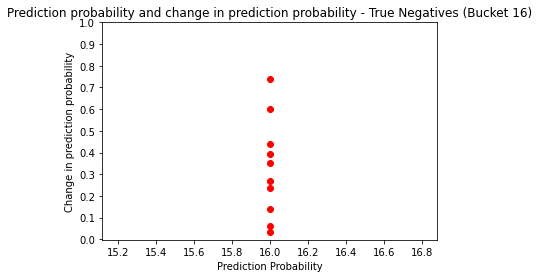

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

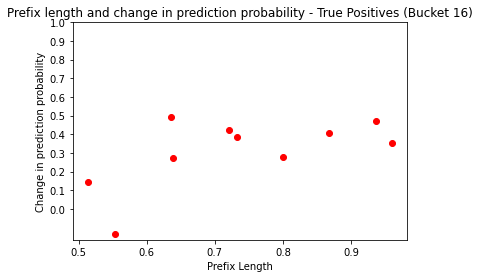

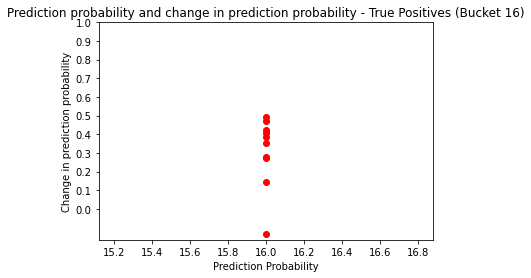

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

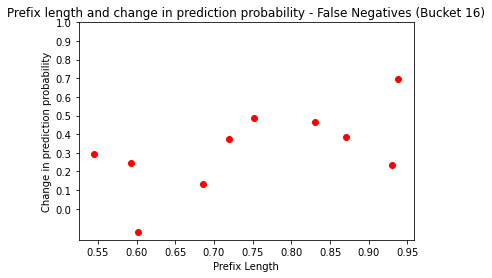

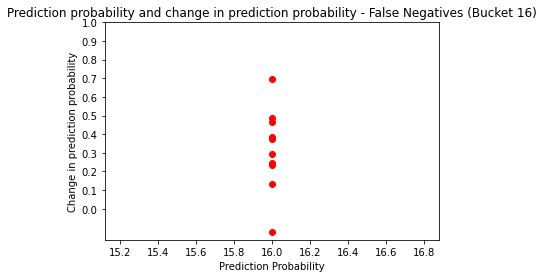

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 93
Creating distribution for feature 2 of 93
Creating distribution for feature 3 of 93
Creating distribution for feature 4 of 93
Creating distribution for feature 5 of 93
Creating distribution for feature 6 of 93
Creating distribution for feature 7 of 93
Creating distribution for feature 8 of 93
Creating distribution for feature 9 of 93
Creating distribution for feature 10 of 93
Creating distribution for feature 11 of 93
Creating distribution for feature 12 of 93
Creating distribution for feature 13 of 93
Creating distribution for feature 14 of 93
Creating distribution for feature 15 of 93
Creating distribution for feature 16 of 93
Creating distribution for feature 17 of 93
Creating distribution for feature 18 of 93
Creating distribution for feature 19 of 93
Creating distribution for feature 20 of 93
Creating distribution for feature 21 of 93
Creating distribution for feature 22 of 93
Creating di

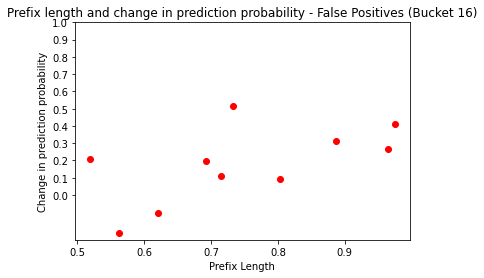

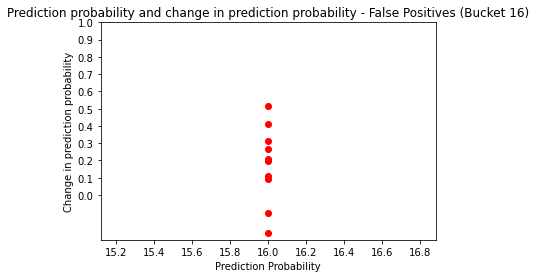

Bucket 17
Generating distributions for bucket
1 of 1005 features
2 of 1005 features
3 of 1005 features
4 of 1005 features
5 of 1005 features
6 of 1005 features
7 of 1005 features
8 of 1005 features
9 of 1005 features
10 of 1005 features
11 of 1005 features
12 of 1005 features
13 of 1005 features
14 of 1005 features
15 of 1005 features
16 of 1005 features
17 of 1005 features
18 of 1005 features
19 of 1005 features
20 of 1005 features
21 of 1005 features
22 of 1005 features
23 of 1005 features
24 of 1005 features
25 of 1005 features
26 of 1005 features
27 of 1005 features
28 of 1005 features
29 of 1005 features
30 of 1005 features
31 of 1005 features
32 of 1005 features
33 of 1005 features
34 of 1005 features
35 of 1005 features
36 of 1005 features
37 of 1005 features
38 of 1005 features
39 of 1005 features
40 of 1005 features
41 of 1005 features
42 of 1005 features
43 of 1005 features
44 of 1005 features
45 of 1005 features
46 of 1005 features
47 of 1005 features
48 of 1005 features
49 

398 of 1005 features
399 of 1005 features
400 of 1005 features
401 of 1005 features
402 of 1005 features
403 of 1005 features
404 of 1005 features
405 of 1005 features
406 of 1005 features
407 of 1005 features
408 of 1005 features
409 of 1005 features
410 of 1005 features
411 of 1005 features
412 of 1005 features
413 of 1005 features
414 of 1005 features
415 of 1005 features
416 of 1005 features
417 of 1005 features
418 of 1005 features
419 of 1005 features
420 of 1005 features
421 of 1005 features
422 of 1005 features
423 of 1005 features
424 of 1005 features
425 of 1005 features
426 of 1005 features
427 of 1005 features
428 of 1005 features
429 of 1005 features
430 of 1005 features
431 of 1005 features
432 of 1005 features
433 of 1005 features
434 of 1005 features
435 of 1005 features
436 of 1005 features
437 of 1005 features
438 of 1005 features
439 of 1005 features
440 of 1005 features
441 of 1005 features
442 of 1005 features
443 of 1005 features
444 of 1005 features
445 of 1005 f

791 of 1005 features
792 of 1005 features
793 of 1005 features
794 of 1005 features
795 of 1005 features
796 of 1005 features
797 of 1005 features
798 of 1005 features
799 of 1005 features
800 of 1005 features
801 of 1005 features
802 of 1005 features
803 of 1005 features
804 of 1005 features
805 of 1005 features
806 of 1005 features
807 of 1005 features
808 of 1005 features
809 of 1005 features
810 of 1005 features
811 of 1005 features
812 of 1005 features
813 of 1005 features
814 of 1005 features
815 of 1005 features
816 of 1005 features
817 of 1005 features
818 of 1005 features
819 of 1005 features
820 of 1005 features
821 of 1005 features
822 of 1005 features
823 of 1005 features
824 of 1005 features
825 of 1005 features
826 of 1005 features
827 of 1005 features
828 of 1005 features
829 of 1005 features
830 of 1005 features
831 of 1005 features
832 of 1005 features
833 of 1005 features
834 of 1005 features
835 of 1005 features
836 of 1005 features
837 of 1005 features
838 of 1005 f

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

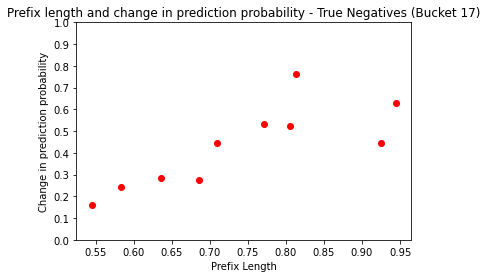

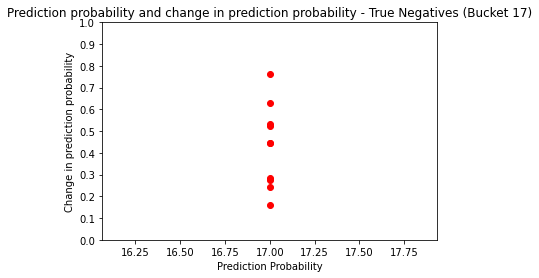

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

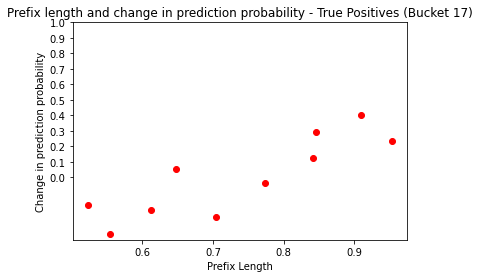

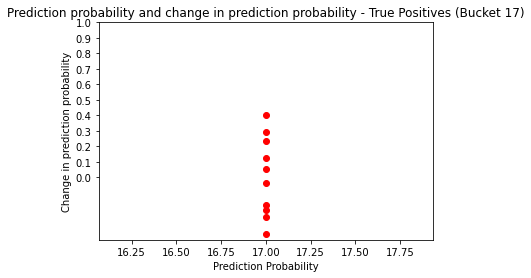

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

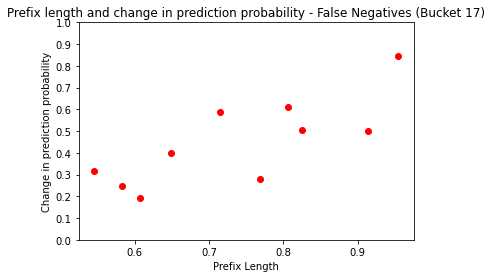

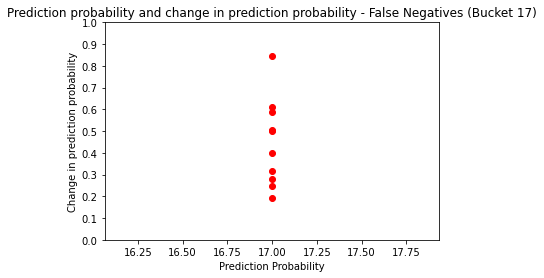

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 100
Creating distribution for feature 2 of 100
Creating distribution for feature 3 of 100
Creating distribution for feature 4 of 100
Creating distribution for feature 5 of 100
Creating distribution for feature 6 of 100
Creating distribution for feature 7 of 100
Creating distribution for feature 8 of 100
Creating distribution for feature 9 of 100
Creating distribution for feature 10 of 100
Creating distribution for feature 11 of 100
Creating distribution for feature 12 of 100
Creating distribution for feature 13 of 100
Creating distribution for feature 14 of 100
Creating distribution for feature 15 of 100
Creating distribution for feature 16 of 100
Creating distribution for feature 17 of 100
Creating distribution for feature 18 of 100
Creating distribution for feature 19 of 100
Creating distribution for feature 20 of 100
Creating distribution for feature 21 of 100
Creating distribution for feature

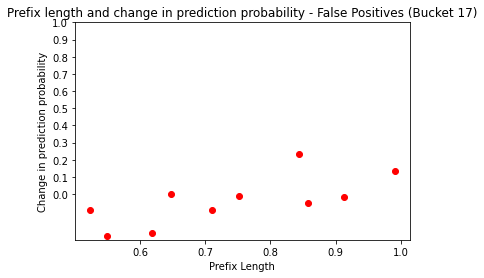

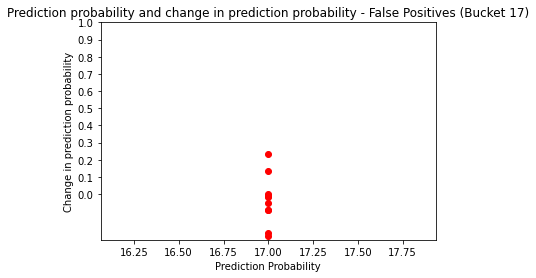

Bucket 18
Generating distributions for bucket
1 of 1091 features
2 of 1091 features
3 of 1091 features
4 of 1091 features
5 of 1091 features
6 of 1091 features
7 of 1091 features
8 of 1091 features
9 of 1091 features
10 of 1091 features
11 of 1091 features
12 of 1091 features
13 of 1091 features
14 of 1091 features
15 of 1091 features
16 of 1091 features
17 of 1091 features
18 of 1091 features
19 of 1091 features
20 of 1091 features
21 of 1091 features
22 of 1091 features
23 of 1091 features
24 of 1091 features
25 of 1091 features
26 of 1091 features
27 of 1091 features
28 of 1091 features
29 of 1091 features
30 of 1091 features
31 of 1091 features
32 of 1091 features
33 of 1091 features
34 of 1091 features
35 of 1091 features
36 of 1091 features
37 of 1091 features
38 of 1091 features
39 of 1091 features
40 of 1091 features
41 of 1091 features
42 of 1091 features
43 of 1091 features
44 of 1091 features
45 of 1091 features
46 of 1091 features
47 of 1091 features
48 of 1091 features
49 

396 of 1091 features
397 of 1091 features
398 of 1091 features
399 of 1091 features
400 of 1091 features
401 of 1091 features
402 of 1091 features
403 of 1091 features
404 of 1091 features
405 of 1091 features
406 of 1091 features
407 of 1091 features
408 of 1091 features
409 of 1091 features
410 of 1091 features
411 of 1091 features
412 of 1091 features
413 of 1091 features
414 of 1091 features
415 of 1091 features
416 of 1091 features
417 of 1091 features
418 of 1091 features
419 of 1091 features
420 of 1091 features
421 of 1091 features
422 of 1091 features
423 of 1091 features
424 of 1091 features
425 of 1091 features
426 of 1091 features
427 of 1091 features
428 of 1091 features
429 of 1091 features
430 of 1091 features
431 of 1091 features
432 of 1091 features
433 of 1091 features
434 of 1091 features
435 of 1091 features
436 of 1091 features
437 of 1091 features
438 of 1091 features
439 of 1091 features
440 of 1091 features
441 of 1091 features
442 of 1091 features
443 of 1091 f

790 of 1091 features
791 of 1091 features
792 of 1091 features
793 of 1091 features
794 of 1091 features
795 of 1091 features
796 of 1091 features
797 of 1091 features
798 of 1091 features
799 of 1091 features
800 of 1091 features
801 of 1091 features
802 of 1091 features
803 of 1091 features
804 of 1091 features
805 of 1091 features
806 of 1091 features
807 of 1091 features
808 of 1091 features
809 of 1091 features
810 of 1091 features
811 of 1091 features
812 of 1091 features
813 of 1091 features
814 of 1091 features
815 of 1091 features
816 of 1091 features
817 of 1091 features
818 of 1091 features
819 of 1091 features
820 of 1091 features
821 of 1091 features
822 of 1091 features
823 of 1091 features
824 of 1091 features
825 of 1091 features
826 of 1091 features
827 of 1091 features
828 of 1091 features
829 of 1091 features
830 of 1091 features
831 of 1091 features
832 of 1091 features
833 of 1091 features
834 of 1091 features
835 of 1091 features
836 of 1091 features
837 of 1091 f

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

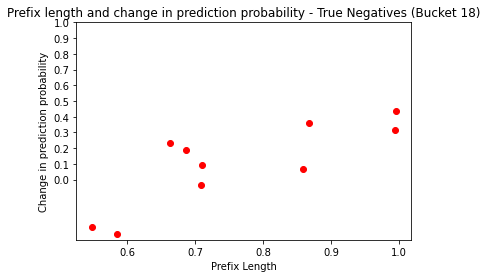

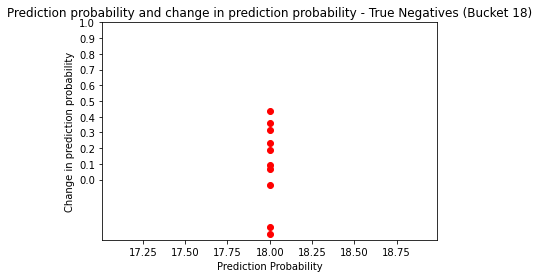

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

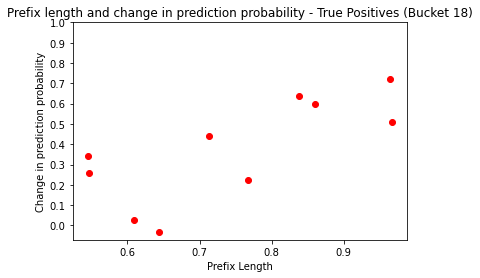

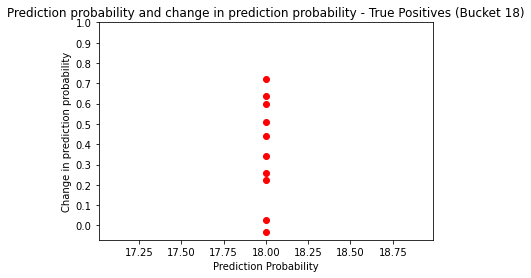

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

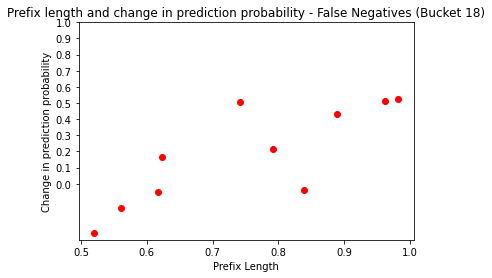

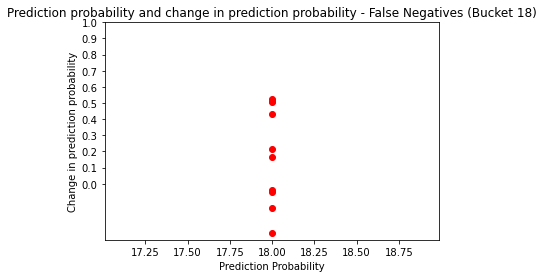

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 109
Creating distribution for feature 2 of 109
Creating distribution for feature 3 of 109
Creating distribution for feature 4 of 109
Creating distribution for feature 5 of 109
Creating distribution for feature 6 of 109
Creating distribution for feature 7 of 109
Creating distribution for feature 8 of 109
Creating distribution for feature 9 of 109
Creating distribution for feature 10 of 109
Creating distribution for feature 11 of 109
Creating distribution for feature 12 of 109
Creating distribution for feature 13 of 109
Creating distribution for feature 14 of 109
Creating distribution for feature 15 of 109
Creating distribution for feature 16 of 109
Creating distribution for feature 17 of 109
Creating distribution for feature 18 of 109
Creating distribution for feature 19 of 109
Creating distribution for feature 20 of 109
Creating distribution for feature 21 of 109
Creating distribution for feature

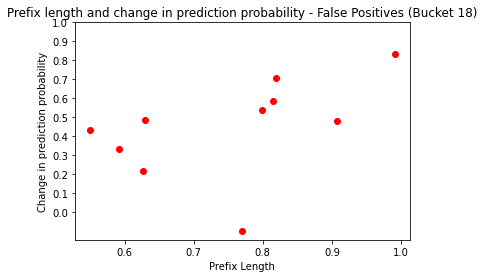

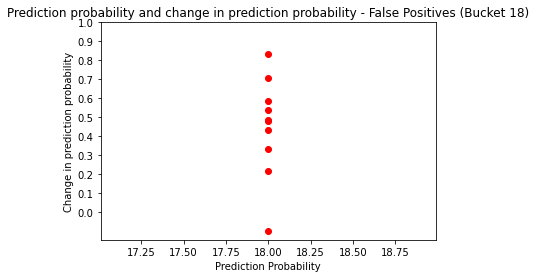

Bucket 19
Generating distributions for bucket
1 of 1176 features
2 of 1176 features
3 of 1176 features
4 of 1176 features
5 of 1176 features
6 of 1176 features
7 of 1176 features
8 of 1176 features
9 of 1176 features
10 of 1176 features
11 of 1176 features
12 of 1176 features
13 of 1176 features
14 of 1176 features
15 of 1176 features
16 of 1176 features
17 of 1176 features
18 of 1176 features
19 of 1176 features
20 of 1176 features
21 of 1176 features
22 of 1176 features
23 of 1176 features
24 of 1176 features
25 of 1176 features
26 of 1176 features
27 of 1176 features
28 of 1176 features
29 of 1176 features
30 of 1176 features
31 of 1176 features
32 of 1176 features
33 of 1176 features
34 of 1176 features
35 of 1176 features
36 of 1176 features
37 of 1176 features
38 of 1176 features
39 of 1176 features
40 of 1176 features
41 of 1176 features
42 of 1176 features
43 of 1176 features
44 of 1176 features
45 of 1176 features
46 of 1176 features
47 of 1176 features
48 of 1176 features
49 

395 of 1176 features
396 of 1176 features
397 of 1176 features
398 of 1176 features
399 of 1176 features
400 of 1176 features
401 of 1176 features
402 of 1176 features
403 of 1176 features
404 of 1176 features
405 of 1176 features
406 of 1176 features
407 of 1176 features
408 of 1176 features
409 of 1176 features
410 of 1176 features
411 of 1176 features
412 of 1176 features
413 of 1176 features
414 of 1176 features
415 of 1176 features
416 of 1176 features
417 of 1176 features
418 of 1176 features
419 of 1176 features
420 of 1176 features
421 of 1176 features
422 of 1176 features
423 of 1176 features
424 of 1176 features
425 of 1176 features
426 of 1176 features
427 of 1176 features
428 of 1176 features
429 of 1176 features
430 of 1176 features
431 of 1176 features
432 of 1176 features
433 of 1176 features
434 of 1176 features
435 of 1176 features
436 of 1176 features
437 of 1176 features
438 of 1176 features
439 of 1176 features
440 of 1176 features
441 of 1176 features
442 of 1176 f

788 of 1176 features
789 of 1176 features
790 of 1176 features
791 of 1176 features
792 of 1176 features
793 of 1176 features
794 of 1176 features
795 of 1176 features
796 of 1176 features
797 of 1176 features
798 of 1176 features
799 of 1176 features
800 of 1176 features
801 of 1176 features
802 of 1176 features
803 of 1176 features
804 of 1176 features
805 of 1176 features
806 of 1176 features
807 of 1176 features
808 of 1176 features
809 of 1176 features
810 of 1176 features
811 of 1176 features
812 of 1176 features
813 of 1176 features
814 of 1176 features
815 of 1176 features
816 of 1176 features
817 of 1176 features
818 of 1176 features
819 of 1176 features
820 of 1176 features
821 of 1176 features
822 of 1176 features
823 of 1176 features
824 of 1176 features
825 of 1176 features
826 of 1176 features
827 of 1176 features
828 of 1176 features
829 of 1176 features
830 of 1176 features
831 of 1176 features
832 of 1176 features
833 of 1176 features
834 of 1176 features
835 of 1176 f

1171 of 1176 features
1172 of 1176 features
1173 of 1176 features
1174 of 1176 features
1175 of 1176 features
1176 of 1176 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

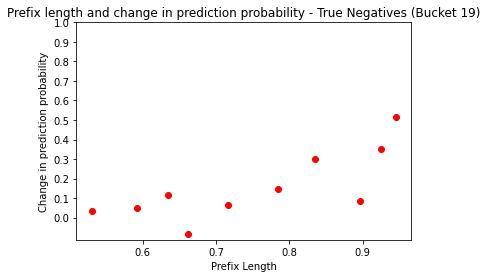

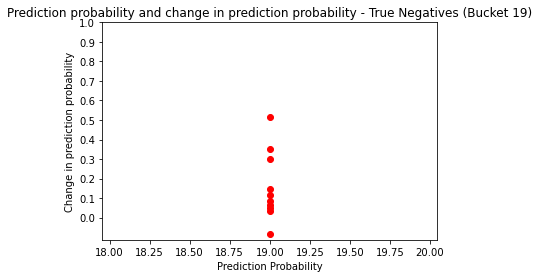

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

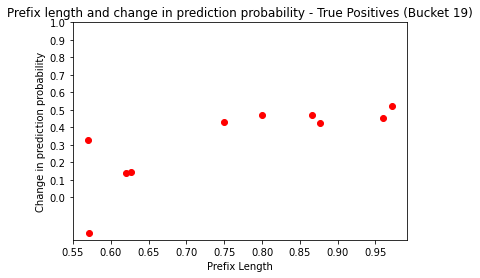

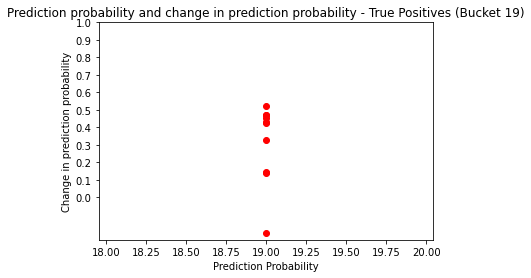

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

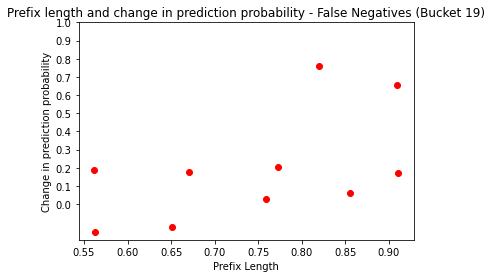

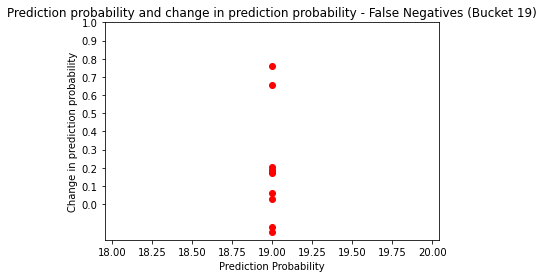

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 118
Creating distribution for feature 2 of 118
Creating distribution for feature 3 of 118
Creating distribution for feature 4 of 118
Creating distribution for feature 5 of 118
Creating distribution for feature 6 of 118
Creating distribution for feature 7 of 118
Creating distribution for feature 8 of 118
Creating distribution for feature 9 of 118
Creating distribution for feature 10 of 118
Creating distribution for feature 11 of 118
Creating distribution for feature 12 of 118
Creating distribution for feature 13 of 118
Creating distribution for feature 14 of 118
Creating distribution for feature 15 of 118
Creating distribution for feature 16 of 118
Creating distribution for feature 17 of 118
Creating distribution for feature 18 of 118
Creating distribution for feature 19 of 118
Creating distribution for feature 20 of 118
Creating distribution for feature 21 of 118
Creating distribution for feature

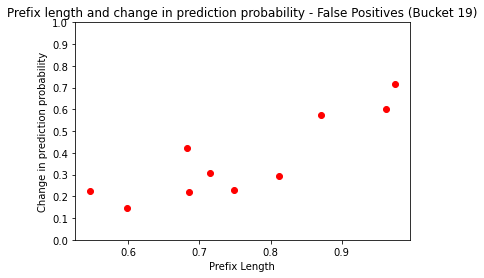

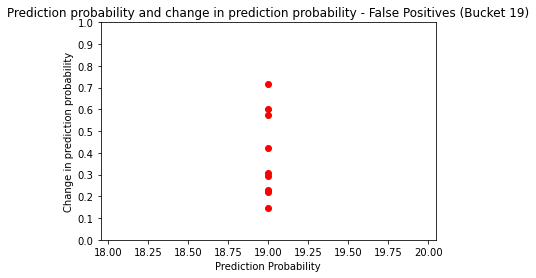

Bucket 20
Generating distributions for bucket
1 of 1260 features
2 of 1260 features
3 of 1260 features
4 of 1260 features
5 of 1260 features
6 of 1260 features
7 of 1260 features
8 of 1260 features
9 of 1260 features
10 of 1260 features
11 of 1260 features
12 of 1260 features
13 of 1260 features
14 of 1260 features
15 of 1260 features
16 of 1260 features
17 of 1260 features
18 of 1260 features
19 of 1260 features
20 of 1260 features
21 of 1260 features
22 of 1260 features
23 of 1260 features
24 of 1260 features
25 of 1260 features
26 of 1260 features
27 of 1260 features
28 of 1260 features
29 of 1260 features
30 of 1260 features
31 of 1260 features
32 of 1260 features
33 of 1260 features
34 of 1260 features
35 of 1260 features
36 of 1260 features
37 of 1260 features
38 of 1260 features
39 of 1260 features
40 of 1260 features
41 of 1260 features
42 of 1260 features
43 of 1260 features
44 of 1260 features
45 of 1260 features
46 of 1260 features
47 of 1260 features
48 of 1260 features
49 

395 of 1260 features
396 of 1260 features
397 of 1260 features
398 of 1260 features
399 of 1260 features
400 of 1260 features
401 of 1260 features
402 of 1260 features
403 of 1260 features
404 of 1260 features
405 of 1260 features
406 of 1260 features
407 of 1260 features
408 of 1260 features
409 of 1260 features
410 of 1260 features
411 of 1260 features
412 of 1260 features
413 of 1260 features
414 of 1260 features
415 of 1260 features
416 of 1260 features
417 of 1260 features
418 of 1260 features
419 of 1260 features
420 of 1260 features
421 of 1260 features
422 of 1260 features
423 of 1260 features
424 of 1260 features
425 of 1260 features
426 of 1260 features
427 of 1260 features
428 of 1260 features
429 of 1260 features
430 of 1260 features
431 of 1260 features
432 of 1260 features
433 of 1260 features
434 of 1260 features
435 of 1260 features
436 of 1260 features
437 of 1260 features
438 of 1260 features
439 of 1260 features
440 of 1260 features
441 of 1260 features
442 of 1260 f

789 of 1260 features
790 of 1260 features
791 of 1260 features
792 of 1260 features
793 of 1260 features
794 of 1260 features
795 of 1260 features
796 of 1260 features
797 of 1260 features
798 of 1260 features
799 of 1260 features
800 of 1260 features
801 of 1260 features
802 of 1260 features
803 of 1260 features
804 of 1260 features
805 of 1260 features
806 of 1260 features
807 of 1260 features
808 of 1260 features
809 of 1260 features
810 of 1260 features
811 of 1260 features
812 of 1260 features
813 of 1260 features
814 of 1260 features
815 of 1260 features
816 of 1260 features
817 of 1260 features
818 of 1260 features
819 of 1260 features
820 of 1260 features
821 of 1260 features
822 of 1260 features
823 of 1260 features
824 of 1260 features
825 of 1260 features
826 of 1260 features
827 of 1260 features
828 of 1260 features
829 of 1260 features
830 of 1260 features
831 of 1260 features
832 of 1260 features
833 of 1260 features
834 of 1260 features
835 of 1260 features
836 of 1260 f

1173 of 1260 features
1174 of 1260 features
1175 of 1260 features
1176 of 1260 features
1177 of 1260 features
1178 of 1260 features
1179 of 1260 features
1180 of 1260 features
1181 of 1260 features
1182 of 1260 features
1183 of 1260 features
1184 of 1260 features
1185 of 1260 features
1186 of 1260 features
1187 of 1260 features
1188 of 1260 features
1189 of 1260 features
1190 of 1260 features
1191 of 1260 features
1192 of 1260 features
1193 of 1260 features
1194 of 1260 features
1195 of 1260 features
1196 of 1260 features
1197 of 1260 features
1198 of 1260 features
1199 of 1260 features
1200 of 1260 features
1201 of 1260 features
1202 of 1260 features
1203 of 1260 features
1204 of 1260 features
1205 of 1260 features
1206 of 1260 features
1207 of 1260 features
1208 of 1260 features
1209 of 1260 features
1210 of 1260 features
1211 of 1260 features
1212 of 1260 features
1213 of 1260 features
1214 of 1260 features
1215 of 1260 features
1216 of 1260 features
1217 of 1260 features
1218 of 12

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

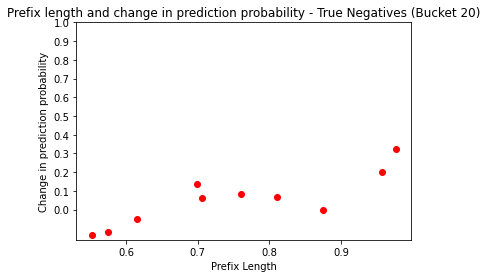

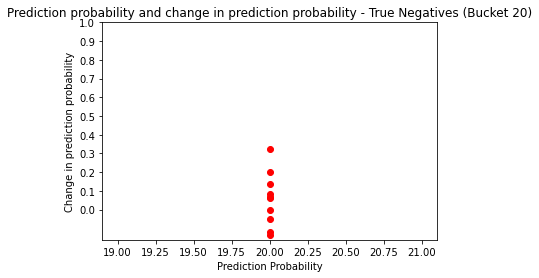

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

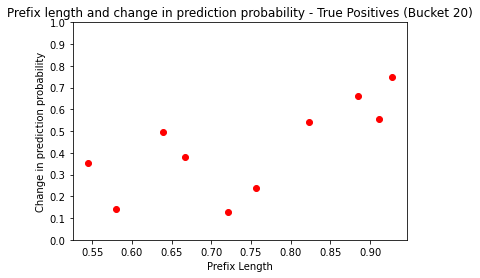

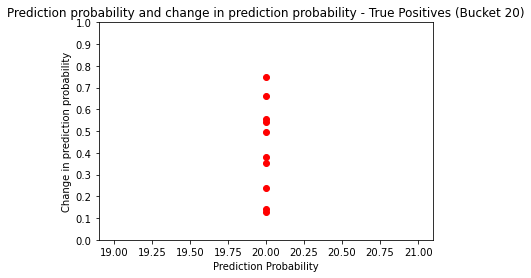

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

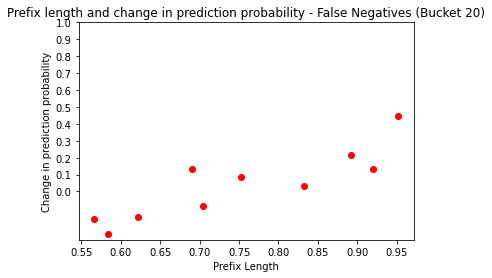

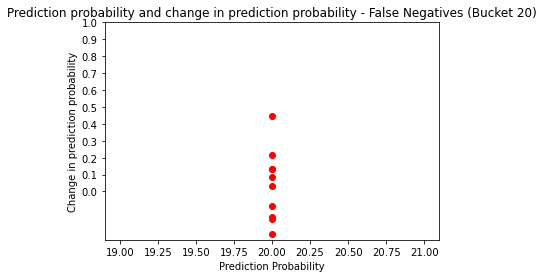

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 126
Creating distribution for feature 2 of 126
Creating distribution for feature 3 of 126
Creating distribution for feature 4 of 126
Creating distribution for feature 5 of 126
Creating distribution for feature 6 of 126
Creating distribution for feature 7 of 126
Creating distribution for feature 8 of 126
Creating distribution for feature 9 of 126
Creating distribution for feature 10 of 126
Creating distribution for feature 11 of 126
Creating distribution for feature 12 of 126
Creating distribution for feature 13 of 126
Creating distribution for feature 14 of 126
Creating distribution for feature 15 of 126
Creating distribution for feature 16 of 126
Creating distribution for feature 17 of 126
Creating distribution for feature 18 of 126
Creating distribution for feature 19 of 126
Creating distribution for feature 20 of 126
Creating distribution for feature 21 of 126
Creating distribution for feature

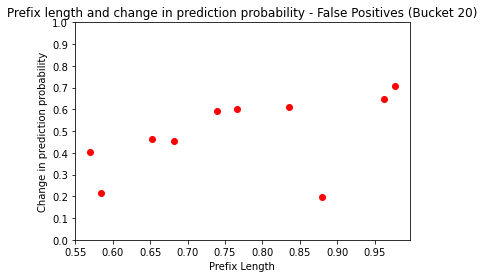

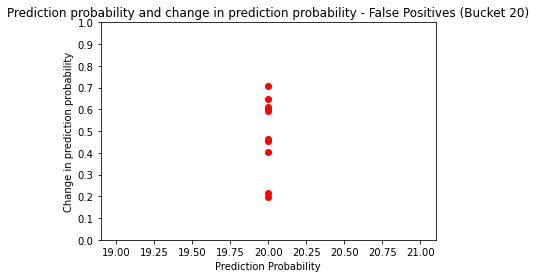

Bucket 21
Generating distributions for bucket
1 of 1344 features
2 of 1344 features
3 of 1344 features
4 of 1344 features
5 of 1344 features
6 of 1344 features
7 of 1344 features
8 of 1344 features
9 of 1344 features
10 of 1344 features
11 of 1344 features
12 of 1344 features
13 of 1344 features
14 of 1344 features
15 of 1344 features
16 of 1344 features
17 of 1344 features
18 of 1344 features
19 of 1344 features
20 of 1344 features
21 of 1344 features
22 of 1344 features
23 of 1344 features
24 of 1344 features
25 of 1344 features
26 of 1344 features
27 of 1344 features
28 of 1344 features
29 of 1344 features
30 of 1344 features
31 of 1344 features
32 of 1344 features
33 of 1344 features
34 of 1344 features
35 of 1344 features
36 of 1344 features
37 of 1344 features
38 of 1344 features
39 of 1344 features
40 of 1344 features
41 of 1344 features
42 of 1344 features
43 of 1344 features
44 of 1344 features
45 of 1344 features
46 of 1344 features
47 of 1344 features
48 of 1344 features
49 

396 of 1344 features
397 of 1344 features
398 of 1344 features
399 of 1344 features
400 of 1344 features
401 of 1344 features
402 of 1344 features
403 of 1344 features
404 of 1344 features
405 of 1344 features
406 of 1344 features
407 of 1344 features
408 of 1344 features
409 of 1344 features
410 of 1344 features
411 of 1344 features
412 of 1344 features
413 of 1344 features
414 of 1344 features
415 of 1344 features
416 of 1344 features
417 of 1344 features
418 of 1344 features
419 of 1344 features
420 of 1344 features
421 of 1344 features
422 of 1344 features
423 of 1344 features
424 of 1344 features
425 of 1344 features
426 of 1344 features
427 of 1344 features
428 of 1344 features
429 of 1344 features
430 of 1344 features
431 of 1344 features
432 of 1344 features
433 of 1344 features
434 of 1344 features
435 of 1344 features
436 of 1344 features
437 of 1344 features
438 of 1344 features
439 of 1344 features
440 of 1344 features
441 of 1344 features
442 of 1344 features
443 of 1344 f

790 of 1344 features
791 of 1344 features
792 of 1344 features
793 of 1344 features
794 of 1344 features
795 of 1344 features
796 of 1344 features
797 of 1344 features
798 of 1344 features
799 of 1344 features
800 of 1344 features
801 of 1344 features
802 of 1344 features
803 of 1344 features
804 of 1344 features
805 of 1344 features
806 of 1344 features
807 of 1344 features
808 of 1344 features
809 of 1344 features
810 of 1344 features
811 of 1344 features
812 of 1344 features
813 of 1344 features
814 of 1344 features
815 of 1344 features
816 of 1344 features
817 of 1344 features
818 of 1344 features
819 of 1344 features
820 of 1344 features
821 of 1344 features
822 of 1344 features
823 of 1344 features
824 of 1344 features
825 of 1344 features
826 of 1344 features
827 of 1344 features
828 of 1344 features
829 of 1344 features
830 of 1344 features
831 of 1344 features
832 of 1344 features
833 of 1344 features
834 of 1344 features
835 of 1344 features
836 of 1344 features
837 of 1344 f

1172 of 1344 features
1173 of 1344 features
1174 of 1344 features
1175 of 1344 features
1176 of 1344 features
1177 of 1344 features
1178 of 1344 features
1179 of 1344 features
1180 of 1344 features
1181 of 1344 features
1182 of 1344 features
1183 of 1344 features
1184 of 1344 features
1185 of 1344 features
1186 of 1344 features
1187 of 1344 features
1188 of 1344 features
1189 of 1344 features
1190 of 1344 features
1191 of 1344 features
1192 of 1344 features
1193 of 1344 features
1194 of 1344 features
1195 of 1344 features
1196 of 1344 features
1197 of 1344 features
1198 of 1344 features
1199 of 1344 features
1200 of 1344 features
1201 of 1344 features
1202 of 1344 features
1203 of 1344 features
1204 of 1344 features
1205 of 1344 features
1206 of 1344 features
1207 of 1344 features
1208 of 1344 features
1209 of 1344 features
1210 of 1344 features
1211 of 1344 features
1212 of 1344 features
1213 of 1344 features
1214 of 1344 features
1215 of 1344 features
1216 of 1344 features
1217 of 13

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

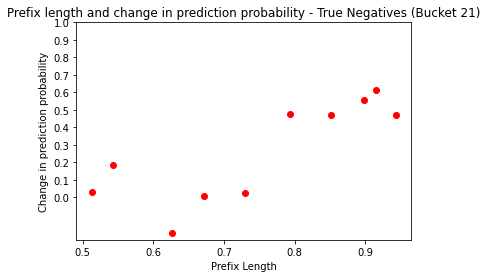

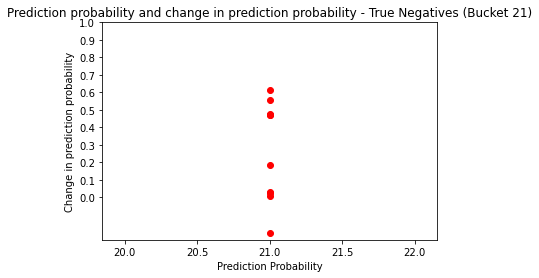

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

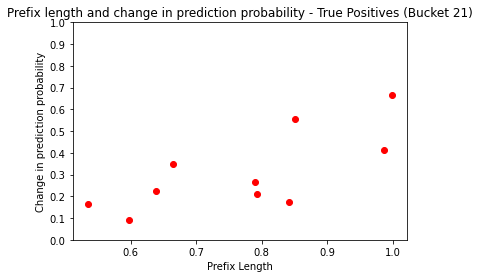

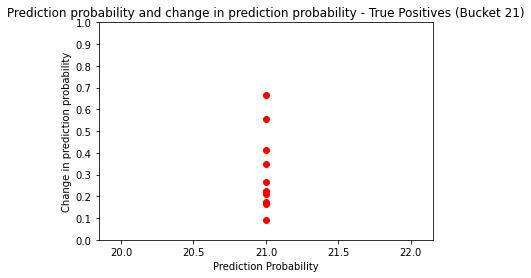

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

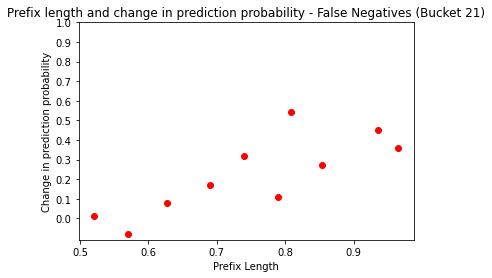

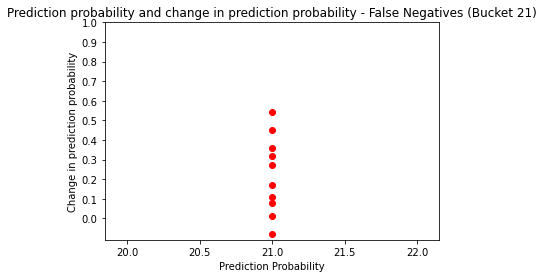

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 134
Creating distribution for feature 2 of 134
Creating distribution for feature 3 of 134
Creating distribution for feature 4 of 134
Creating distribution for feature 5 of 134
Creating distribution for feature 6 of 134
Creating distribution for feature 7 of 134
Creating distribution for feature 8 of 134
Creating distribution for feature 9 of 134
Creating distribution for feature 10 of 134
Creating distribution for feature 11 of 134
Creating distribution for feature 12 of 134
Creating distribution for feature 13 of 134
Creating distribution for feature 14 of 134
Creating distribution for feature 15 of 134
Creating distribution for feature 16 of 134
Creating distribution for feature 17 of 134
Creating distribution for feature 18 of 134
Creating distribution for feature 19 of 134
Creating distribution for feature 20 of 134
Creating distribution for feature 21 of 134
Creating distribution for feature

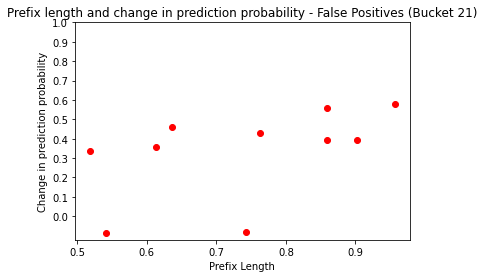

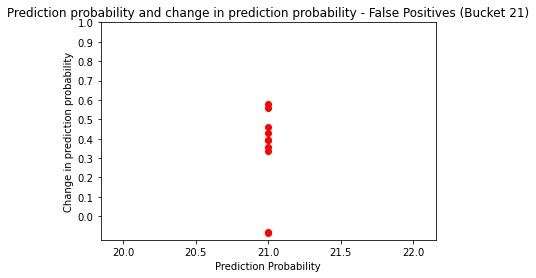

Bucket 22
Generating distributions for bucket
1 of 1431 features
2 of 1431 features
3 of 1431 features
4 of 1431 features
5 of 1431 features
6 of 1431 features
7 of 1431 features
8 of 1431 features
9 of 1431 features
10 of 1431 features
11 of 1431 features
12 of 1431 features
13 of 1431 features
14 of 1431 features
15 of 1431 features
16 of 1431 features
17 of 1431 features
18 of 1431 features
19 of 1431 features
20 of 1431 features
21 of 1431 features
22 of 1431 features
23 of 1431 features
24 of 1431 features
25 of 1431 features
26 of 1431 features
27 of 1431 features
28 of 1431 features
29 of 1431 features
30 of 1431 features
31 of 1431 features
32 of 1431 features
33 of 1431 features
34 of 1431 features
35 of 1431 features
36 of 1431 features
37 of 1431 features
38 of 1431 features
39 of 1431 features
40 of 1431 features
41 of 1431 features
42 of 1431 features
43 of 1431 features
44 of 1431 features
45 of 1431 features
46 of 1431 features
47 of 1431 features
48 of 1431 features
49 

399 of 1431 features
400 of 1431 features
401 of 1431 features
402 of 1431 features
403 of 1431 features
404 of 1431 features
405 of 1431 features
406 of 1431 features
407 of 1431 features
408 of 1431 features
409 of 1431 features
410 of 1431 features
411 of 1431 features
412 of 1431 features
413 of 1431 features
414 of 1431 features
415 of 1431 features
416 of 1431 features
417 of 1431 features
418 of 1431 features
419 of 1431 features
420 of 1431 features
421 of 1431 features
422 of 1431 features
423 of 1431 features
424 of 1431 features
425 of 1431 features
426 of 1431 features
427 of 1431 features
428 of 1431 features
429 of 1431 features
430 of 1431 features
431 of 1431 features
432 of 1431 features
433 of 1431 features
434 of 1431 features
435 of 1431 features
436 of 1431 features
437 of 1431 features
438 of 1431 features
439 of 1431 features
440 of 1431 features
441 of 1431 features
442 of 1431 features
443 of 1431 features
444 of 1431 features
445 of 1431 features
446 of 1431 f

793 of 1431 features
794 of 1431 features
795 of 1431 features
796 of 1431 features
797 of 1431 features
798 of 1431 features
799 of 1431 features
800 of 1431 features
801 of 1431 features
802 of 1431 features
803 of 1431 features
804 of 1431 features
805 of 1431 features
806 of 1431 features
807 of 1431 features
808 of 1431 features
809 of 1431 features
810 of 1431 features
811 of 1431 features
812 of 1431 features
813 of 1431 features
814 of 1431 features
815 of 1431 features
816 of 1431 features
817 of 1431 features
818 of 1431 features
819 of 1431 features
820 of 1431 features
821 of 1431 features
822 of 1431 features
823 of 1431 features
824 of 1431 features
825 of 1431 features
826 of 1431 features
827 of 1431 features
828 of 1431 features
829 of 1431 features
830 of 1431 features
831 of 1431 features
832 of 1431 features
833 of 1431 features
834 of 1431 features
835 of 1431 features
836 of 1431 features
837 of 1431 features
838 of 1431 features
839 of 1431 features
840 of 1431 f

1177 of 1431 features
1178 of 1431 features
1179 of 1431 features
1180 of 1431 features
1181 of 1431 features
1182 of 1431 features
1183 of 1431 features
1184 of 1431 features
1185 of 1431 features
1186 of 1431 features
1187 of 1431 features
1188 of 1431 features
1189 of 1431 features
1190 of 1431 features
1191 of 1431 features
1192 of 1431 features
1193 of 1431 features
1194 of 1431 features
1195 of 1431 features
1196 of 1431 features
1197 of 1431 features
1198 of 1431 features
1199 of 1431 features
1200 of 1431 features
1201 of 1431 features
1202 of 1431 features
1203 of 1431 features
1204 of 1431 features
1205 of 1431 features
1206 of 1431 features
1207 of 1431 features
1208 of 1431 features
1209 of 1431 features
1210 of 1431 features
1211 of 1431 features
1212 of 1431 features
1213 of 1431 features
1214 of 1431 features
1215 of 1431 features
1216 of 1431 features
1217 of 1431 features
1218 of 1431 features
1219 of 1431 features
1220 of 1431 features
1221 of 1431 features
1222 of 14

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

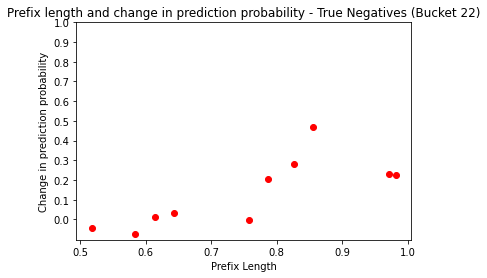

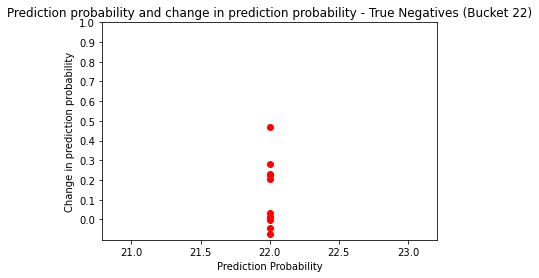

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

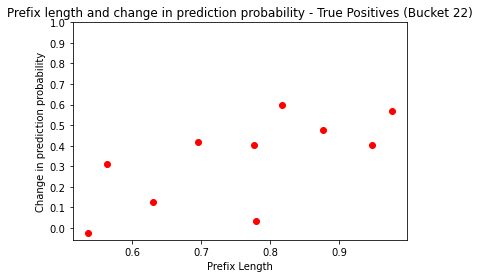

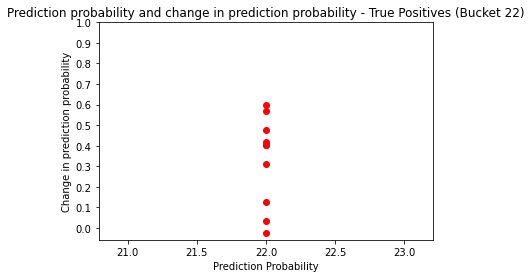

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

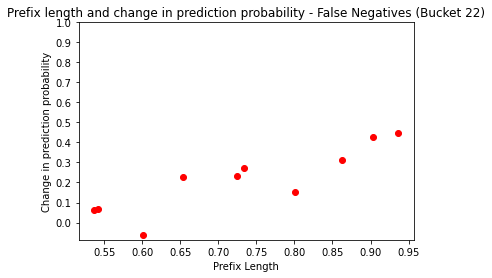

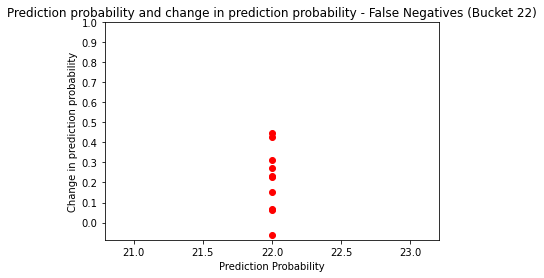

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 143
Creating distribution for feature 2 of 143
Creating distribution for feature 3 of 143
Creating distribution for feature 4 of 143
Creating distribution for feature 5 of 143
Creating distribution for feature 6 of 143
Creating distribution for feature 7 of 143
Creating distribution for feature 8 of 143
Creating distribution for feature 9 of 143
Creating distribution for feature 10 of 143
Creating distribution for feature 11 of 143
Creating distribution for feature 12 of 143
Creating distribution for feature 13 of 143
Creating distribution for feature 14 of 143
Creating distribution for feature 15 of 143
Creating distribution for feature 16 of 143
Creating distribution for feature 17 of 143
Creating distribution for feature 18 of 143
Creating distribution for feature 19 of 143
Creating distribution for feature 20 of 143
Creating distribution for feature 21 of 143
Creating distribution for feature

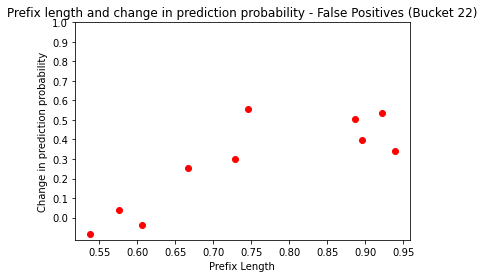

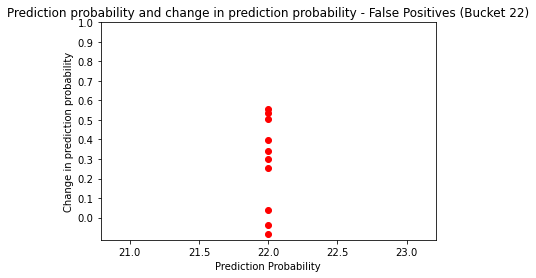

Bucket 23
Generating distributions for bucket
1 of 1508 features
2 of 1508 features
3 of 1508 features
4 of 1508 features
5 of 1508 features
6 of 1508 features
7 of 1508 features
8 of 1508 features
9 of 1508 features
10 of 1508 features
11 of 1508 features
12 of 1508 features
13 of 1508 features
14 of 1508 features
15 of 1508 features
16 of 1508 features
17 of 1508 features
18 of 1508 features
19 of 1508 features
20 of 1508 features
21 of 1508 features
22 of 1508 features
23 of 1508 features
24 of 1508 features
25 of 1508 features
26 of 1508 features
27 of 1508 features
28 of 1508 features
29 of 1508 features
30 of 1508 features
31 of 1508 features
32 of 1508 features
33 of 1508 features
34 of 1508 features
35 of 1508 features
36 of 1508 features
37 of 1508 features
38 of 1508 features
39 of 1508 features
40 of 1508 features
41 of 1508 features
42 of 1508 features
43 of 1508 features
44 of 1508 features
45 of 1508 features
46 of 1508 features
47 of 1508 features
48 of 1508 features
49 

395 of 1508 features
396 of 1508 features
397 of 1508 features
398 of 1508 features
399 of 1508 features
400 of 1508 features
401 of 1508 features
402 of 1508 features
403 of 1508 features
404 of 1508 features
405 of 1508 features
406 of 1508 features
407 of 1508 features
408 of 1508 features
409 of 1508 features
410 of 1508 features
411 of 1508 features
412 of 1508 features
413 of 1508 features
414 of 1508 features
415 of 1508 features
416 of 1508 features
417 of 1508 features
418 of 1508 features
419 of 1508 features
420 of 1508 features
421 of 1508 features
422 of 1508 features
423 of 1508 features
424 of 1508 features
425 of 1508 features
426 of 1508 features
427 of 1508 features
428 of 1508 features
429 of 1508 features
430 of 1508 features
431 of 1508 features
432 of 1508 features
433 of 1508 features
434 of 1508 features
435 of 1508 features
436 of 1508 features
437 of 1508 features
438 of 1508 features
439 of 1508 features
440 of 1508 features
441 of 1508 features
442 of 1508 f

786 of 1508 features
787 of 1508 features
788 of 1508 features
789 of 1508 features
790 of 1508 features
791 of 1508 features
792 of 1508 features
793 of 1508 features
794 of 1508 features
795 of 1508 features
796 of 1508 features
797 of 1508 features
798 of 1508 features
799 of 1508 features
800 of 1508 features
801 of 1508 features
802 of 1508 features
803 of 1508 features
804 of 1508 features
805 of 1508 features
806 of 1508 features
807 of 1508 features
808 of 1508 features
809 of 1508 features
810 of 1508 features
811 of 1508 features
812 of 1508 features
813 of 1508 features
814 of 1508 features
815 of 1508 features
816 of 1508 features
817 of 1508 features
818 of 1508 features
819 of 1508 features
820 of 1508 features
821 of 1508 features
822 of 1508 features
823 of 1508 features
824 of 1508 features
825 of 1508 features
826 of 1508 features
827 of 1508 features
828 of 1508 features
829 of 1508 features
830 of 1508 features
831 of 1508 features
832 of 1508 features
833 of 1508 f

1171 of 1508 features
1172 of 1508 features
1173 of 1508 features
1174 of 1508 features
1175 of 1508 features
1176 of 1508 features
1177 of 1508 features
1178 of 1508 features
1179 of 1508 features
1180 of 1508 features
1181 of 1508 features
1182 of 1508 features
1183 of 1508 features
1184 of 1508 features
1185 of 1508 features
1186 of 1508 features
1187 of 1508 features
1188 of 1508 features
1189 of 1508 features
1190 of 1508 features
1191 of 1508 features
1192 of 1508 features
1193 of 1508 features
1194 of 1508 features
1195 of 1508 features
1196 of 1508 features
1197 of 1508 features
1198 of 1508 features
1199 of 1508 features
1200 of 1508 features
1201 of 1508 features
1202 of 1508 features
1203 of 1508 features
1204 of 1508 features
1205 of 1508 features
1206 of 1508 features
1207 of 1508 features
1208 of 1508 features
1209 of 1508 features
1210 of 1508 features
1211 of 1508 features
1212 of 1508 features
1213 of 1508 features
1214 of 1508 features
1215 of 1508 features
1216 of 15

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

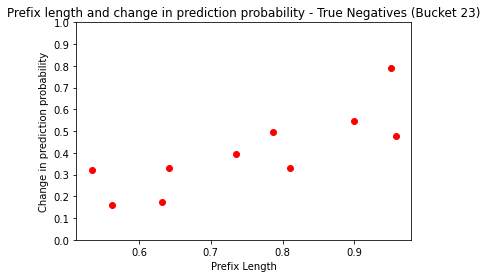

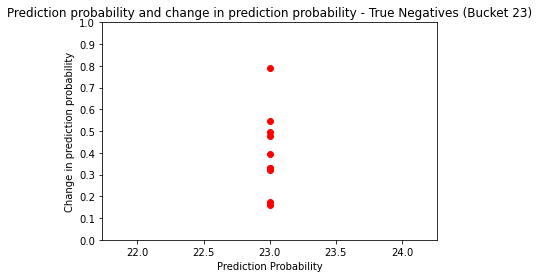

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

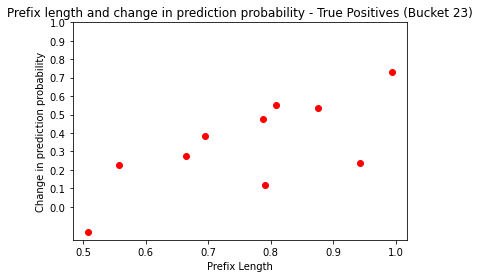

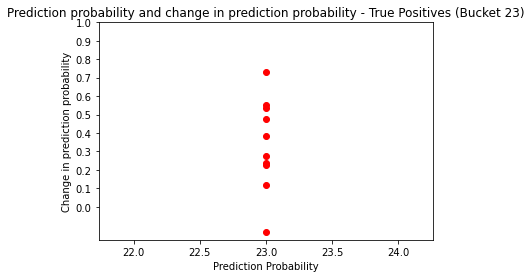

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

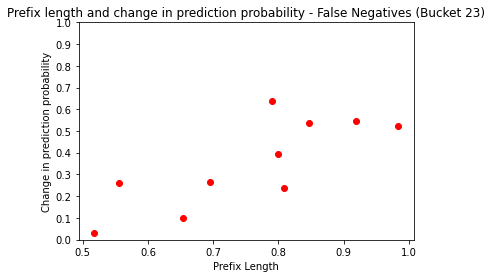

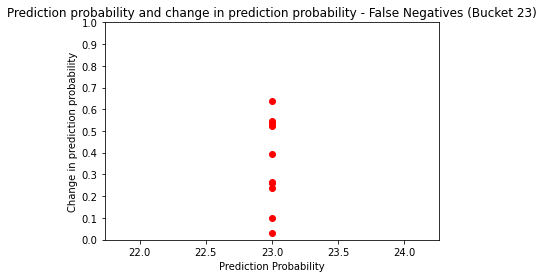

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 151
Creating distribution for feature 2 of 151
Creating distribution for feature 3 of 151
Creating distribution for feature 4 of 151
Creating distribution for feature 5 of 151
Creating distribution for feature 6 of 151
Creating distribution for feature 7 of 151
Creating distribution for feature 8 of 151
Creating distribution for feature 9 of 151
Creating distribution for feature 10 of 151
Creating distribution for feature 11 of 151
Creating distribution for feature 12 of 151
Creating distribution for feature 13 of 151
Creating distribution for feature 14 of 151
Creating distribution for feature 15 of 151
Creating distribution for feature 16 of 151
Creating distribution for feature 17 of 151
Creating distribution for feature 18 of 151
Creating distribution for feature 19 of 151
Creating distribution for feature 20 of 151
Creating distribution for feature 21 of 151
Creating distribution for feature

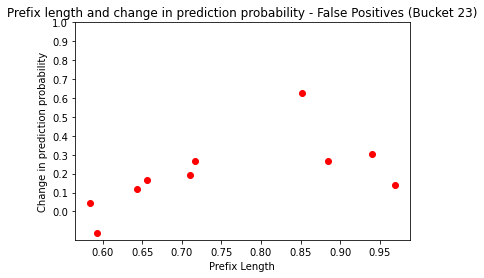

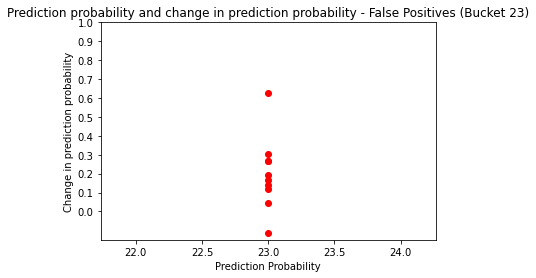

Bucket 24
Generating distributions for bucket
1 of 1573 features
2 of 1573 features
3 of 1573 features
4 of 1573 features
5 of 1573 features
6 of 1573 features
7 of 1573 features
8 of 1573 features
9 of 1573 features
10 of 1573 features
11 of 1573 features
12 of 1573 features
13 of 1573 features
14 of 1573 features
15 of 1573 features
16 of 1573 features
17 of 1573 features
18 of 1573 features
19 of 1573 features
20 of 1573 features
21 of 1573 features
22 of 1573 features
23 of 1573 features
24 of 1573 features
25 of 1573 features
26 of 1573 features
27 of 1573 features
28 of 1573 features
29 of 1573 features
30 of 1573 features
31 of 1573 features
32 of 1573 features
33 of 1573 features
34 of 1573 features
35 of 1573 features
36 of 1573 features
37 of 1573 features
38 of 1573 features
39 of 1573 features
40 of 1573 features
41 of 1573 features
42 of 1573 features
43 of 1573 features
44 of 1573 features
45 of 1573 features
46 of 1573 features
47 of 1573 features
48 of 1573 features
49 

396 of 1573 features
397 of 1573 features
398 of 1573 features
399 of 1573 features
400 of 1573 features
401 of 1573 features
402 of 1573 features
403 of 1573 features
404 of 1573 features
405 of 1573 features
406 of 1573 features
407 of 1573 features
408 of 1573 features
409 of 1573 features
410 of 1573 features
411 of 1573 features
412 of 1573 features
413 of 1573 features
414 of 1573 features
415 of 1573 features
416 of 1573 features
417 of 1573 features
418 of 1573 features
419 of 1573 features
420 of 1573 features
421 of 1573 features
422 of 1573 features
423 of 1573 features
424 of 1573 features
425 of 1573 features
426 of 1573 features
427 of 1573 features
428 of 1573 features
429 of 1573 features
430 of 1573 features
431 of 1573 features
432 of 1573 features
433 of 1573 features
434 of 1573 features
435 of 1573 features
436 of 1573 features
437 of 1573 features
438 of 1573 features
439 of 1573 features
440 of 1573 features
441 of 1573 features
442 of 1573 features
443 of 1573 f

792 of 1573 features
793 of 1573 features
794 of 1573 features
795 of 1573 features
796 of 1573 features
797 of 1573 features
798 of 1573 features
799 of 1573 features
800 of 1573 features
801 of 1573 features
802 of 1573 features
803 of 1573 features
804 of 1573 features
805 of 1573 features
806 of 1573 features
807 of 1573 features
808 of 1573 features
809 of 1573 features
810 of 1573 features
811 of 1573 features
812 of 1573 features
813 of 1573 features
814 of 1573 features
815 of 1573 features
816 of 1573 features
817 of 1573 features
818 of 1573 features
819 of 1573 features
820 of 1573 features
821 of 1573 features
822 of 1573 features
823 of 1573 features
824 of 1573 features
825 of 1573 features
826 of 1573 features
827 of 1573 features
828 of 1573 features
829 of 1573 features
830 of 1573 features
831 of 1573 features
832 of 1573 features
833 of 1573 features
834 of 1573 features
835 of 1573 features
836 of 1573 features
837 of 1573 features
838 of 1573 features
839 of 1573 f

1174 of 1573 features
1175 of 1573 features
1176 of 1573 features
1177 of 1573 features
1178 of 1573 features
1179 of 1573 features
1180 of 1573 features
1181 of 1573 features
1182 of 1573 features
1183 of 1573 features
1184 of 1573 features
1185 of 1573 features
1186 of 1573 features
1187 of 1573 features
1188 of 1573 features
1189 of 1573 features
1190 of 1573 features
1191 of 1573 features
1192 of 1573 features
1193 of 1573 features
1194 of 1573 features
1195 of 1573 features
1196 of 1573 features
1197 of 1573 features
1198 of 1573 features
1199 of 1573 features
1200 of 1573 features
1201 of 1573 features
1202 of 1573 features
1203 of 1573 features
1204 of 1573 features
1205 of 1573 features
1206 of 1573 features
1207 of 1573 features
1208 of 1573 features
1209 of 1573 features
1210 of 1573 features
1211 of 1573 features
1212 of 1573 features
1213 of 1573 features
1214 of 1573 features
1215 of 1573 features
1216 of 1573 features
1217 of 1573 features
1218 of 1573 features
1219 of 15

1549 of 1573 features
1550 of 1573 features
1551 of 1573 features
1552 of 1573 features
1553 of 1573 features
1554 of 1573 features
1555 of 1573 features
1556 of 1573 features
1557 of 1573 features
1558 of 1573 features
1559 of 1573 features
1560 of 1573 features
1561 of 1573 features
1562 of 1573 features
1563 of 1573 features
1564 of 1573 features
1565 of 1573 features
1566 of 1573 features
1567 of 1573 features
1568 of 1573 features
1569 of 1573 features
1570 of 1573 features
1571 of 1573 features
1572 of 1573 features
1573 of 1573 features
Category 1 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distributio

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

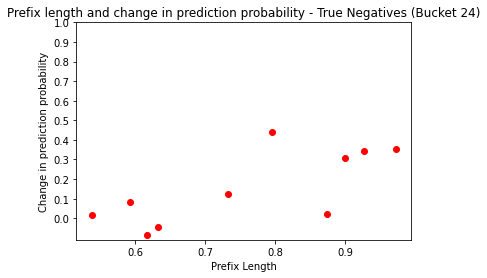

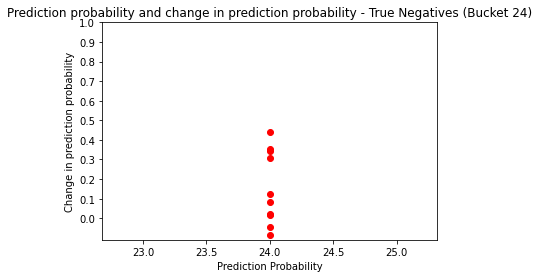

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

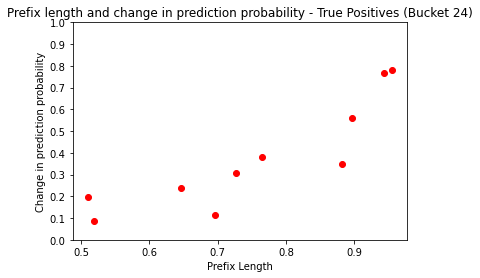

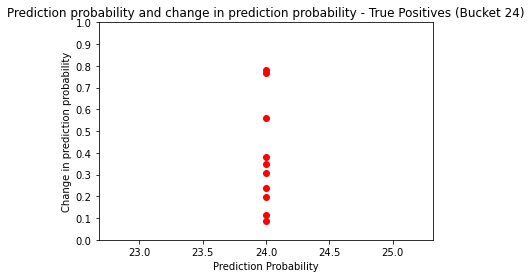

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

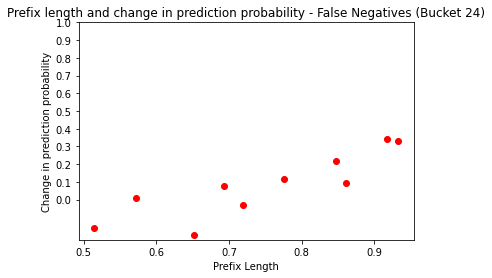

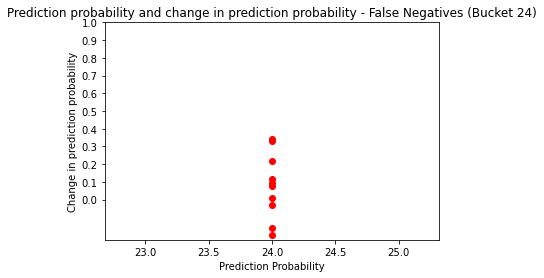

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 157
Creating distribution for feature 2 of 157
Creating distribution for feature 3 of 157
Creating distribution for feature 4 of 157
Creating distribution for feature 5 of 157
Creating distribution for feature 6 of 157
Creating distribution for feature 7 of 157
Creating distribution for feature 8 of 157
Creating distribution for feature 9 of 157
Creating distribution for feature 10 of 157
Creating distribution for feature 11 of 157
Creating distribution for feature 12 of 157
Creating distribution for feature 13 of 157
Creating distribution for feature 14 of 157
Creating distribution for feature 15 of 157
Creating distribution for feature 16 of 157
Creating distribution for feature 17 of 157
Creating distribution for feature 18 of 157
Creating distribution for feature 19 of 157
Creating distribution for feature 20 of 157
Creating distribution for feature 21 of 157
Creating distribution for feature

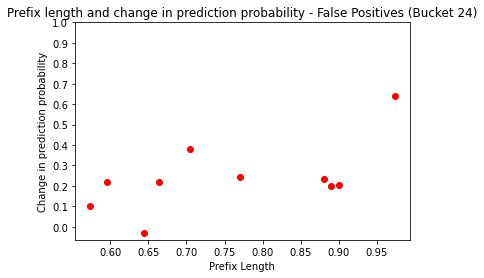

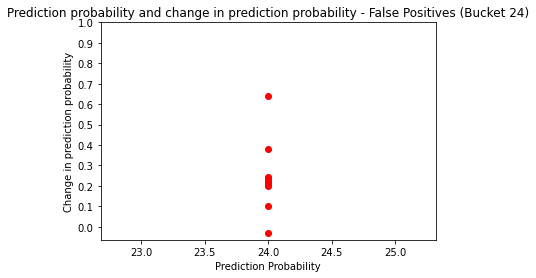

Bucket 25
Generating distributions for bucket
1 of 1654 features
2 of 1654 features
3 of 1654 features
4 of 1654 features
5 of 1654 features
6 of 1654 features
7 of 1654 features
8 of 1654 features
9 of 1654 features
10 of 1654 features
11 of 1654 features
12 of 1654 features
13 of 1654 features
14 of 1654 features
15 of 1654 features
16 of 1654 features
17 of 1654 features
18 of 1654 features
19 of 1654 features
20 of 1654 features
21 of 1654 features
22 of 1654 features
23 of 1654 features
24 of 1654 features
25 of 1654 features
26 of 1654 features
27 of 1654 features
28 of 1654 features
29 of 1654 features
30 of 1654 features
31 of 1654 features
32 of 1654 features
33 of 1654 features
34 of 1654 features
35 of 1654 features
36 of 1654 features
37 of 1654 features
38 of 1654 features
39 of 1654 features
40 of 1654 features
41 of 1654 features
42 of 1654 features
43 of 1654 features
44 of 1654 features
45 of 1654 features
46 of 1654 features
47 of 1654 features
48 of 1654 features
49 

398 of 1654 features
399 of 1654 features
400 of 1654 features
401 of 1654 features
402 of 1654 features
403 of 1654 features
404 of 1654 features
405 of 1654 features
406 of 1654 features
407 of 1654 features
408 of 1654 features
409 of 1654 features
410 of 1654 features
411 of 1654 features
412 of 1654 features
413 of 1654 features
414 of 1654 features
415 of 1654 features
416 of 1654 features
417 of 1654 features
418 of 1654 features
419 of 1654 features
420 of 1654 features
421 of 1654 features
422 of 1654 features
423 of 1654 features
424 of 1654 features
425 of 1654 features
426 of 1654 features
427 of 1654 features
428 of 1654 features
429 of 1654 features
430 of 1654 features
431 of 1654 features
432 of 1654 features
433 of 1654 features
434 of 1654 features
435 of 1654 features
436 of 1654 features
437 of 1654 features
438 of 1654 features
439 of 1654 features
440 of 1654 features
441 of 1654 features
442 of 1654 features
443 of 1654 features
444 of 1654 features
445 of 1654 f

790 of 1654 features
791 of 1654 features
792 of 1654 features
793 of 1654 features
794 of 1654 features
795 of 1654 features
796 of 1654 features
797 of 1654 features
798 of 1654 features
799 of 1654 features
800 of 1654 features
801 of 1654 features
802 of 1654 features
803 of 1654 features
804 of 1654 features
805 of 1654 features
806 of 1654 features
807 of 1654 features
808 of 1654 features
809 of 1654 features
810 of 1654 features
811 of 1654 features
812 of 1654 features
813 of 1654 features
814 of 1654 features
815 of 1654 features
816 of 1654 features
817 of 1654 features
818 of 1654 features
819 of 1654 features
820 of 1654 features
821 of 1654 features
822 of 1654 features
823 of 1654 features
824 of 1654 features
825 of 1654 features
826 of 1654 features
827 of 1654 features
828 of 1654 features
829 of 1654 features
830 of 1654 features
831 of 1654 features
832 of 1654 features
833 of 1654 features
834 of 1654 features
835 of 1654 features
836 of 1654 features
837 of 1654 f

1176 of 1654 features
1177 of 1654 features
1178 of 1654 features
1179 of 1654 features
1180 of 1654 features
1181 of 1654 features
1182 of 1654 features
1183 of 1654 features
1184 of 1654 features
1185 of 1654 features
1186 of 1654 features
1187 of 1654 features
1188 of 1654 features
1189 of 1654 features
1190 of 1654 features
1191 of 1654 features
1192 of 1654 features
1193 of 1654 features
1194 of 1654 features
1195 of 1654 features
1196 of 1654 features
1197 of 1654 features
1198 of 1654 features
1199 of 1654 features
1200 of 1654 features
1201 of 1654 features
1202 of 1654 features
1203 of 1654 features
1204 of 1654 features
1205 of 1654 features
1206 of 1654 features
1207 of 1654 features
1208 of 1654 features
1209 of 1654 features
1210 of 1654 features
1211 of 1654 features
1212 of 1654 features
1213 of 1654 features
1214 of 1654 features
1215 of 1654 features
1216 of 1654 features
1217 of 1654 features
1218 of 1654 features
1219 of 1654 features
1220 of 1654 features
1221 of 16

1549 of 1654 features
1550 of 1654 features
1551 of 1654 features
1552 of 1654 features
1553 of 1654 features
1554 of 1654 features
1555 of 1654 features
1556 of 1654 features
1557 of 1654 features
1558 of 1654 features
1559 of 1654 features
1560 of 1654 features
1561 of 1654 features
1562 of 1654 features
1563 of 1654 features
1564 of 1654 features
1565 of 1654 features
1566 of 1654 features
1567 of 1654 features
1568 of 1654 features
1569 of 1654 features
1570 of 1654 features
1571 of 1654 features
1572 of 1654 features
1573 of 1654 features
1574 of 1654 features
1575 of 1654 features
1576 of 1654 features
1577 of 1654 features
1578 of 1654 features
1579 of 1654 features
1580 of 1654 features
1581 of 1654 features
1582 of 1654 features
1583 of 1654 features
1584 of 1654 features
1585 of 1654 features
1586 of 1654 features
1587 of 1654 features
1588 of 1654 features
1589 of 1654 features
1590 of 1654 features
1591 of 1654 features
1592 of 1654 features
1593 of 1654 features
1594 of 16

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

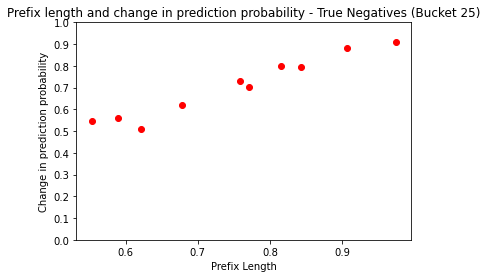

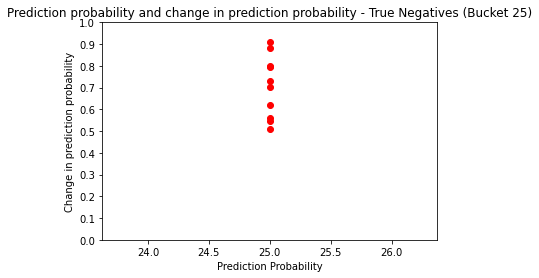

Category 2 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

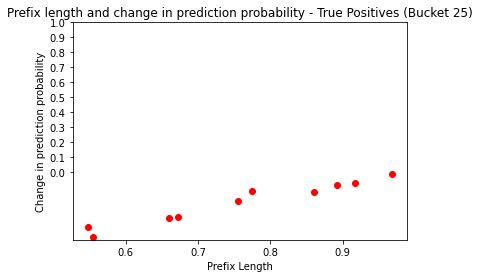

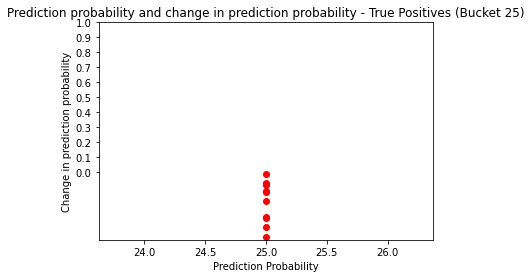

Category 3 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

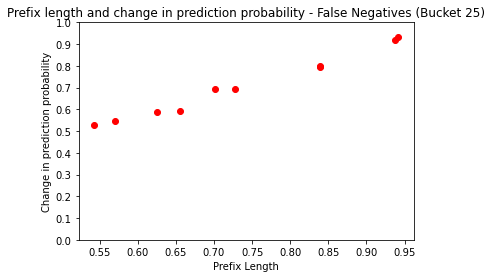

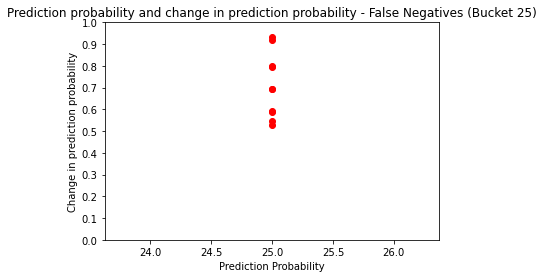

Category 4 of 4. Instance 1 of 10
Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

Creating explanations
Identifying relevant features
Creating distribution for feature 1 of 165
Creating distribution for feature 2 of 165
Creating distribution for feature 3 of 165
Creating distribution for feature 4 of 165
Creating distribution for feature 5 of 165
Creating distribution for feature 6 of 165
Creating distribution for feature 7 of 165
Creating distribution for feature 8 of 165
Creating distribution for feature 9 of 165
Creating distribution for feature 10 of 165
Creating distribution for feature 11 of 165
Creating distribution for feature 12 of 165
Creating distribution for feature 13 of 165
Creating distribution for feature 14 of 165
Creating distribution for feature 15 of 165
Creating distribution for feature 16 of 165
Creating distribution for feature 17 of 165
Creating distribution for feature 18 of 165
Creating distribution for feature 19 of 165
Creating distribution for feature 20 of 165
Creating distribution for feature 21 of 165
Creating distribution for feature

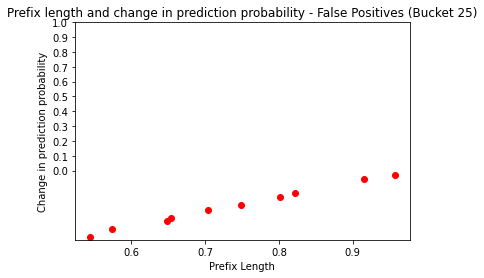

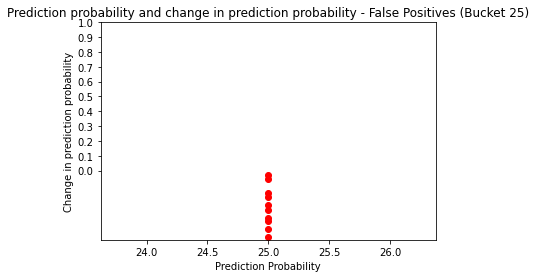

In [10]:
if generate_model_shap:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            
            buckets = range(0, max_prefix, gap)

            all_shap_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_shap_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_shap_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_test_path = os.path.join(PATH, "%s/%s_%s/test_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_test_path, 'rb') as f:
                    dt_test_bucket = pickle.load(f)
                with open (Y_test_path, 'rb') as f:
                    test_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)

                tree_explainer = shap.TreeExplainer(cls)
                test_x = feature_combiner.fit_transform(dt_test_bucket)
                feat_list = feature_combiner.get_feature_names()
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']
                max_feat = round(len(feat_list)*0.1)
                #print(max_feat)
                
                print("Generating distributions for bucket")
                distribs = generate_distributions(tree_explainer, feat_list, test_x)

                for i_type in range(len(sample_instances)):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for n in range(len(sample_instances[i_type])):
                        print("Category %s of %s. Instance %s of %s" %(i_type+1, len(sample_instances), n+1, len(sample_instances[i_type])))
                        instance = sample_instances[i_type][n]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        #test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        print("Creating explanations")
                        exp, rel_exp = create_samples(tree_explainer, exp_iter, test_x_group, feat_list, top = max_feat)

                        features = []
                        shap_vals = []
                        
                        print("Identifying relevant features")
                        for explanation in rel_exp:
                            features.extend([feat[0] for feat in explanation])
                            shap_vals.extend([feat for feat in explanation])

                        counter = Counter(features).most_common(max_feat)

                        feats = [feat[0] for feat in counter]

                        rel_feats = []
                        for feat in feats:
                            vals = [i[1] for i in shap_vals if i[0] == feat]
                            #print(feat, vals)
                            val = np.mean(vals)
                            rel_feats.append((feat, val))

                        intervals = []
                        for item in rel_feats:
                            feat = item [0]
                            val = item[1]

                            print("Creating distribution for feature", rel_feats.index(item)+1, "of", len(rel_feats))

                            n = feat_list.index(feat)
                            feat_dict = distribs[n]

                            if feat_dict['Feature Name'] != feat:
                                for each in distribs:
                                    if feat_dict['Feature Name'] == feat:
                                        feat_dict = each

                            bins = feat_dict['bins']
                            mins = feat_dict['mins']
                            maxes = feat_dict['maxes']
                            #print (feat, val, bins, mins, maxes)

                            i = 0
                            while val > bins[i] and i < len(bins)-1:
                                idx = i
                                i+=1
                            #print (i)
                            if mins[i] != None:
                                min_val = mins[i]
                                max_val = maxes[i]
                            else:
                                j = i
                                while mins[j] == None and j > 0:
                                    min_val = mins[j-1]
                                    max_val = maxes[j-1]
                                    j = j-1

                            interval = max_val - min_val
                            if interval == 0:
                                interval = 1

                            index = feat_list.index(feat)
                            int_min = max_val
                            int_max = max_val + interval
                            intervals.append((feat, index, int_min, int_max))


                        diffs = []

                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))

                        instance['shap_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_shap_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_shap_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(probas, changes, 'ro', label = "SHAP")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(nr_events, changes, 'ro', label = "SHAP")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i_type], bucketID))
                    plt.show()

                    all_shap_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

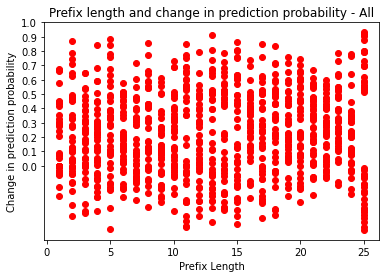

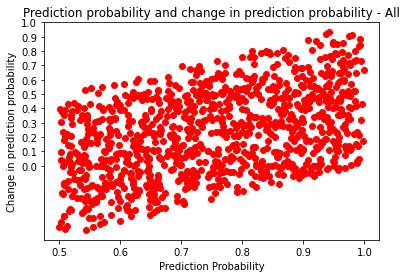

In [11]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_shap_changes, 'ro', label = "SHAP")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

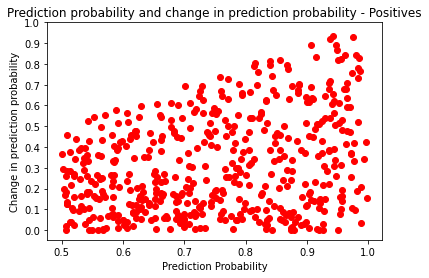

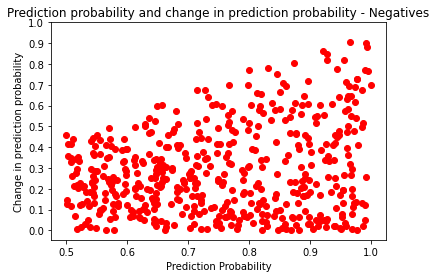

In [12]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_shap_changes, 'ro', label = "SHAP")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

Bucket 1
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 4 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertub

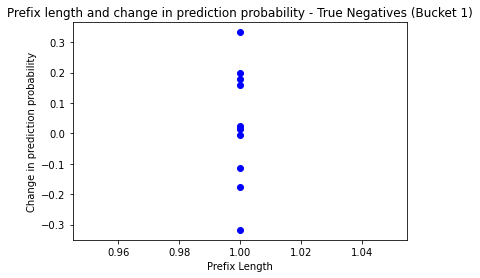

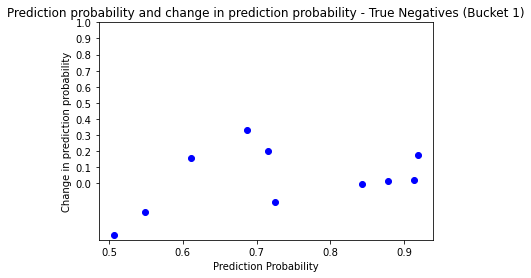

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 4 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run

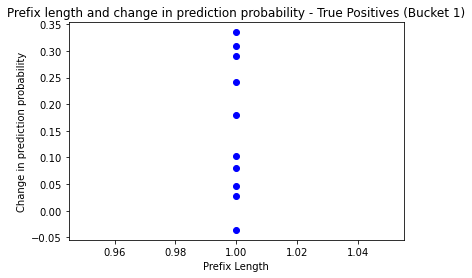

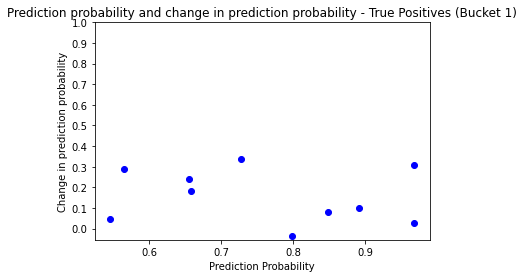

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 4 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run

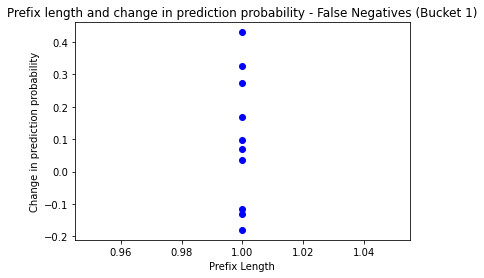

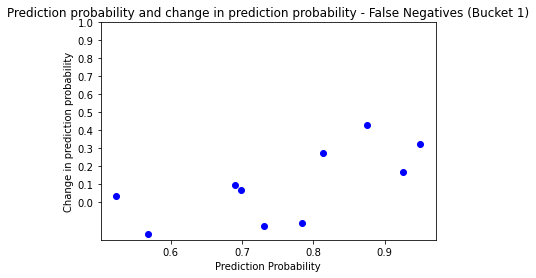

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 4 of 10
Creating distribution for feature 0
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run

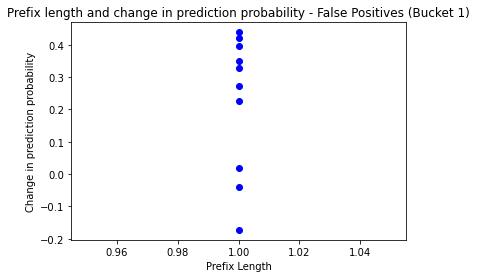

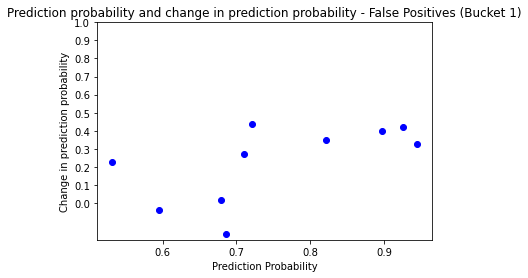

Bucket 2
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 4 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertub

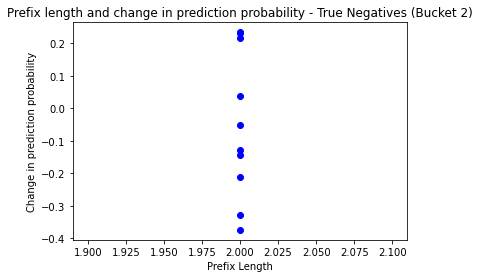

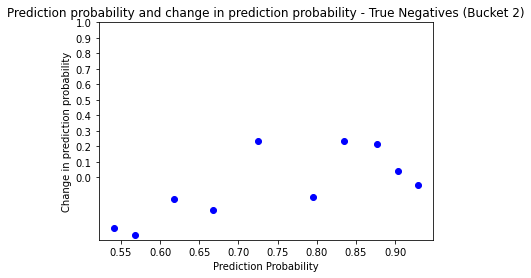

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 4 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run

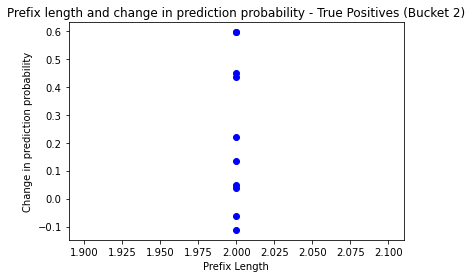

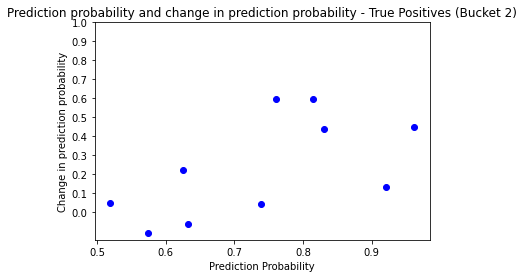

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 4 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run

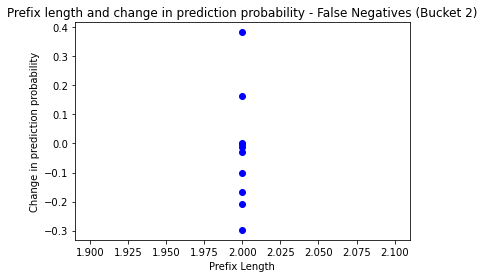

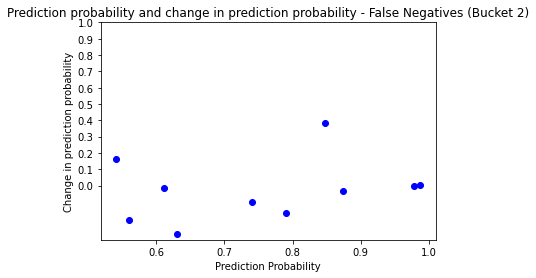

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 4 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Pertubing - Run 1
Pertubing - Run

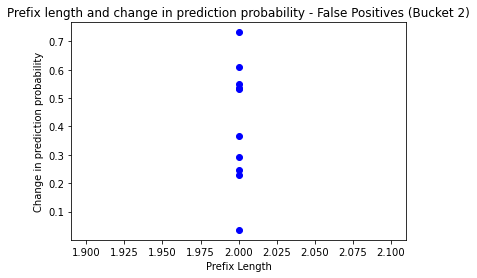

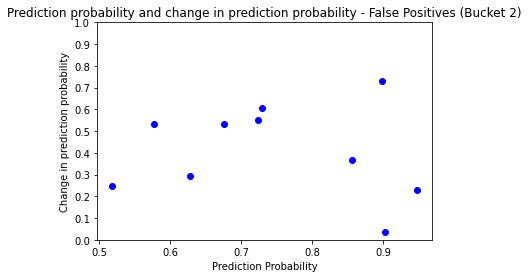

Bucket 3
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Insta

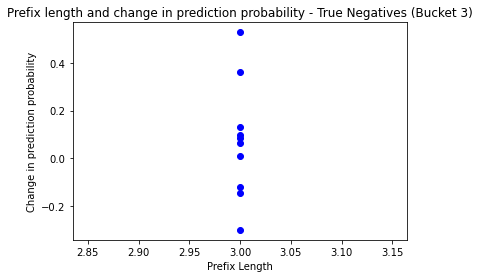

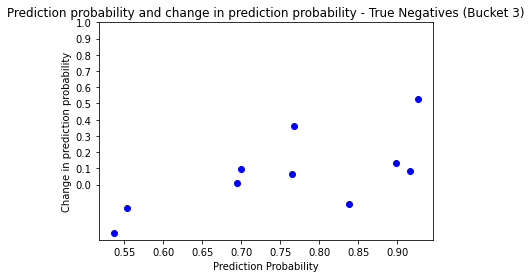

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 4 of 

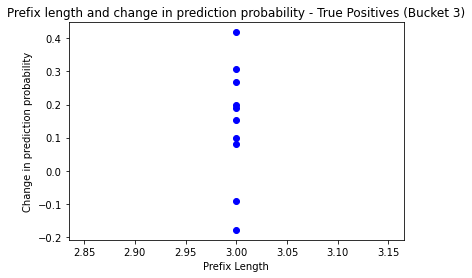

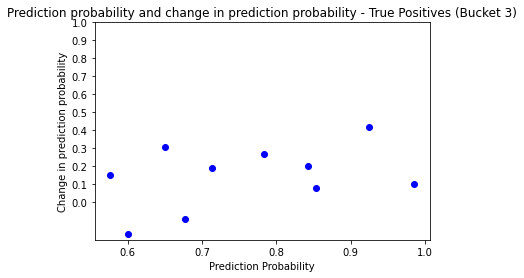

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 4 of 

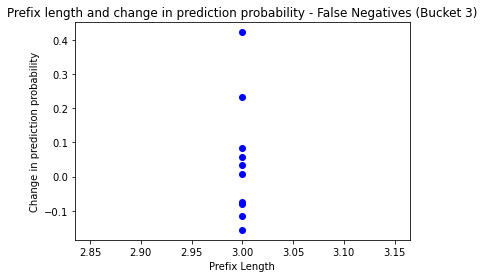

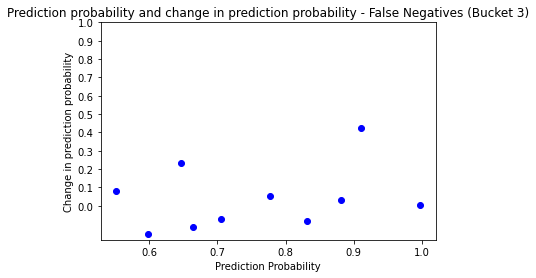

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 3 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 4 of 

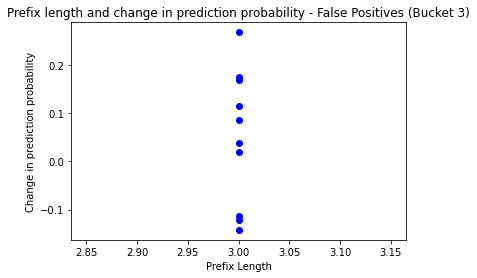

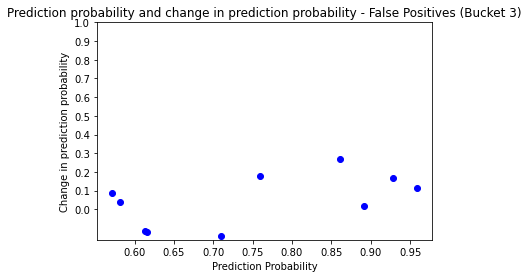

Bucket 4
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pert

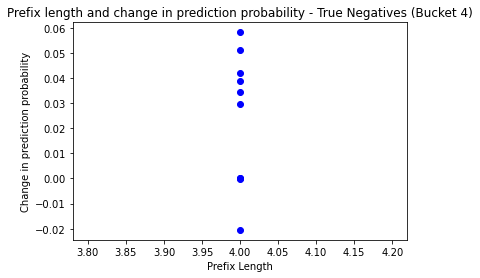

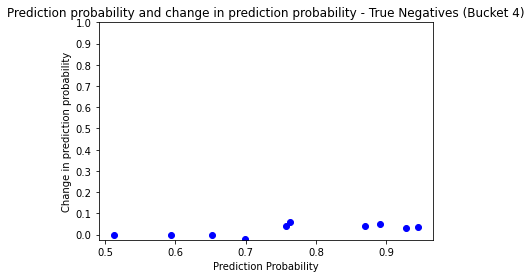

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - R

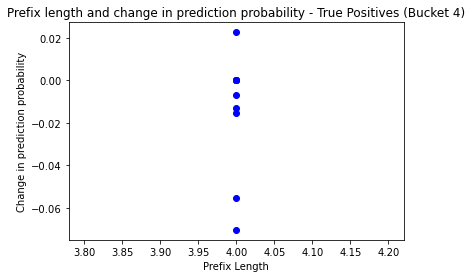

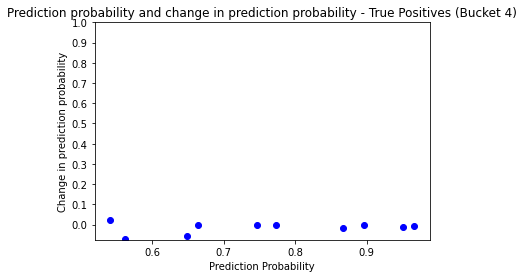

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - R

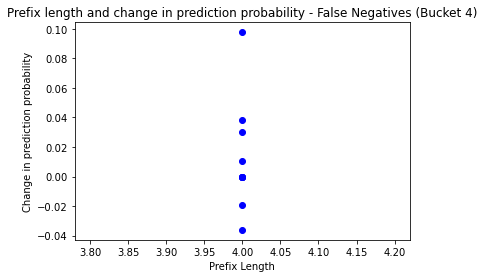

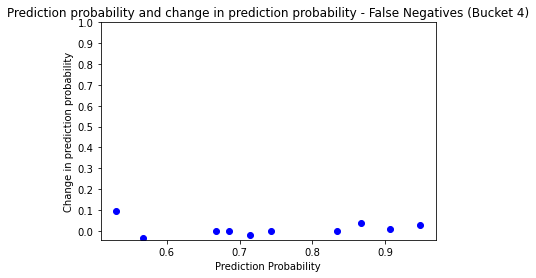

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - R

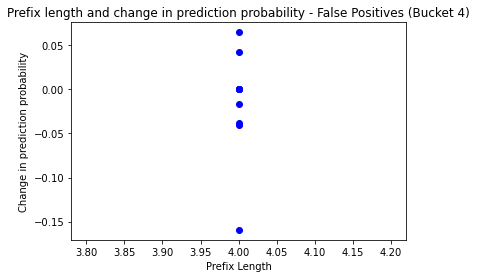

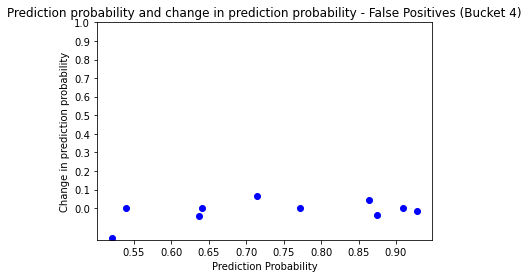

Bucket 5
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 1 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribu

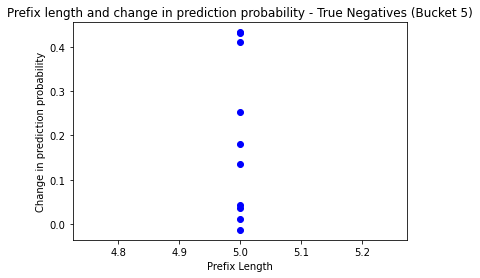

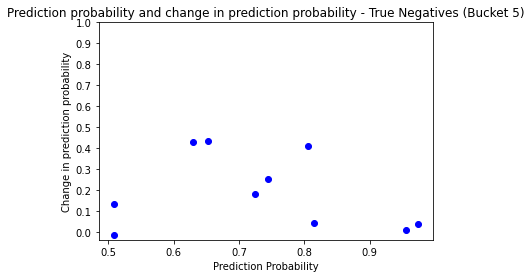

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for 

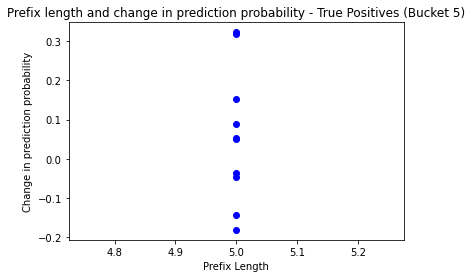

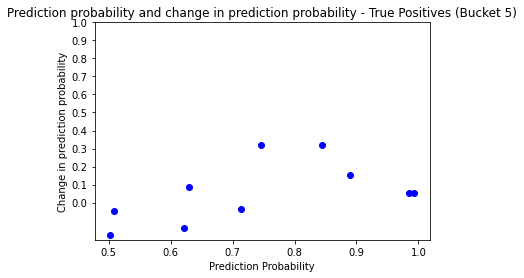

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for 

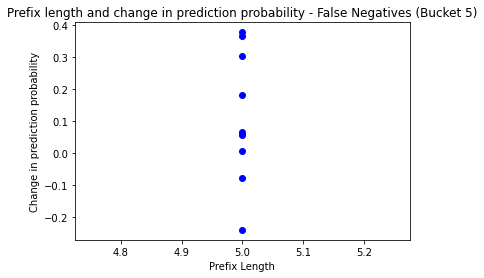

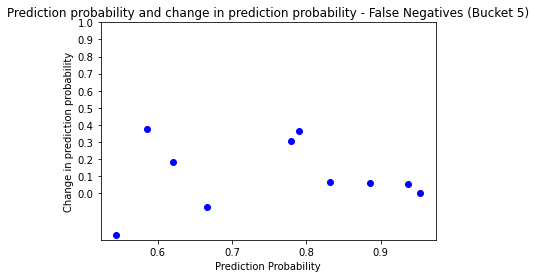

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. Instance 2 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for 

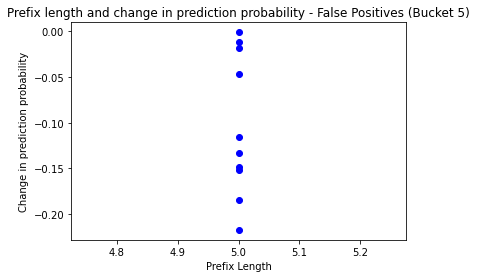

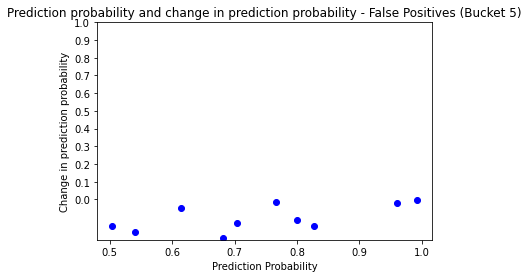

Bucket 6
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


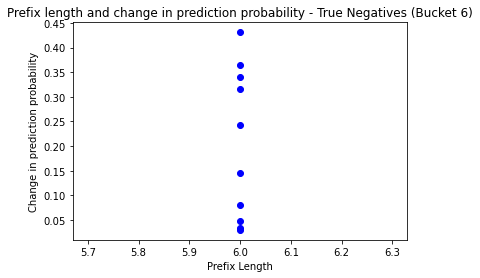

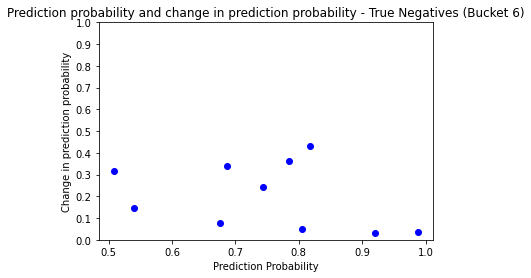

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 2 of 4. I

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


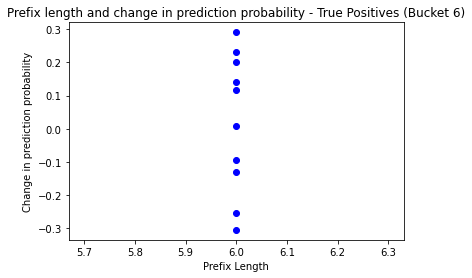

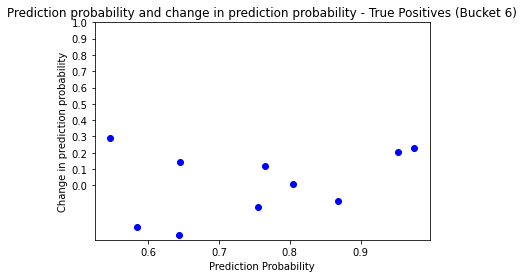

Category 3 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 3 of 4. I

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


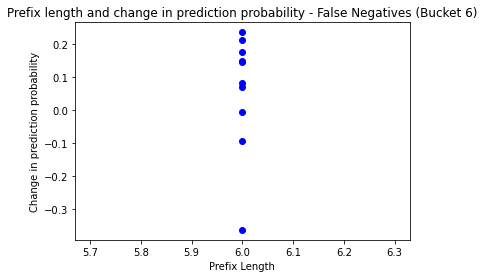

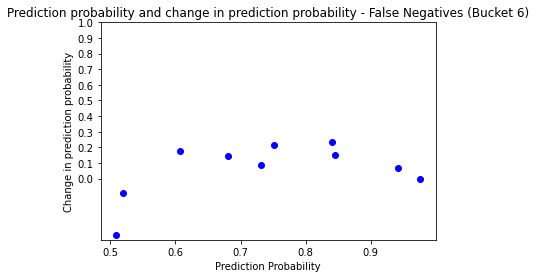

Category 4 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10
Category 4 of 4. I

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Pertubing - Run 1
Pertubing - Run 2
Pertubing - Run 3
Pertubing - Run 4
Pertubing - Run 5
Pertubing - Run 6
Pertubing - Run 7
Pertubing - Run 8
Pertubing - Run 9
Pertubing - Run 10


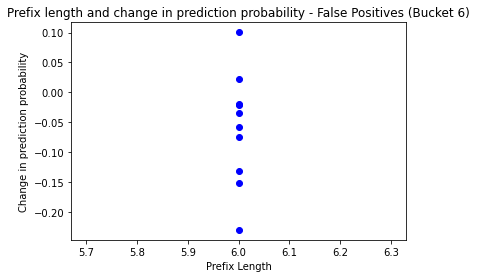

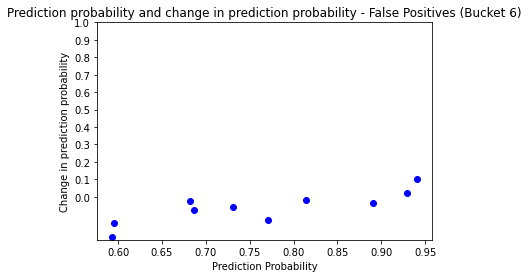

Bucket 7
Category 1 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creat

Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distribution for feature 26
Creating di

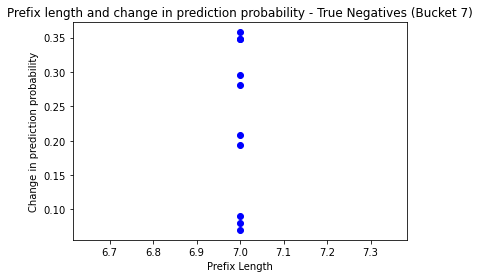

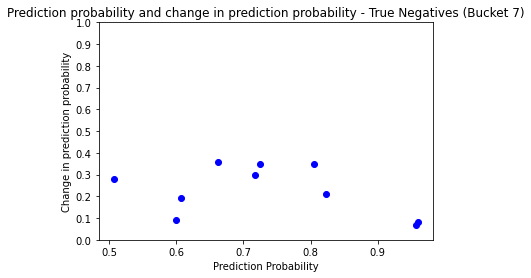

Category 2 of 4. Instance 1 of 10
Creating distribution for feature 0
Creating distribution for feature 1
Creating distribution for feature 2
Creating distribution for feature 3
Creating distribution for feature 4
Creating distribution for feature 5
Creating distribution for feature 6
Creating distribution for feature 7
Creating distribution for feature 8
Creating distribution for feature 9
Creating distribution for feature 10
Creating distribution for feature 11
Creating distribution for feature 12
Creating distribution for feature 13
Creating distribution for feature 14
Creating distribution for feature 15
Creating distribution for feature 16
Creating distribution for feature 17
Creating distribution for feature 18
Creating distribution for feature 19
Creating distribution for feature 20
Creating distribution for feature 21
Creating distribution for feature 22
Creating distribution for feature 23
Creating distribution for feature 24
Creating distribution for feature 25
Creating distr

In [ ]:
if generate_lime:
    for dataset_name in datasets:

        dataset_manager = DatasetManager(dataset_name)

        for ii in range(n_iter):
            num_buckets = len([name for name in os.listdir(os.path.join(PATH,'%s/%s_%s/models'% (dataset_ref, cls_method, method_name)))])
            
            if num_buckets < max_prefix:
                max_prefix = num_buckets
            buckets = range(0, max_prefix, gap)

            all_lime_changes = []
            all_lens = []
            all_probas = []
            all_case_ids = []

            pos_lime_changes = []
            pos_probas = []
            pos_nr_events = []
            pos_case_ids = []

            neg_lime_changes = []
            neg_probas = []
            neg_nr_events = []
            neg_case_ids = []

            for bucket in buckets:
                bucketID = bucket+1
                print ('Bucket', bucketID)

                #import everything needed to sort and predict
                feat_comb_path = os.path.join(PATH, "%s/%s_%s/bucketers_and_encoders/feature_combiner_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls_path = os.path.join(PATH, "%s/%s_%s/models/cls_bucket_%s.joblib" % (dataset_ref, cls_method, method_name, bucketID))
                cls = joblib.load(cls_path)
                feature_combiner = joblib.load(feat_comb_path)

                #import data for bucket
                X_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_prefixes.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                Y_train_path = os.path.join(PATH, "%s/%s_%s/train_data/bucket_%s_labels.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                with open (X_train_path, 'rb') as f:
                    dt_train_bucket = pickle.load(f)
                with open (Y_train_path, 'rb') as f:
                    train_y = pickle.load(f)
                #with open (X_test_path, 'rb') as f:
                #    dt_test_bucket = pickle.load(f)
                #with open (Y_test_path, 'rb') as f:
                #    test_y = pickle.load(f)

                #import previously identified samples
                tn_path = os.path.join(PATH, "%s/%s_%s/samples/true_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                tp_path = os.path.join(PATH, "%s/%s_%s/samples/true_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fn_path = os.path.join(PATH, "%s/%s_%s/samples/false_neg_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))
                fp_path = os.path.join(PATH, "%s/%s_%s/samples/false_pos_bucket_%s_.pickle" % (dataset_ref, cls_method, method_name, bucketID))

                sample_instances = []

                with open (tn_path, 'rb') as f:
                    tn_list = pickle.load(f)
                with open (tp_path, 'rb') as f:
                    tp_list = pickle.load(f)
                with open (fn_path, 'rb') as f:
                    fn_list = pickle.load(f)
                with open (fp_path, 'rb') as f:
                    fp_list = pickle.load(f)

                #save results to a list
                sample_instances.append(tn_list)
                sample_instances.append(tp_list)
                sample_instances.append(fn_list)
                sample_instances.append(fp_list)
                
                #get the training data as a matrix
                trainingdata = feature_combiner.fit_transform(dt_train_bucket);
                #importance = generate_global_explanations(trainingdata,train_y, cls, feature_combiner)

                feat_list = feature_combiner.get_feature_names()
                max_feat = round(len(feat_list)*0.1)
                class_names=['regular','deviant']# regular is 0, deviant is 1, 0 is left, 1 is right
                lime_explainer = lime.lime_tabular.LimeTabularExplainer(trainingdata, feature_names = feat_list, 
                                                                        class_names=class_names, discretize_continuous=True)
                type_list = ['True Negatives', 'True Positives', 'False Negatives', 'False Positives']

                for i in list(range(len(sample_instances))):
                    changes = []
                    probas = []
                    nr_events = []
                    case_ids = []

                    for j in list(range(len(sample_instances[i]))):
                        print("Category %s of %s. Instance %s of %s" %(i+1, len(sample_instances), j+1, len(sample_instances[i])))
                        instance = sample_instances[i][j]

                        ind = instance['predicted']
                        case_ids.append(instance['caseID'])
                        p1 = instance['proba']
                        probas.append(p1)
                        #print("proba:", p1)
                        nr_events.append(instance['nr_events'])
                        input_ = instance['input']

                        test_x_group = feature_combiner.fit_transform(input_) 
                        test_x=np.transpose(test_x_group[0])
                        #print(test_x)
                        #print(p1)

                        explanations = []
                        for iteration in range(exp_iter):
                            lime_exp = generate_lime_explanations(lime_explainer, test_x, cls, input_, max_feat = max_feat)
                            explanation = lime_exp.as_list()
                            explanations.extend(explanation)

                        features = []
                        for explanation in explanations:
                            features.append(explanation[0])

                        counter = Counter(features)
                        check_dup = []
                        for feat in feat_list:
                            for feature in counter:
                                if feat in feature:
                                    check_dup.append(feat)

                        dup_counter = Counter(check_dup)
                        duplicated = [feat for feat in dup_counter if dup_counter[feat] > 1]

                        for each in duplicated:
                            dpls = []
                            vals = []
                            for feat in counter.keys():
                                if each in feat:
                                    dpls.append(feat)
                                    vals.append(counter[feat])
                            keepval = vals.index(max(vals))
                            for n in range(len(dpls)):
                                if n != keepval:
                                    del counter[dpls[n]]

                        rel_feat = counter.most_common(max_feat)

                        intervals = []

                        for item in rel_feat:
                            print("Creating distribution for feature", rel_feat.index(item))
                            feat = item[0]
                            #print(item)
                            #print(feat)
                            for n in range(len(feat_list)):
                                if feat_list[n] in feat:
                                    if ("<" or "<=") in feat and (">" or ">=") in feat:
                                        two_sided = True
                                        parts = feat.split(' ')
                                        l_bound = float(parts[0])
                                        u_bound = float(parts[-1])
                                        interval = u_bound - l_bound
                                        new_min = u_bound
                                        new_max = u_bound + interval
                                    else:
                                        two_sided = False
                                        parts = feat.split(' ')
                                        if parts[-2] == "<=" or parts[-2] == "<":
                                            u_bound = float(parts[-1])
                                            if u_bound != 0:
                                                interval = math.ceil(u_bound*1.1)
                                            else:
                                                interval = 5
                                            new_min = u_bound
                                            new_max = u_bound + interval
                                        elif parts[-2] == ">=" or parts[-2] == ">":
                                            l_bound = float(parts[-1])
                                            if l_bound != 0:
                                                interval = math.ceil(l_bound*1.1)
                                            else:
                                                interval = 5
                                            new_max = l_bound
                                            new_min = l_bound - interval
                                        else:
                                            bound = float(parts[-1])
                                            interval = math.ceil((bound*1.1)/2)
                                            new_min = bound
                                            new_max = bound+interval
                                    feature_name = feat_list[n]
                                    index = n
                                    int_min = new_min
                                    int_max = new_max
                                    intervals.append((feature_name, index, int_min, int_max))

                        diffs = []
                        for iteration in range(exp_iter):
                            print("Pertubing - Run", iteration+1)
                            alt_x = np.copy(test_x_group)
                            #print("original:", alt_x)
                            for each in intervals:
                                new_val = random.uniform(each[2], each[3])
                                alt_x[0][each[1]] = new_val
                            p2 = cls.predict_proba(alt_x)[0][ind]
                            diff = p1-p2
                            diffs.append(diff)

                        changes.append(np.mean(diffs))
                        
                        instance['lime_fid_change'] = diffs
                        #print("RMSE for instance:", np.std(diffs))


                        if ind == 0:
                            pos_lime_changes.append(abs(diff))#np.std(diffs))
                            pos_probas.append(p1)
                            pos_nr_events.append(instance['nr_events'])
                            pos_case_ids.append(instance['caseID'])
                        else:
                            neg_lime_changes.append(abs(diff))#np.std(diffs))
                            neg_probas.append(p1)
                            neg_nr_events.append(instance['nr_events'])
                            neg_case_ids.append(instance['caseID'])

                    fig, ax = plt.subplots()
                    ax.plot(nr_events, changes, 'bo', label = "LIME")
                    ax.set_xlabel("Prefix Length")
                    ax.set_ylabel("Change in prediction probability")
                    #ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    #plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prefix length and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    fig2, ax2 = plt.subplots()
                    ax2.plot(probas, changes, 'bo', label = "LIME")
                    ax2.set_xlabel("Prediction Probability")
                    ax2.set_ylabel("Change in prediction probability")
                    #ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
                    plt.yticks(np.arange(0,1.1, 0.1))
                    plt.title("Prediction probability and change in prediction probability - %s (Bucket %s)" %(type_list[i], bucketID))
                    plt.show()

                    all_lime_changes.extend(changes)
                    all_lens.extend(nr_events)
                    all_probas.extend(probas)
                    all_case_ids.extend(case_ids)

                #Save dictionaries updated with scores
                with open(tn_path, 'wb') as f:
                    pickle.dump(sample_instances[0], f)
                with open(tp_path, 'wb') as f:
                    pickle.dump(sample_instances[1], f)
                with open(fn_path, 'wb') as f:
                    pickle.dump(sample_instances[2], f)
                with open(fp_path, 'wb') as f:
                    pickle.dump(sample_instances[3], f)

In [ ]:
fig, ax = plt.subplots()
ax.plot(all_lens, all_lime_changes, 'bo', label = "LIME")
ax.set_xlabel("Prefix Length")
ax.set_ylabel("Change in prediction probability")
#ax.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prefix length and change in prediction probability - All")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(all_probas, all_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
#plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - All")
plt.show()

In [ ]:
fig2, ax2 = plt.subplots()
ax2.plot(pos_probas, pos_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Negatives")
plt.show()

fig2, ax2 = plt.subplots()
ax2.plot(neg_probas, neg_lime_changes, 'bo', label = "LIME")
ax2.set_xlabel("Prediction Probability")
ax2.set_ylabel("Change in prediction probability")
#ax2.legend(frameon = False, bbox_to_anchor=(1, 1), loc = 'upper left')
plt.yticks(np.arange(0,1.1, 0.1))
plt.title("Prediction probability and change in prediction probability - Positives")
plt.show()

In [ ]:
lime_fid_score = sum(all_lime_changes)/len(all_lime_changes)
shap_fid_score = sum(all_shap_changes)/len(all_shap_changes)

print("LIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

In [ ]:
lime_fid_score = sum(pos_lime_changes)/len(pos_lime_changes)
shap_fid_score = sum(pos_shap_changes)/len(pos_shap_changes)

print("Positive predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))

lime_fid_score = sum(neg_lime_changes)/len(neg_lime_changes)
shap_fid_score = sum(neg_shap_changes)/len(neg_shap_changes)

print("Negative predictions: \nLIME Fidelity Score: %s \nSHAP Fidelity Score: %s" %(lime_fid_score, shap_fid_score))